In [9]:
%load_ext autoreload
%autoreload 2

import random
import time
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"


import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW, Adam

import cpn_model
import config
import michaels_load
import mRNN
import stim_model
import utils


OBSERVER_TYPE = "gaussian"
STIMULATION_TYPE = "gaussianExp"
CPN_ACTIVATION_TYPE = "Tanh"
EN_ACTIVATION_TYPE = "Tanh"
LESION_TYPE = "connection"
OBS_OUT_DIM = 20
OBS_SIGMA = 1.75
NUM_STIM_CHANNELS = 16
STIM_SIGMA = 2.175
BATCH_SIZE = 128
KFOLDS = 5
CUDA = torch.device(0)

LESION_ARGS = ([
    # No F5->M1
    (1, 2, 0, 1),
    # No M1->F5
    (0, 1, 1, 2),
],)

observer, stimulus, lesion_instance, en_activation, cpn_activation, recovery_mode, recovery_str, \
        run_type_str, _ = config.get(observer_type=OBSERVER_TYPE,
                                              stimulation_type=STIMULATION_TYPE,
                                              lesion_type=LESION_TYPE,
                                              lesion_args=LESION_ARGS,
                                              en_activation_type=EN_ACTIVATION_TYPE,
                                              cpn_activation_type=CPN_ACTIVATION_TYPE,
                                              batch_size=BATCH_SIZE,
                                              num_stim_channels=NUM_STIM_CHANNELS,
                                              stim_sigma=STIM_SIGMA,
                                              stim_retain_grad=True,
                                              obs_out_dim=OBS_OUT_DIM,
                                              obs_sigma=OBS_SIGMA,
                                              cuda=CUDA)


CPN_DATA_DIR = "cpn"
EN_DATA_DIR = "en"
MRNN_DIR = "mrnn"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Set up the Michaels mRNN

# Our stimulation model
stimulus.reset(batch_size=BATCH_SIZE)

mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path(),
                       stimulus=stimulus)

if CUDA:
    mike.cuda()

mike.set_lesion(lesion_instance)


In [3]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path(),
    cuda=CUDA)

probs = torch.ones(len(dataset)) / float(len(dataset))
holdout_count = int(len(dataset) / KFOLDS)
holdout_idxs = set([p.item() for p in probs.multinomial(num_samples=holdout_count)])

train = []
test = []
for idx in range(len(dataset)):
    if idx in holdout_idxs:
        test.append(dataset[idx])
    else:
        train.append(dataset[idx])

# We have two loaders, since they maintain a little bit of state,
# and we nest EN training inside CPN training
loader_train = DataLoader(
  train, batch_size=len(train), shuffle=True,
)
loader_test = DataLoader(
  test, batch_size=len(test), shuffle=True,
)

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward>)


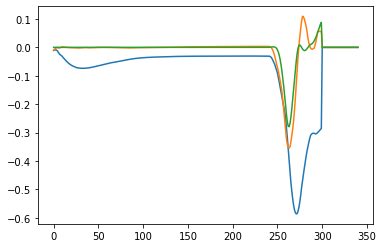

In [18]:
# Comparison of healthy vs lesioned behavior

example_idx = random.randrange(len(dataset))
example_din, _, trial_len, example_dout = dataset[example_idx]

mike.set_lesion(None)
mike.reset()
reference_pred_healthy = mike.unroll(example_din.T)

# Lesion the network as we specified above
mike.set_lesion(lesion_instance)
mike.reset()
reference_pred_lesioned = mike.unroll(example_din.T)
mike.reset()


comp_loss = torch.nn.MSELoss()

loader_comp = DataLoader(
  dataset, batch_size=len(dataset), shuffle=True
)
for s in loader_comp:
    din, trial_end, _, dout = s

comp_preds_healthy = torch.zeros((len(dataset), dataset.sample_len, reference_pred_healthy.shape[-1]))
if CUDA:
    comp_preds_healthy = comp_preds_healthy.cuda(CUDA)
    
mike.set_lesion(None)
mike.reset()
for tidx in range(din.shape[1]):
    cur_din = din[:, tidx, :].T
    p = mike(cur_din)
    comp_preds_healthy[:, tidx, :] = p[:, :]
comp_preds_healthy = utils.trunc_to_trial_end(comp_preds_healthy, trial_end)
comp_loss_healthy = comp_loss(comp_preds_healthy, dout)
print(comp_loss_healthy)

comp_preds_lesioned = torch.zeros((len(dataset), dataset.sample_len, reference_pred_healthy.shape[-1]))
if CUDA:
    comp_preds_lesioned = comp_preds_lesioned.cuda(CUDA)
mike.set_lesion(lesion_instance)
mike.reset()
reference_pred_lesioned = mike.unroll(example_din.T)
mike.reset()
for tidx in range(din.shape[1]):
    cur_din = din[:, tidx, :].T
    p = mike(cur_din)
    comp_preds_lesioned[:, tidx, :] = p[:, :]
comp_preds_lesioned = utils.trunc_to_trial_end(comp_preds_lesioned, trial_end)
comp_loss_lesioned = comp_loss(comp_preds_lesioned, dout)
print(comp_loss_lesioned)


plt.plot(comp_preds_lesioned[0, :, 20].cpu().detach().numpy())
plt.plot(comp_preds_healthy[0, :, 20].cpu().detach().numpy())
plt.plot(dout[0, :, 20].cpu().detach().numpy())
plt.show()


In [6]:
def unroll(cpn, mike, din, trial_end, observer,
           drop_module_idx=None, retain_stim_grads=False,
           cuda=None):
    batch_size = din.shape[0]
    steps = din.shape[1]
    obs_dim = 3 * observer.out_dim
    
    stims = []
    actuals = torch.zeros(batch_size, steps - 1, mike.output_dim)
    
    if cuda is not None:
        actuals = actuals.cuda(cuda)
    
    # This is the actual, which EN predicts
    mike_out = mike(din[:, 0, :].T)
    
    for tidx in range(steps - 1):
        obs = mike.observe(observer, drop_module_idx=drop_module_idx)
        new_obs_cpn = torch.cat(obs, axis=1).detach()


        # cpn recieves (obs, trial_end)
        cpn_in = torch.cat((new_obs_cpn, trial_end[:, tidx, :]), axis=1)
        # output is (batch_size, num_stim_channels)
        new_stim = cpn(cpn_in)
        assert new_stim.shape == (batch_size, mike.stimulus.num_stim_channels)
        if retain_stim_grads:
            new_stim.retain_grad()
        stims.append(new_stim)
            
        # new_stim will be cloned in here, to prevent accidentally backprop-ing
        # through the "brain", aka mike.
        mike.stimulate(new_stim)
                
        # Note that 'preds' lags 'actual' by a time step, hence
        # 'pred' is a prediction of the actual en activity
        mike_out = mike(din[:, tidx + 1, :].T)
        actuals[:, tidx, :] = mike_out[:, :]
        
    actuals = utils.trunc_to_trial_end(actuals, trial_end[:, :-1, :])
    return actuals, stims 

In [20]:
obs_dim = observer.out_dim * 3
# +1 for trial_end
cpn_in_dim = obs_dim + 1
#cpn = cpn_model.CPNModelLSTM(cpn_in_dim, mike.stimulus.num_stim_channels,
#                             num_neurons=cpn_in_dim, activation_func=torch.nn.Tanh,
#                             cuda=CUDA)


#opt_cpn = AdamW(cpn.parameters(), lr=5e-6)

# Just for zero grad purposes
#opt_mrnn = AdamW(mike.parameters(), weight_decay=0.02)

loss = torch.nn.MSELoss()

#real_losses = []
#test_losses = []
#super_epoch_count = 0
#eidx = -1
#rli = 1
while True:       
    super_epoch_count += 1

    while True:
        for batch in loader_train:
            eidx += 1
            opt_cpn.zero_grad()
            opt_mrnn.zero_grad()
            cpn.reset()
            mike.reset()
            
            if rli > 0.008:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-3
            elif rli >= 0.006:
                for p in opt_cpn.param_groups:
                    p['lr'] = 5e-4
            elif rli >= 0.002:
                for p in opt_cpn.param_groups:
                    p['lr'] = 2e-5
            else:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-6
            
            din, trial_end, trial_len, dout = batch
            batch_size = din.shape[0]
            steps = din.shape[1]
            
                                    
            # Test
            cpn.reset()
            mike.reset()
            batch_test = next(iter(loader_test))
            din_test, trial_end_test, trial_len_test, dout_test = batch_test
            batch_size_test = din_test.shape[0]
            steps_test = din_test.shape[1]
            actuals_test, stims_test = unroll(cpn, mike, din_test,
                                           trial_end_test, observer,
                                           cuda=CUDA)
            
            rl_test = loss(actuals_test, dout_test[:, 1:, :])
            rli_test = rl_test.item()
            test_losses.append(rli_test)
    
    
            # Train
            cpn.reset()
            mike.reset()
            actuals, stims = unroll(cpn, mike, din, trial_end, observer,
                                        retain_stim_grads=True,
                                        cuda=CUDA)
            
            rl = loss(actuals, dout[:, 1:, :])
            rli = rl.item()
            rl.backward()  
            opt_cpn.step()
            
            print(eidx, "train:", rli, "test:", rli_test)
            real_losses.append(rli)
            
            torch.save(cpn.state_dict(), "latest_cpn_F5condrop_obs20_stim92_nn150_noen")
            if rli == min(real_losses) and rli < 0.01:
                torch.save(cpn.state_dict(), "min_cpn_F5condrop_obs20_stim92_nn150_noen")
                                                          
            bail = False
            done = False
            # Done
            if rli < 5e-5:
                bail = True
                done = True
                break
                
            if bail:
                break    

               
        if bail:
            break
            
    if done:
        break

16652 train: 0.0010160673409700394 test: 0.001014981302432716
16653 train: 0.0010160555830225348 test: 0.0010148881701752543
16654 train: 0.001016082358546555 test: 0.0010149301961064339
16655 train: 0.001016072346828878 test: 0.0010150246089324355
16656 train: 0.0010160703677684069 test: 0.0010150911984965205
16657 train: 0.0010160604724660516 test: 0.001015120418742299
16658 train: 0.001016068272292614 test: 0.0010151469614356756
16659 train: 0.0010160565143451095 test: 0.0010150402085855603
16660 train: 0.0010160190286114812 test: 0.001015020301565528
16661 train: 0.0010160589590668678 test: 0.00101496372371912
16662 train: 0.0010160446399822831 test: 0.0010148786241188645
16663 train: 0.0010160357924178243 test: 0.0010148724541068077
16664 train: 0.0010160403326153755 test: 0.0010149861918762326
16665 train: 0.0010160347446799278 test: 0.0010150069138035178
16666 train: 0.0010160402162000537 test: 0.001015020883642137
16667 train: 0.0010160425445064902 test: 0.0010150910820811987
1

16784 train: 0.0010158108780160546 test: 0.0010149410227313638
16785 train: 0.0010158201912418008 test: 0.001014877576380968
16786 train: 0.001015785033814609 test: 0.0010148395085707307
16787 train: 0.0010157439392060041 test: 0.0010146894492208958
16788 train: 0.001015741378068924 test: 0.001014681882224977
16789 train: 0.001015732646919787 test: 0.0010144993430003524
16790 train: 0.0010157497599720955 test: 0.001014605863019824
16791 train: 0.0010157389333471656 test: 0.0010146253043785691
16792 train: 0.0010157552314922214 test: 0.0010146164568141103
16793 train: 0.0010157548822462559 test: 0.0010146570857614279
16794 train: 0.001015774323605001 test: 0.0010146942222490907
16795 train: 0.001015798537991941 test: 0.0010146748973056674
16796 train: 0.0010157669894397259 test: 0.0010147026041522622
16797 train: 0.0010157376527786255 test: 0.0010147355496883392
16798 train: 0.0010157389333471656 test: 0.001014427631162107
16799 train: 0.0010157593060284853 test: 0.001014488167129457
16

16915 train: 0.0010155304335057735 test: 0.0010146292624995112
16916 train: 0.0010154696647077799 test: 0.0010143331019207835
16917 train: 0.0010154575575143099 test: 0.0010139980586245656
16918 train: 0.0010154515039175749 test: 0.001014044159092009
16919 train: 0.001015442656353116 test: 0.0010143914259970188
16920 train: 0.0010154671035706997 test: 0.0010144481202587485
16921 train: 0.0010154704796150327 test: 0.00101422518491745
16922 train: 0.0010154758347198367 test: 0.0010142866522073746
16923 train: 0.0010155063355341554 test: 0.0010144241387024522
16924 train: 0.0010154583724215627 test: 0.0010143070248886943
16925 train: 0.0010154683841392398 test: 0.0010143432300537825
16926 train: 0.0010154535993933678 test: 0.0010142127284780145
16927 train: 0.0010154591873288155 test: 0.0010142333339899778
16928 train: 0.0010156393982470036 test: 0.0010149565059691668
16929 train: 0.0010154576739296317 test: 0.0010140404338017106
16930 train: 0.0010154537158086896 test: 0.0010140667436644

17047 train: 0.0010152010945603251 test: 0.0010141395032405853
17048 train: 0.0010151519672945142 test: 0.001014053006656468
17049 train: 0.0010151710594072938 test: 0.0010139591759070754
17050 train: 0.0010151616297662258 test: 0.0010136497439816594
17051 train: 0.0010151558090001345 test: 0.001014067092910409
17052 train: 0.0010152007453143597 test: 0.0010141499806195498
17053 train: 0.001015165587887168 test: 0.0010140964295715094
17054 train: 0.0010151546448469162 test: 0.001014040899462998
17055 train: 0.0010151632595807314 test: 0.0010136979399248958
17056 train: 0.0010151492897421122 test: 0.0010140329832211137
17057 train: 0.0010151740862056613 test: 0.0010139952646568418
17058 train: 0.0010151611641049385 test: 0.0010140019003301859
17059 train: 0.0010151572059839964 test: 0.001013928558677435
17060 train: 0.0010151495225727558 test: 0.0010139356600120664
17061 train: 0.0010151541791856289 test: 0.0010136653436347842
17062 train: 0.001015170244500041 test: 0.001014142180792987

17179 train: 0.0010148253059014678 test: 0.0010136767523363233
17180 train: 0.001014802255667746 test: 0.0010136987548321486
17181 train: 0.001014816458337009 test: 0.001013678265735507
17182 train: 0.0010148354340344667 test: 0.0010137263452634215
17183 train: 0.0010148115688934922 test: 0.0010136427590623498
17184 train: 0.0010148044675588608 test: 0.0010136564960703254
17185 train: 0.0010148220462724566 test: 0.001013703178614378
17186 train: 0.0010148185538128018 test: 0.001013714587315917
17187 train: 0.0010148071451112628 test: 0.0010137520730495453
17188 train: 0.0010148355504497886 test: 0.001013734145089984
17189 train: 0.0010147945722565055 test: 0.0010137263452634215
17190 train: 0.0010147914290428162 test: 0.0010137014323845506
17191 train: 0.0010148250730708241 test: 0.0010135530028492212
17192 train: 0.001014798879623413 test: 0.0010134689509868622
17193 train: 0.0010147939901798964 test: 0.0010135771008208394
17194 train: 0.0010148035362362862 test: 0.0010136185446754098

17311 train: 0.001014510984532535 test: 0.0010132747702300549
17312 train: 0.0010145062115043402 test: 0.0010134467156603932
17313 train: 0.0010145126143470407 test: 0.0010134397307410836
17314 train: 0.0010145546402782202 test: 0.001013502012938261
17315 train: 0.0010145293781533837 test: 0.0010135021293535829
17316 train: 0.0010145418345928192 test: 0.0010135381016880274
17317 train: 0.0010145538253709674 test: 0.0010135788470506668
17318 train: 0.001014492940157652 test: 0.0010134835029020905
17319 train: 0.0010144923580810428 test: 0.0010133041068911552
17320 train: 0.00101451703812927 test: 0.001013350673019886
17321 train: 0.001014505629427731 test: 0.00101335474755615
17322 train: 0.0010144859552383423 test: 0.0010133077157661319
17323 train: 0.0010145386913791299 test: 0.0010133208706974983
17324 train: 0.0010145133128389716 test: 0.0010131356539204717
17325 train: 0.0010144863044843078 test: 0.0010131755843758583
17326 train: 0.0010145078413188457 test: 0.0010134063195437193
1

17442 train: 0.0010141783859580755 test: 0.0010128115536645055
17443 train: 0.0010142041137441993 test: 0.0010125878034159541
17444 train: 0.0010142239043489099 test: 0.0010128762805834413
17445 train: 0.0010142495157197118 test: 0.0010131584713235497
17446 train: 0.0010142368264496326 test: 0.0010131613817065954
17447 train: 0.0010142370592802763 test: 0.0010130936279892921
17448 train: 0.0010141744278371334 test: 0.0010128997964784503
17449 train: 0.0010141914244741201 test: 0.0010127784917131066
17450 train: 0.0010141594102606177 test: 0.0010127660352736712
17451 train: 0.0010141435777768493 test: 0.0010128237772732973
17452 train: 0.001014192239381373 test: 0.0010129616130143404
17453 train: 0.0010142039973288774 test: 0.001013111206702888
17454 train: 0.0010141991078853607 test: 0.001013090368360281
17455 train: 0.0010141544044017792 test: 0.0010130085283890367
17456 train: 0.001014132983982563 test: 0.0010129588190466166
17457 train: 0.0010141580132767558 test: 0.0010128628928214

17573 train: 0.0010138594079762697 test: 0.0010127476416528225
17574 train: 0.0010138395009562373 test: 0.0010126427514478564
17575 train: 0.001013841130770743 test: 0.0010124280815944076
17576 train: 0.0010138320503756404 test: 0.0010124504333361983
17577 train: 0.0010138785000890493 test: 0.0010125464759767056
17578 train: 0.0010138481156900525 test: 0.0010125936241820455
17579 train: 0.0010138305369764566 test: 0.0010124552063643932
17580 train: 0.001013861270621419 test: 0.001012452645227313
17581 train: 0.0010138594079762697 test: 0.0010123837273567915
17582 train: 0.0010138447396457195 test: 0.0010123883839696646
17583 train: 0.0010138546349480748 test: 0.001012382679618895
17584 train: 0.0010138580109924078 test: 0.0010125136468559504
17585 train: 0.0010138731449842453 test: 0.0010124373948201537
17586 train: 0.0010138517245650291 test: 0.0010123876854777336
17587 train: 0.0010138468351215124 test: 0.0010123569518327713
17588 train: 0.0010138577781617641 test: 0.0010124010732397

17704 train: 0.001013483153656125 test: 0.0010121787199750543
17705 train: 0.001013527624309063 test: 0.0010123205138370395
17706 train: 0.0010135786142200232 test: 0.001012515276670456
17707 train: 0.0010135095799341798 test: 0.0010124288965016603
17708 train: 0.001013471162877977 test: 0.0010121981613337994
17709 train: 0.0010134720942005515 test: 0.0010121118975803256
17710 train: 0.0010134723270311952 test: 0.0010121361119672656
17711 train: 0.0010134545154869556 test: 0.0010121584637090564
17712 train: 0.0010134908370673656 test: 0.0010124027030542493
17713 train: 0.0010135102784261107 test: 0.0010124685941264033
17714 train: 0.001013505388982594 test: 0.0010124660329893231
17715 train: 0.0010134680196642876 test: 0.0010121917584910989
17716 train: 0.001013447530567646 test: 0.0010121356463059783
17717 train: 0.0010134861804544926 test: 0.0010121444938704371
17718 train: 0.0010134921176359057 test: 0.0010123444953933358
17719 train: 0.0010134715121239424 test: 0.001012344961054623

17836 train: 0.0010131290182471275 test: 0.0010118295904248953
17837 train: 0.001013105153106153 test: 0.0010118171339854598
17838 train: 0.0010131087619811296 test: 0.001011866726912558
17839 train: 0.0010130801238119602 test: 0.001011767191812396
17840 train: 0.0010131100425496697 test: 0.0010117895435541868
17841 train: 0.0010131278540939093 test: 0.0010118329664692283
17842 train: 0.0010131149319931865 test: 0.001011925982311368
17843 train: 0.0010130885057151318 test: 0.00101195287425071
17844 train: 0.0010130852460861206 test: 0.0010119754588231444
17845 train: 0.0010130826849490404 test: 0.0010119251674041152
17846 train: 0.0010130698792636395 test: 0.0010117447236552835
17847 train: 0.0010130571899935603 test: 0.001011867425404489
17848 train: 0.0010130670852959156 test: 0.0010119755752384663
17849 train: 0.0010131429880857468 test: 0.0010122291278094053
17850 train: 0.0010130589362233877 test: 0.0010119688231498003
17851 train: 0.0010130542796105146 test: 0.0010120040969923139

17967 train: 0.00101283413823694 test: 0.0010116592748090625
17968 train: 0.0010129197034984827 test: 0.0010108512360602617
17969 train: 0.0010128311114385724 test: 0.0010116243502125144
17970 train: 0.0010128006106242537 test: 0.0010112583404406905
17971 train: 0.001012780936434865 test: 0.0010113912867382169
17972 train: 0.0010128659196197987 test: 0.0010117565980181098
17973 train: 0.0010127905989065766 test: 0.0010111473966389894
17974 train: 0.001012768130749464 test: 0.0010111166629940271
17975 train: 0.001012987457215786 test: 0.0010123217944055796
17976 train: 0.001012721681036055 test: 0.0010111837182193995
17977 train: 0.0010127550922334194 test: 0.0010112131712958217
17978 train: 0.0010128314606845379 test: 0.0010117198107764125
17979 train: 0.001012741238810122 test: 0.0010112676536664367
17980 train: 0.0010127428686246276 test: 0.0010112638119608164
17981 train: 0.0010130568407475948 test: 0.0010120249353349209
17982 train: 0.0010127491550520062 test: 0.00101099768653512
1

18099 train: 0.0010123737156391144 test: 0.0010110499570146203
18100 train: 0.0010124299442395568 test: 0.0010111178271472454
18101 train: 0.0010124357650056481 test: 0.0010111629962921143
18102 train: 0.0010124273831024766 test: 0.0010108352871611714
18103 train: 0.0010124088730663061 test: 0.001010777079500258
18104 train: 0.00101238745264709 test: 0.00101073132827878
18105 train: 0.001012402935884893 test: 0.001011089188978076
18106 train: 0.0010123873362317681 test: 0.0010110782459378242
18107 train: 0.0010123708052560687 test: 0.0010110198054462671
18108 train: 0.0010123664978891611 test: 0.0010108866263180971
18109 train: 0.0010123879183083773 test: 0.0010111361043527722
18110 train: 0.001012439955957234 test: 0.001011393964290619
18111 train: 0.0010123831452801824 test: 0.0010110026923939586
18112 train: 0.0010123661486431956 test: 0.0010107116540893912
18113 train: 0.0010123474057763815 test: 0.001010895473882556
18114 train: 0.0010123767424374819 test: 0.0010110381990671158
18

18231 train: 0.0010120270308107138 test: 0.0010100817307829857
18232 train: 0.001011980464681983 test: 0.0010102945379912853
18233 train: 0.0010120520601049066 test: 0.0010106851113960147
18234 train: 0.001011991873383522 test: 0.0010106301633641124
18235 train: 0.0010120703373104334 test: 0.0010100544895976782
18236 train: 0.001011971035040915 test: 0.0010105720721185207
18237 train: 0.001012005377560854 test: 0.0010106769623234868
18238 train: 0.001011965679936111 test: 0.001010639127343893
18239 train: 0.001011927961371839 test: 0.0010102568194270134
18240 train: 0.0010119980433955789 test: 0.0010107135167345405
18241 train: 0.0010119403013959527 test: 0.0010107095586135983
18242 train: 0.0010119406506419182 test: 0.0010105728870257735
18243 train: 0.001011956250295043 test: 0.0010102532105520368
18244 train: 0.0010119330836459994 test: 0.0010107009438797832
18245 train: 0.0010119761573150754 test: 0.0010108462302014232
18246 train: 0.0010119579965248704 test: 0.0010107617126777768


18363 train: 0.0010115860495716333 test: 0.0010101322550326586
18364 train: 0.001011582207866013 test: 0.0010100208455696702
18365 train: 0.001011533080600202 test: 0.0010099423816427588
18366 train: 0.0010115719633176923 test: 0.0010099419159814715
18367 train: 0.0010116012999787927 test: 0.0010101200314238667
18368 train: 0.0010115820914506912 test: 0.0010101611260324717
18369 train: 0.0010115716140717268 test: 0.0010101794032379985
18370 train: 0.0010115313343703747 test: 0.0010100825456902385
18371 train: 0.0010115106124430895 test: 0.001010027015581727
18372 train: 0.0010115288896486163 test: 0.0010099770734086633
18373 train: 0.00101150618866086 test: 0.0010099814971908927
18374 train: 0.001011521671898663 test: 0.0010100496001541615
18375 train: 0.0010115072363987565 test: 0.001010049250908196
18376 train: 0.001011571497656405 test: 0.0010102017549797893
18377 train: 0.0010115498444065452 test: 0.0010101463412865996
18378 train: 0.0010115652112290263 test: 0.0010096345795318484


18495 train: 0.0010114171309396625 test: 0.0010107712587341666
18496 train: 0.001011157175526023 test: 0.001009531901217997
18497 train: 0.0010111695155501366 test: 0.0010092294542118907
18498 train: 0.0010111035080626607 test: 0.0010095605393871665
18499 train: 0.0010111770825460553 test: 0.0010099102510139346
18500 train: 0.001011139596812427 test: 0.0010098308557644486
18501 train: 0.0010111582232639194 test: 0.0010093051241710782
18502 train: 0.0010111767333000898 test: 0.001009247382171452
18503 train: 0.001011216314509511 test: 0.0010099377250298858
18504 train: 0.0010114156175404787 test: 0.0010106328409165144
18505 train: 0.001011169864796102 test: 0.0010089154820889235
18506 train: 0.001011096639558673 test: 0.001009280444122851
18507 train: 0.0010111298179253936 test: 0.0010098079219460487
18508 train: 0.001011439599096775 test: 0.0010105910478159785
18509 train: 0.0010110988514497876 test: 0.0010091906879097223
18510 train: 0.001011235173791647 test: 0.0010088534327223897
18

18626 train: 0.00101074343547225 test: 0.0010093001183122396
18627 train: 0.0010107738198712468 test: 0.0010094953468069434
18628 train: 0.0010106993140652776 test: 0.0010088077979162335
18629 train: 0.0010106998961418867 test: 0.0010087847476825118
18630 train: 0.0010107300477102399 test: 0.0010093285236507654
18631 train: 0.0010107432026416063 test: 0.0010093232849612832
18632 train: 0.0010106679983437061 test: 0.0010088011622428894
18633 train: 0.0010106710251420736 test: 0.0010088109411299229
18634 train: 0.0010106805711984634 test: 0.0010091367876157165
18635 train: 0.0010106569388881326 test: 0.0010091336444020271
18636 train: 0.0010106844129040837 test: 0.0010089337592944503
18637 train: 0.0010107053676620126 test: 0.0010085810208693147
18638 train: 0.0010107107227668166 test: 0.0010091739241033792
18639 train: 0.0010107163107022643 test: 0.0010092630982398987
18640 train: 0.0010107040870934725 test: 0.0010092246811836958
18641 train: 0.0010106440167874098 test: 0.00100902118720

18757 train: 0.0010103373788297176 test: 0.0010089135030284524
18758 train: 0.001010263105854392 test: 0.001008836436085403
18759 train: 0.001010265201330185 test: 0.0010086704278364778
18760 train: 0.0010102973319590092 test: 0.0010089629795402288
18761 train: 0.0010102946544066072 test: 0.0010089841671288013
18762 train: 0.001010300125926733 test: 0.0010083024390041828
18763 train: 0.001010338426567614 test: 0.001009058323688805
18764 train: 0.0010102835949510336 test: 0.0010088550625368953
18765 train: 0.0010103570530191064 test: 0.0010082778753712773
18766 train: 0.0010103180538862944 test: 0.0010091053554788232
18767 train: 0.0010103486711159348 test: 0.0010091637959703803
18768 train: 0.0010102533269673586 test: 0.001008646679110825
18769 train: 0.0010104149114340544 test: 0.0010081948712468147
18770 train: 0.0010102762607857585 test: 0.0010088157141581178
18771 train: 0.0010103723034262657 test: 0.0010091192089021206
18772 train: 0.0010103093227371573 test: 0.0010090525029227138

18889 train: 0.0010099493665620685 test: 0.0010087111731991172
18890 train: 0.0010098919738084078 test: 0.001008499413728714
18891 train: 0.0010098522761836648 test: 0.0010080612264573574
18892 train: 0.0010099475039169192 test: 0.001008797436952591
18893 train: 0.0010099099017679691 test: 0.001008598948828876
18894 train: 0.001009822473861277 test: 0.0010083387605845928
18895 train: 0.0010098364436998963 test: 0.0010082698427140713
18896 train: 0.0010098827769979835 test: 0.0010085167596116662
18897 train: 0.0010098657803609967 test: 0.0010083814850077033
18898 train: 0.0010098774218931794 test: 0.0010083516826853156
18899 train: 0.0010099329520016909 test: 0.0010077786864712834
18900 train: 0.0010099244536831975 test: 0.0010088228154927492
18901 train: 0.001010000822134316 test: 0.0010089789284393191
18902 train: 0.0010098486673086882 test: 0.001008377643302083
18903 train: 0.001010329113341868 test: 0.0010077061597257853
18904 train: 0.0010100726503878832 test: 0.0010090672876685858

19021 train: 0.001009470666758716 test: 0.0010079678613692522
19022 train: 0.0010094919707626104 test: 0.0010080350330099463
19023 train: 0.0010094494791701436 test: 0.0010076409671455622
19024 train: 0.00100940081756562 test: 0.001007815240882337
19025 train: 0.0010093890596181154 test: 0.0010078116320073605
19026 train: 0.0010094373719766736 test: 0.0010079441126435995
19027 train: 0.0010094261961057782 test: 0.0010075719328597188
19028 train: 0.0010093988385051489 test: 0.0010078605264425278
19029 train: 0.0010094211902469397 test: 0.0010078817140311003
19030 train: 0.0010094201425090432 test: 0.0010079647181555629
19031 train: 0.00100941292475909 test: 0.0010076487669721246
19032 train: 0.0010094495955854654 test: 0.0010076422477141023
19033 train: 0.0010094124590978026 test: 0.001007965300232172
19034 train: 0.0010093776509165764 test: 0.0010078963823616505
19035 train: 0.0010094324825331569 test: 0.0010075699537992477
19036 train: 0.0010094292229041457 test: 0.0010080654174089432

19153 train: 0.0010089935967698693 test: 0.0010073708835989237
19154 train: 0.0010090814903378487 test: 0.001007782411761582
19155 train: 0.0010090323630720377 test: 0.001007683458738029
19156 train: 0.0010090071009472013 test: 0.0010072396835312247
19157 train: 0.0010089654242619872 test: 0.0010072580771520734
19158 train: 0.0010089746210724115 test: 0.0010074250167235732
19159 train: 0.0010089424904435873 test: 0.0010074451565742493
19160 train: 0.0010090299183502793 test: 0.0010075218742713332
19161 train: 0.001008983701467514 test: 0.0010072619188576937
19162 train: 0.0010089215356856585 test: 0.0010072797304019332
19163 train: 0.001008927938528359 test: 0.0010072167497128248
19164 train: 0.0010089639108628035 test: 0.0010073261801153421
19165 train: 0.0010089986026287079 test: 0.0010074942838400602
19166 train: 0.001008946797810495 test: 0.0010074040619656444
19167 train: 0.0010089556453749537 test: 0.0010073900921270251
19168 train: 0.0010089577408507466 test: 0.00100739893969148

19285 train: 0.0010085436515510082 test: 0.0010067545808851719
19286 train: 0.0010085568064823747 test: 0.0010070272255688906
19287 train: 0.0010087206028401852 test: 0.001007423154078424
19288 train: 0.0010086382972076535 test: 0.0010073677403852344
19289 train: 0.0010085297981277108 test: 0.0010068180272355676
19290 train: 0.0010085575049743056 test: 0.0010066633112728596
19291 train: 0.0010085373651236296 test: 0.001006987877190113
19292 train: 0.0010086895199492574 test: 0.0010074966121464968
19293 train: 0.0010086458642035723 test: 0.0010073978919535875
19294 train: 0.0010085445828735828 test: 0.0010070806602016091
19295 train: 0.0010085764806717634 test: 0.0010065542301163077
19296 train: 0.0010085038375109434 test: 0.0010070730932056904
19297 train: 0.0010086250258609653 test: 0.001007347134873271
19298 train: 0.0010086348047479987 test: 0.001007350510917604
19299 train: 0.001008485909551382 test: 0.0010068523697555065
19300 train: 0.001008518971502781 test: 0.001006577047519385

19416 train: 0.001008152263239026 test: 0.0010061176726594567
19417 train: 0.001008064136840403 test: 0.001006274833343923
19418 train: 0.0010083584347739816 test: 0.0010071847354993224
19419 train: 0.0010080955689772964 test: 0.001006312551908195
19420 train: 0.001008152263239026 test: 0.0010061407228931785
19421 train: 0.0010080927750095725 test: 0.0010063163936138153
19422 train: 0.0010082194348797202 test: 0.0010068617993965745
19423 train: 0.0010081017389893532 test: 0.001006348174996674
19424 train: 0.001008087769150734 test: 0.0010062488727271557
19425 train: 0.0010080945212394 test: 0.0010062616784125566
19426 train: 0.001008105929940939 test: 0.0010065360693261027
19427 train: 0.0010081168729811907 test: 0.0010065765818580985
19428 train: 0.001008082996122539 test: 0.0010063929948955774
19429 train: 0.0010080717038363218 test: 0.0010062761139124632
19430 train: 0.0010080442298203707 test: 0.001006392645649612
19431 train: 0.0010080828797072172 test: 0.001006708713248372
19432 

19548 train: 0.0010076812468469143 test: 0.0010059665655717254
19549 train: 0.001007686834782362 test: 0.001006032689474523
19550 train: 0.0010076636681333184 test: 0.0010061135981231928
19551 train: 0.0010077268816530704 test: 0.0010063520167022943
19552 train: 0.0010077020851895213 test: 0.001006117439828813
19553 train: 0.001007669954560697 test: 0.0010058687767013907
19554 train: 0.0010076629696413875 test: 0.0010059671476483345
19555 train: 0.0010077108163386583 test: 0.0010060728527605534
19556 train: 0.0010076590115204453 test: 0.001006015227176249
19557 train: 0.001007656566798687 test: 0.0010058697080239654
19558 train: 0.001007705694064498 test: 0.0010058479383587837
19559 train: 0.0010076843900606036 test: 0.001006308593787253
19560 train: 0.0010077913757413626 test: 0.0010066537652164698
19561 train: 0.0010076425969600677 test: 0.0010061050998046994
19562 train: 0.0010077296756207943 test: 0.001005760277621448
19563 train: 0.0010076221078634262 test: 0.0010058525949716568
1

19680 train: 0.0010072389850392938 test: 0.0010055819293484092
19681 train: 0.0010072346776723862 test: 0.0010054422309622169
19682 train: 0.0010072230361402035 test: 0.0010057053295895457
19683 train: 0.0010072384029626846 test: 0.0010057738982141018
19684 train: 0.001007251674309373 test: 0.001005513477139175
19685 train: 0.0010072537697851658 test: 0.0010054613230749965
19686 train: 0.001007230021059513 test: 0.001005419879220426
19687 train: 0.0010072434088215232 test: 0.0010054772719740868
19688 train: 0.0010072230361402035 test: 0.0010056744795292616
19689 train: 0.001007205806672573 test: 0.0010056523606181145
19690 train: 0.001007205806672573 test: 0.0010054270969703794
19691 train: 0.001007227343507111 test: 0.0010051144054159522
19692 train: 0.001007230021059513 test: 0.001005705213174224
19693 train: 0.0010072501609101892 test: 0.001005889498628676
19694 train: 0.0010071794968098402 test: 0.0010057355975732207
19695 train: 0.001007158076390624 test: 0.001005356083624065
1969

19812 train: 0.0010067697148770094 test: 0.001004987396299839
19813 train: 0.001006782054901123 test: 0.0010048539843410254
19814 train: 0.0010068094125017524 test: 0.0010050121927633882
19815 train: 0.0010068124393001199 test: 0.0010051778517663479
19816 train: 0.0010067452676594257 test: 0.0010048350086435676
19817 train: 0.0010067530674859881 test: 0.0010048092808574438
19818 train: 0.0010067230323329568 test: 0.0010047215037047863
19819 train: 0.0010067624971270561 test: 0.001005081576295197
19820 train: 0.0010067472467198968 test: 0.001004964578896761
19821 train: 0.0010067024268209934 test: 0.0010048700496554375
19822 train: 0.0010067155817523599 test: 0.001004686113446951
19823 train: 0.001006689970381558 test: 0.0010048085823655128
19824 train: 0.0010067066177725792 test: 0.001005202648229897
19825 train: 0.001006738399155438 test: 0.0010052128927782178
19826 train: 0.0010066856630146503 test: 0.0010047415271401405
19827 train: 0.0010067321127280593 test: 0.0010045139351859689


19943 train: 0.0010062707588076591 test: 0.0010044247610494494
19944 train: 0.0010062928777188063 test: 0.0010046265088021755
19945 train: 0.00100630521774292 test: 0.0010048204567283392
19946 train: 0.0010062799556180835 test: 0.0010047045070677996
19947 train: 0.0010062804212793708 test: 0.001004579127766192
19948 train: 0.0010062378132715821 test: 0.0010044339578598738
19949 train: 0.0010062763467431068 test: 0.0010045329108834267
19950 train: 0.0010062848450616002 test: 0.0010047982214018703
19951 train: 0.0010062772780656815 test: 0.0010047790128737688
19952 train: 0.001006241887807846 test: 0.0010045624803751707
19953 train: 0.001006250618956983 test: 0.0010043560760095716
19954 train: 0.0010062226792797446 test: 0.0010044024093076587
19955 train: 0.0010062321089208126 test: 0.0010046549141407013
19956 train: 0.0010062939254567027 test: 0.0010048241820186377
19957 train: 0.001006221049465239 test: 0.0010044333757832646
19958 train: 0.0010062181390821934 test: 0.001004467601887881

20075 train: 0.0010058180196210742 test: 0.001004029531031847
20076 train: 0.0010057869367301464 test: 0.0010038745822384953
20077 train: 0.0010057907784357667 test: 0.0010040153283625841
20078 train: 0.0010058467742055655 test: 0.00100422790274024
20079 train: 0.0010057719191536307 test: 0.0010038200998678803
20080 train: 0.001005768426693976 test: 0.0010037915781140327
20081 train: 0.0010057861218228936 test: 0.001003825105726719
20082 train: 0.0010058553889393806 test: 0.0010042388457804918
20083 train: 0.0010057386243715882 test: 0.001004007295705378
20084 train: 0.0010057584149762988 test: 0.0010038581676781178
20085 train: 0.0010057624895125628 test: 0.0010040532797574997
20086 train: 0.001005736761726439 test: 0.0010039083426818252
20087 train: 0.0010057269828394055 test: 0.0010039840126410127
20088 train: 0.001005756901577115 test: 0.001004012650810182
20089 train: 0.001005717320367694 test: 0.0010038834298029542
20090 train: 0.0010057301260530949 test: 0.0010038429172709584
20

20207 train: 0.0010054412996396422 test: 0.0010030331322923303
20208 train: 0.0010053827427327633 test: 0.0010035847080871463
20209 train: 0.0010054984595626593 test: 0.0010040198685601354
20210 train: 0.0010053567821159959 test: 0.0010036991443485022
20211 train: 0.0010053216246888041 test: 0.0010032765567302704
20212 train: 0.0010053305886685848 test: 0.0010034089209511876
20213 train: 0.0010055159218609333 test: 0.0010042276699095964
20214 train: 0.0010054042795673013 test: 0.001004001242108643
20215 train: 0.001005304278805852 test: 0.001003403915092349
20216 train: 0.0010053463047370315 test: 0.0010033714352175593
20217 train: 0.001005338504910469 test: 0.0010037882020696998
20218 train: 0.0010054400190711021 test: 0.0010041218483820558
20219 train: 0.0010052715661004186 test: 0.0010033247526735067
20220 train: 0.0010052757570520043 test: 0.00100329692941159
20221 train: 0.0010054436279460788 test: 0.0010038913460448384
20222 train: 0.001005276688374579 test: 0.0010032611899077892

20339 train: 0.0010049021802842617 test: 0.0010029595578089356
20340 train: 0.0010049091652035713 test: 0.0010030313860625029
20341 train: 0.001004895195364952 test: 0.0010031025158241391
20342 train: 0.0010049137054011226 test: 0.0010030647972598672
20343 train: 0.0010048906551674008 test: 0.001002810662612319
20344 train: 0.0010048742406070232 test: 0.0010031027486547828
20345 train: 0.0010050386190414429 test: 0.0010034342994913459
20346 train: 0.0010048720287159085 test: 0.001002920907922089
20347 train: 0.001004878431558609 test: 0.0010026602540165186
20348 train: 0.0010048507247120142 test: 0.0010027969256043434
20349 train: 0.0010048943804576993 test: 0.0010030192788690329
20350 train: 0.0010049347765743732 test: 0.0010032204445451498
20351 train: 0.0010048573603853583 test: 0.0010030597914010286
20352 train: 0.0010048502590507269 test: 0.0010024728253483772
20353 train: 0.0010048758704215288 test: 0.001002973411232233
20354 train: 0.0010050314012914896 test: 0.00100335059687495

20471 train: 0.00100451719481498 test: 0.0010025951778516173
20472 train: 0.0010045095114037395 test: 0.0010027472162619233
20473 train: 0.001004486228339374 test: 0.001002598786726594
20474 train: 0.0010044523514807224 test: 0.0010023058857768774
20475 train: 0.0010044160299003124 test: 0.0010023083304986358
20476 train: 0.0010045223170891404 test: 0.0010029181139543653
20477 train: 0.0010045025264844298 test: 0.001002881908789277
20478 train: 0.0010043815709650517 test: 0.0010022834176197648
20479 train: 0.0010044705122709274 test: 0.0010021711932495236
20480 train: 0.0010043852962553501 test: 0.0010024082148447633
20481 train: 0.0010044450173154473 test: 0.0010027989046648145
20482 train: 0.0010044415248557925 test: 0.001002834876999259
20483 train: 0.0010043965885415673 test: 0.0010024798102676868
20484 train: 0.0010044099763035774 test: 0.0010022895876318216
20485 train: 0.0010043563088402152 test: 0.001002574572339654
20486 train: 0.0010044173104688525 test: 0.0010027086827903986

20603 train: 0.0010039623593911529 test: 0.0010017800377681851
20604 train: 0.0010040203342214227 test: 0.0010023302165791392
20605 train: 0.0010039712069556117 test: 0.0010018638567999005
20606 train: 0.0010039446642622352 test: 0.001002076081931591
20607 train: 0.0010040296474471688 test: 0.0010025526862591505
20608 train: 0.0010039550252258778 test: 0.0010019834153354168
20609 train: 0.001003944082185626 test: 0.001001997385174036
20610 train: 0.0010040353517979383 test: 0.0010026287054643035
20611 train: 0.0010039347689598799 test: 0.0010021189227700233
20612 train: 0.0010040620109066367 test: 0.0010016539599746466
20613 train: 0.0010040256893262267 test: 0.0010026807431131601
20614 train: 0.0010040345368906856 test: 0.0010026469826698303
20615 train: 0.0010039623593911529 test: 0.001001684577204287
20616 train: 0.0010039429180324078 test: 0.0010017206659540534
20617 train: 0.0010041231289505959 test: 0.0010026250965893269
20618 train: 0.0010040213819593191 test: 0.0010021361522376

20735 train: 0.0010037089232355356 test: 0.001000978285446763
20736 train: 0.001003751764073968 test: 0.0010022284695878625
20737 train: 0.001003687153570354 test: 0.0010021276539191604
20738 train: 0.0010036261519417167 test: 0.00100092520006001
20739 train: 0.0010034505976364017 test: 0.0010013115825131536
20740 train: 0.0010036393068730831 test: 0.0010022001806646585
20741 train: 0.0010034156730398536 test: 0.0010016545420512557
20742 train: 0.001003615907393396 test: 0.001000947318971157
20743 train: 0.0010034785373136401 test: 0.0010017455788329244
20744 train: 0.0010035865707322955 test: 0.001002226141281426
20745 train: 0.0010035199811682105 test: 0.001001017983071506
20746 train: 0.0010033776052296162 test: 0.0010012703714892268
20747 train: 0.0010035806335508823 test: 0.0010020361514762044
20748 train: 0.0010034438455477357 test: 0.0010015544248744845
20749 train: 0.001003514975309372 test: 0.0010008863173425198
20750 train: 0.0010034589795395732 test: 0.0010010201949626207
20

20867 train: 0.0010031075216829777 test: 0.0010007802629843354
20868 train: 0.001003029989078641 test: 0.0010010492987930775
20869 train: 0.00100316246971488 test: 0.001001620665192604
20870 train: 0.0010030429111793637 test: 0.0010010749101638794
20871 train: 0.001003039418719709 test: 0.0010010760743170977
20872 train: 0.0010031188139691949 test: 0.0010014245053753257
20873 train: 0.0010030384873971343 test: 0.0010011300910264254
20874 train: 0.0010030863340944052 test: 0.0010008580284193158
20875 train: 0.0010030322009697556 test: 0.0010011688573285937
20876 train: 0.00100304139778018 test: 0.0010011902777478099
20877 train: 0.0010029998375102878 test: 0.0010011069243773818
20878 train: 0.0010030475677922368 test: 0.0010008378885686398
20879 train: 0.0010030579287558794 test: 0.001000903663225472
20880 train: 0.0010030181147158146 test: 0.001001161290332675
20881 train: 0.0010032913414761424 test: 0.0010019215987995267
20882 train: 0.001003063516691327 test: 0.0010005742078647017
20

20999 train: 0.0010025849333032966 test: 0.0010005877120420337
21000 train: 0.0010025735246017575 test: 0.0010004894575104117
21001 train: 0.0010025753872469068 test: 0.001000488642603159
21002 train: 0.0010025962255895138 test: 0.0010004963260143995
21003 train: 0.0010025918018072844 test: 0.0010006353259086609
21004 train: 0.0010026058880612254 test: 0.0010005527874454856
21005 train: 0.0010025594383478165 test: 0.001000431482680142
21006 train: 0.0010025383671745658 test: 0.001000399119220674
21007 train: 0.0010025532683357596 test: 0.0010003498755395412
21008 train: 0.0010025501251220703 test: 0.0010004385840147734
21009 train: 0.0010025528026744723 test: 0.0010005526710301638
21010 train: 0.0010025928495451808 test: 0.001000656164251268
21011 train: 0.0010025857482105494 test: 0.0010007498785853386
21012 train: 0.0010025340598076582 test: 0.0010003935312852263
21013 train: 0.0010025723604485393 test: 0.0010002150665968657
21014 train: 0.0010025403462350368 test: 0.0010003350907936

21131 train: 0.0010022196220234036 test: 0.0010003200732171535
21132 train: 0.0010021696798503399 test: 0.001000130083411932
21133 train: 0.001002173637971282 test: 0.0010002049384638667
21134 train: 0.0010021859779953957 test: 0.001000224961899221
21135 train: 0.001002156757749617 test: 0.00100023637060076
21136 train: 0.0010021607158705592 test: 0.0010003171628341079
21137 train: 0.0010021781781688333 test: 0.0010003037750720978
21138 train: 0.0010021334746852517 test: 0.001000226242467761
21139 train: 0.0010021135676652193 test: 0.001000204007141292
21140 train: 0.0010021313792094588 test: 0.0010002090130001307
21141 train: 0.0010021469788625836 test: 0.0010002601193264127
21142 train: 0.0010021404596045613 test: 0.001000326476059854
21143 train: 0.0010022121714428067 test: 0.001000543823465705
21144 train: 0.0010021119378507137 test: 0.000999905401840806
21145 train: 0.0010021098423749208 test: 0.0009998454479500651
21146 train: 0.0010022007627412677 test: 0.0010004693176597357
211

21263 train: 0.001001777476631105 test: 0.000999785726889968
21264 train: 0.0010025096125900745 test: 0.0009991461411118507
21265 train: 0.0010018986649811268 test: 0.0010000718757510185
21266 train: 0.0010020320769399405 test: 0.0010003816569224
21267 train: 0.0010018670000135899 test: 0.00099995790515095
21268 train: 0.0010020980844274163 test: 0.0009992104023694992
21269 train: 0.0010016979649662971 test: 0.0009992688428610563
21270 train: 0.0010022034402936697 test: 0.0010008226381614804
21271 train: 0.001002143369987607 test: 0.0010006899246945977
21272 train: 0.0010016598971560597 test: 0.0009993953863158822
21273 train: 0.0010022699134424329 test: 0.0009990896796807647
21274 train: 0.0010018582688644528 test: 0.000999904004856944
21275 train: 0.0010020759655162692 test: 0.0010004978394135833
21276 train: 0.0010016863234341145 test: 0.0009996630251407623
21277 train: 0.0010019919136539102 test: 0.0009989819955080748
21278 train: 0.001001715543679893 test: 0.0009994953870773315
21

21395 train: 0.0010013141436502337 test: 0.0009989187819883227
21396 train: 0.0010013259015977383 test: 0.0009989565005525947
21397 train: 0.0010012923739850521 test: 0.0009993327548727393
21398 train: 0.0010013132123276591 test: 0.000999299343675375
21399 train: 0.0010012713028118014 test: 0.0009990595281124115
21400 train: 0.001001281081698835 test: 0.0009990751277655363
21401 train: 0.0010012714192271233 test: 0.0009990035323426127
21402 train: 0.0010012559359893203 test: 0.0009992039995267987
21403 train: 0.0010013439459726214 test: 0.0009996065637096763
21404 train: 0.001001342898234725 test: 0.0009994463762268424
21405 train: 0.0010012784041464329 test: 0.0009990778053179383
21406 train: 0.0010012371931225061 test: 0.0009988319361582398
21407 train: 0.0010012984275817871 test: 0.0009988181991502643
21408 train: 0.0010012617567554116 test: 0.000999198411591351
21409 train: 0.0010013006394729018 test: 0.0009993996936827898
21410 train: 0.0010012977290898561 test: 0.0009992999257519

21527 train: 0.0010009133256971836 test: 0.0009989378741011024
21528 train: 0.0010008756071329117 test: 0.0009988239035010338
21529 train: 0.00100087805185467 test: 0.000998755102045834
21530 train: 0.0010008731624111533 test: 0.0009987573139369488
21531 train: 0.0010009268298745155 test: 0.0009988424135372043
21532 train: 0.0010009107645601034 test: 0.0009989299578592181
21533 train: 0.00100092648062855 test: 0.0009989608079195023
21534 train: 0.0010009027319028974 test: 0.0009987743105739355
21535 train: 0.00100084173027426 test: 0.0009986270451918244
21536 train: 0.001000880147330463 test: 0.000998794217593968
21537 train: 0.0010008718818426132 test: 0.0009988585952669382
21538 train: 0.0010009233374148607 test: 0.0009989385725930333
21539 train: 0.0010008822428062558 test: 0.0009987883968278766
21540 train: 0.0010008116951212287 test: 0.0009987831581383944
21541 train: 0.0010008295066654682 test: 0.000998599687591195
21542 train: 0.0010008496465161443 test: 0.000998837873339653
215

21659 train: 0.0010005136718973517 test: 0.000998582341708243
21660 train: 0.0010003794450312853 test: 0.0009983275085687637
21661 train: 0.001000491320155561 test: 0.000997980940155685
21662 train: 0.0010004747891798615 test: 0.0009983893251046538
21663 train: 0.0010004618670791388 test: 0.0009983828058466315
21664 train: 0.0010004033101722598 test: 0.0009980155155062675
21665 train: 0.0010003893403336406 test: 0.0009981327457353473
21666 train: 0.0010004218202084303 test: 0.0009983559139072895
21667 train: 0.0010004210053011775 test: 0.000998256728053093
21668 train: 0.001000465708784759 test: 0.0009980639442801476
21669 train: 0.0010004452196881175 test: 0.0009985581273213029
21670 train: 0.0010004661744460464 test: 0.000998502946458757
21671 train: 0.0010003718780353665 test: 0.0009983537020161748
21672 train: 0.001000485848635435 test: 0.0009979604510590434
21673 train: 0.0010003880597651005 test: 0.0009983755880966783
21674 train: 0.0010004640789702535 test: 0.0009985443903133273

21790 train: 0.0010000606998801231 test: 0.0009978911839425564
21791 train: 0.0009999996982514858 test: 0.0009976105066016316
21792 train: 0.000999986077658832 test: 0.0009976837318390608
21793 train: 0.0009999936446547508 test: 0.0009977254085242748
21794 train: 0.0009999633766710758 test: 0.0009978272719308734
21795 train: 0.0010000140173360705 test: 0.0009979382157325745
21796 train: 0.000999981421045959 test: 0.0009979314636439085
21797 train: 0.000999982701614499 test: 0.000997738796286285
21798 train: 0.0009999549947679043 test: 0.0009976687142625451
21799 train: 0.0009999433532357216 test: 0.0009977208683267236
21800 train: 0.0010000247275456786 test: 0.0009978953748941422
21801 train: 0.0009999930625781417 test: 0.0009977027075365186
21802 train: 0.0009999660542234778 test: 0.0009974493877962232
21803 train: 0.0009999830508604646 test: 0.000997648574411869
21804 train: 0.0010000067995861173 test: 0.0009979131864383817
21805 train: 0.000999949756078422 test: 0.000997590948827564

21921 train: 0.0009995325235649943 test: 0.000997651251964271
21922 train: 0.0009995272848755121 test: 0.0009975124849006534
21923 train: 0.0009995304280892015 test: 0.000997306196950376
21924 train: 0.0009995379950851202 test: 0.0009974237764254212
21925 train: 0.0009995326399803162 test: 0.000997502589598298
21926 train: 0.0009995508007705212 test: 0.0009972036350518465
21927 train: 0.000999558949843049 test: 0.0009970131795853376
21928 train: 0.0009995620930567384 test: 0.0009972797706723213
21929 train: 0.0009995712898671627 test: 0.0009975710418075323
21930 train: 0.0009995590662583709 test: 0.000997259863652289
21931 train: 0.0009995190193876624 test: 0.0009971907129511237
21932 train: 0.0009995382279157639 test: 0.0009973406558856368
21933 train: 0.0009995439322665334 test: 0.0009975419379770756
21934 train: 0.0009995056316256523 test: 0.0009974164422601461
21935 train: 0.0009995036525651813 test: 0.0009970595128834248
21936 train: 0.000999517971649766 test: 0.000997439608909189

22053 train: 0.0009991066763177514 test: 0.000996620045043528
22054 train: 0.0009990838589146733 test: 0.000996696064248681
22055 train: 0.0009991038823500276 test: 0.000997029128484428
22056 train: 0.0009990527760237455 test: 0.0009969990933313966
22057 train: 0.0009990556864067912 test: 0.0009969472885131836
22058 train: 0.000999048468656838 test: 0.0009969758102670312
22059 train: 0.000999033567495644 test: 0.000996950315311551
22060 train: 0.000999056501314044 test: 0.000997066148556769
22061 train: 0.0009990385733544827 test: 0.0009970410028472543
22062 train: 0.0009990537073463202 test: 0.0009968564845621586
22063 train: 0.0009990520775318146 test: 0.0009968796512112021
22064 train: 0.0009990828111767769 test: 0.000996992108412087
22065 train: 0.0009990829275920987 test: 0.0009969521779567003
22066 train: 0.0009990332182496786 test: 0.0009965605568140745
22067 train: 0.000999025534838438 test: 0.0009969240054488182
22068 train: 0.0009991409024223685 test: 0.000997050548903644
220

22185 train: 0.0009986907243728638 test: 0.0009965503122657537
22186 train: 0.000998624600470066 test: 0.0009964843047782779
22187 train: 0.0009986547520384192 test: 0.0009963185293599963
22188 train: 0.0009986168006435037 test: 0.0009963935008272529
22189 train: 0.0009986556833609939 test: 0.0009965675417333841
22190 train: 0.0009986459044739604 test: 0.0009962385520339012
22191 train: 0.0009986076038330793 test: 0.0009963919874280691
22192 train: 0.0009986435761675239 test: 0.0009966405341401696
22193 train: 0.0009986518416553736 test: 0.0009963703341782093
22194 train: 0.0009986761724576354 test: 0.0009967321529984474
22195 train: 0.0009986159857362509 test: 0.0009963716147467494
22196 train: 0.0009986617369577289 test: 0.0009962517069652677
22197 train: 0.0009986100485548377 test: 0.00099622190464288
22198 train: 0.0009986563818529248 test: 0.0009966244688257575
22199 train: 0.0009985878132283688 test: 0.0009962262120097876
22200 train: 0.000998625298961997 test: 0.0009961164323613

22316 train: 0.0009981553303077817 test: 0.0009959929157048464
22317 train: 0.0009981621988117695 test: 0.0009958567097783089
22318 train: 0.0009981374023482203 test: 0.000995833077467978
22319 train: 0.0009981095790863037 test: 0.0009958517039194703
22320 train: 0.0009981286711990833 test: 0.000995860667899251
22321 train: 0.000998165924102068 test: 0.000995946116745472
22322 train: 0.0009981166804209352 test: 0.000995910493656993
22323 train: 0.000998110044747591 test: 0.0009959129383787513
22324 train: 0.0009980915347114205 test: 0.0009959805756807327
22325 train: 0.00099814566783607 test: 0.0009959605522453785
22326 train: 0.0009981365874409676 test: 0.000995769165456295
22327 train: 0.0009981452021747828 test: 0.0009956484427675605
22328 train: 0.0009981193579733372 test: 0.0009957273723557591
22329 train: 0.000998118775896728 test: 0.000995892914943397
22330 train: 0.000998092582449317 test: 0.0009961783653125167
22331 train: 0.0009980991017073393 test: 0.0009961217874661088
2233

22448 train: 0.0009977127192541957 test: 0.0009955407585948706
22449 train: 0.00099769770167768 test: 0.0009955281857401133
22450 train: 0.0009976958390325308 test: 0.0009955475106835365
22451 train: 0.0009976823348551989 test: 0.000995504786260426
22452 train: 0.0009976789588108659 test: 0.000995468464680016
22453 train: 0.0009976830333471298 test: 0.0009957648580893874
22454 train: 0.0009976756991818547 test: 0.0009955032728612423
22455 train: 0.000997711205855012 test: 0.0009955348214134574
22456 train: 0.000997724011540413 test: 0.000995844486169517
22457 train: 0.0009976987494155765 test: 0.0009954742854461074
22458 train: 0.0009976868750527501 test: 0.0009954757988452911
22459 train: 0.0009976874571293592 test: 0.0009955648565664887
22460 train: 0.0009976899018511176 test: 0.000995800830423832
22461 train: 0.0009976502042263746 test: 0.000995603739283979
22462 train: 0.0009976838482543826 test: 0.0009954670676961541
22463 train: 0.0009976819856092334 test: 0.0009954451816156507
2

22580 train: 0.0009972730185836554 test: 0.000995083013549447
22581 train: 0.0009972492698580027 test: 0.000995105947367847
22582 train: 0.0009972847765311599 test: 0.0009952944237738848
22583 train: 0.0009973072446882725 test: 0.0009952376130968332
22584 train: 0.0009972633561119437 test: 0.0009951026877388358
22585 train: 0.0009972736006602645 test: 0.0009949632221832871
22586 train: 0.0009972560219466686 test: 0.0009949776576831937
22587 train: 0.0009973295964300632 test: 0.00099529221188277
22588 train: 0.0009972699917852879 test: 0.0009950450621545315
22589 train: 0.0009972482221201062 test: 0.0009948937222361565
22590 train: 0.00099726184271276 test: 0.000994954607449472
22591 train: 0.000997241702862084 test: 0.000994930975139141
22592 train: 0.0009973314590752125 test: 0.000995234469883144
22593 train: 0.0009972203988581896 test: 0.0009950513485819101
22594 train: 0.0009972451953217387 test: 0.0009947526268661022
22595 train: 0.0009972326224669814 test: 0.0009948255028575659
22

22712 train: 0.000996847404167056 test: 0.0009945540223270655
22713 train: 0.0009968416998162866 test: 0.0009945168858394027
22714 train: 0.000996859627775848 test: 0.0009945674100890756
22715 train: 0.0009968532249331474 test: 0.000994518748484552
22716 train: 0.0009968261001631618 test: 0.0009944848716259003
22717 train: 0.0009968610247597098 test: 0.0009943373734131455
22718 train: 0.0009968060767278075 test: 0.0009942948818206787
22719 train: 0.0009968698723241687 test: 0.000994556350633502
22720 train: 0.0009968712693080306 test: 0.000994562404230237
22721 train: 0.000996796996332705 test: 0.0009943684563040733
22722 train: 0.0009967978112399578 test: 0.00099419173784554
22723 train: 0.0009967946680262685 test: 0.0009941820753738284
22724 train: 0.0009967790683731437 test: 0.0009945089695975184
22725 train: 0.0009968170197680593 test: 0.0009946573991328478
22726 train: 0.0009968338999897242 test: 0.0009947632206603885
22727 train: 0.000996774178929627 test: 0.0009946367936208844
2

22843 train: 0.0009963965276256204 test: 0.0009941105963662267
22844 train: 0.0009964238852262497 test: 0.0009941626340150833
22845 train: 0.000996434479020536 test: 0.0009941699681803584
22846 train: 0.0009963995544239879 test: 0.0009941188618540764
22847 train: 0.0009963941993191838 test: 0.0009940280579030514
22848 train: 0.0009964260971173644 test: 0.0009939875453710556
22849 train: 0.0009964612545445561 test: 0.0009941846365109086
22850 train: 0.0009963701013475657 test: 0.0009938725270330906
22851 train: 0.0009963647462427616 test: 0.0009939387673512101
22852 train: 0.0009964219061657786 test: 0.0009941546013578773
22853 train: 0.000996401533484459 test: 0.0009940445888787508
22854 train: 0.0009964043274521828 test: 0.0009939642623066902
22855 train: 0.000996423652395606 test: 0.0009942003525793552
22856 train: 0.0009964038617908955 test: 0.0009940635645762086
22857 train: 0.000996358459815383 test: 0.00099413120187819
22858 train: 0.0009963300544768572 test: 0.000994148664176464

22975 train: 0.0009959861636161804 test: 0.0009935711277648807
22976 train: 0.0009960179449990392 test: 0.0009932549437507987
22977 train: 0.0009959350572898984 test: 0.00099352584220469
22978 train: 0.000996098155155778 test: 0.000994056579656899
22979 train: 0.0009960528695955873 test: 0.0009938078001141548
22980 train: 0.0009960229508578777 test: 0.0009932674001902342
22981 train: 0.0009959652088582516 test: 0.0009935598354786634
22982 train: 0.0009959627641364932 test: 0.0009936169954016805
22983 train: 0.0009959520539268851 test: 0.0009935866110026836
22984 train: 0.0009959276067093015 test: 0.0009935703128576279
22985 train: 0.0009959081653505564 test: 0.0009935467969626188
22986 train: 0.000995944137685001 test: 0.0009933579713106155
22987 train: 0.0009959733579307795 test: 0.000993753201328218
22988 train: 0.0009959700983017683 test: 0.0009937367867678404
22989 train: 0.0009959049057215452 test: 0.00099338055588305
22990 train: 0.0009959221351891756 test: 0.0009934920817613602


23107 train: 0.000995538430288434 test: 0.000993032706901431
23108 train: 0.0009955273708328605 test: 0.000993141671642661
23109 train: 0.0009956094436347485 test: 0.0009934401605278254
23110 train: 0.0009955329587683082 test: 0.0009930756641551852
23111 train: 0.0009955079294741154 test: 0.0009929697262123227
23112 train: 0.0009955769637599587 test: 0.0009931850945577025
23113 train: 0.000995552516542375 test: 0.0009932148968800902
23114 train: 0.0009955100249499083 test: 0.0009929576190188527
23115 train: 0.0009955806890502572 test: 0.0009933010442182422
23116 train: 0.0009955820860341191 test: 0.0009933289838954806
23117 train: 0.0009955222485587 test: 0.0009932658867910504
23118 train: 0.0009954572888091207 test: 0.0009929935913532972
23119 train: 0.0009955327259376645 test: 0.000992902903817594
23120 train: 0.0009955150308087468 test: 0.0009931873064488173
23121 train: 0.0009955562418326735 test: 0.0009933473775163293
23122 train: 0.000995579524897039 test: 0.0009934076806530356
2

23239 train: 0.0009950530948117375 test: 0.0009927443461492658
23240 train: 0.0009950691601261497 test: 0.0009927033679559827
23241 train: 0.0009951465763151646 test: 0.0009928751969709992
23242 train: 0.0009951310930773616 test: 0.0009928680956363678
23243 train: 0.0009950724197551608 test: 0.00099251139909029
23244 train: 0.0009950600797310472 test: 0.000992700457572937
23245 train: 0.0009951095562428236 test: 0.0009927588980644941
23246 train: 0.0009950854582712054 test: 0.0009927692590281367
23247 train: 0.0009950839448720217 test: 0.0009926341008394957
23248 train: 0.0009951508836820722 test: 0.0009923243196681142
23249 train: 0.0009951492538675666 test: 0.000993060297332704
23250 train: 0.0009952062973752618 test: 0.000993206980638206
23251 train: 0.000995040638372302 test: 0.0009923848556354642
23252 train: 0.0009950558887794614 test: 0.0009923272300511599
23253 train: 0.0009950912790372968 test: 0.0009927434148266912
23254 train: 0.0009950902312994003 test: 0.000992807908914983

23370 train: 0.0009948264341801405 test: 0.0009919661097228527
23371 train: 0.0009947041980922222 test: 0.0009924840414896607
23372 train: 0.0009947367943823338 test: 0.0009927310748025775
23373 train: 0.000994725152850151 test: 0.0009926800848916173
23374 train: 0.0009948188671842217 test: 0.000991872395388782
23375 train: 0.000994677422568202 test: 0.0009923783363774419
23376 train: 0.0009946755599230528 test: 0.0009924424812197685
23377 train: 0.0009946860373020172 test: 0.0009921785676851869
23378 train: 0.0009948300430551171 test: 0.0009917322313413024
23379 train: 0.0009946696227416396 test: 0.0009924389887601137
23380 train: 0.0009947891812771559 test: 0.0009925764752551913
23381 train: 0.0009946346981450915 test: 0.0009922675089910626
23382 train: 0.0009946441277861595 test: 0.0009919937001541257
23383 train: 0.0009946500649675727 test: 0.000991823268122971
23384 train: 0.0009946052450686693 test: 0.0009922025492414832
23385 train: 0.000994694186374545 test: 0.00099248101469129

23501 train: 0.0009941746247932315 test: 0.0009915126720443368
23502 train: 0.0009942371398210526 test: 0.0009920863667503
23503 train: 0.0009942431934177876 test: 0.0009920416632667184
23504 train: 0.0009942156029865146 test: 0.000991668552160263
23505 train: 0.0009941967437043786 test: 0.0009917777497321367
23506 train: 0.0009942030301317573 test: 0.0009919611038640141
23507 train: 0.0009943312034010887 test: 0.0009922899771481752
23508 train: 0.0009941387688741088 test: 0.0009917764691635966
23509 train: 0.0009942477336153388 test: 0.0009915267582982779
23510 train: 0.0009941724129021168 test: 0.00099160464014858
23511 train: 0.0009942081524059176 test: 0.0009920768206939101
23512 train: 0.0009942171163856983 test: 0.0009919664589688182
23513 train: 0.000994170899502933 test: 0.0009914357215166092
23514 train: 0.0009941761381924152 test: 0.000991292530670762
23515 train: 0.0009940983727574348 test: 0.0009915223345160484
23516 train: 0.0009941711323335767 test: 0.000991879147477448
2

23633 train: 0.0009938081493601203 test: 0.0009912826353684068
23634 train: 0.0009938017465174198 test: 0.0009913709945976734
23635 train: 0.0009938724106177688 test: 0.0009916669223457575
23636 train: 0.000993831898085773 test: 0.0009914592374116182
23637 train: 0.0009937916183844209 test: 0.000991322100162506
23638 train: 0.0009937945287674665 test: 0.0009913648245856166
23639 train: 0.0009937640279531479 test: 0.0009913662215694785
23640 train: 0.0009937818394973874 test: 0.0009914389811456203
23641 train: 0.0009937987197190523 test: 0.0009915393311530352
23642 train: 0.000993806286714971 test: 0.0009916707640513778
23643 train: 0.0009937911527231336 test: 0.0009915094124153256
23644 train: 0.0009937562281265855 test: 0.00099139753729105
23645 train: 0.0009937469149008393 test: 0.0009913250105455518
23646 train: 0.0009937616996467113 test: 0.0009914219845086336
23647 train: 0.0009937591385096312 test: 0.0009914243128150702
23648 train: 0.00099372083786875 test: 0.0009914193069562316

23764 train: 0.0009934204863384366 test: 0.0009906948544085026
23765 train: 0.0009934497065842152 test: 0.000991205801256001
23766 train: 0.0009933781111612916 test: 0.0009909261716529727
23767 train: 0.0009934705449268222 test: 0.000991296605207026
23768 train: 0.0009933598339557648 test: 0.0009908531792461872
23769 train: 0.000993369030766189 test: 0.0009910078952088952
23770 train: 0.0009935146663337946 test: 0.0009915370028465986
23771 train: 0.0009933551773428917 test: 0.0009909416548907757
23772 train: 0.0009933792753145099 test: 0.000990899745374918
23773 train: 0.0009933701949194074 test: 0.0009909343207255006
23774 train: 0.0009933639084920287 test: 0.0009909308282658458
23775 train: 0.000993415480479598 test: 0.0009910287335515022
23776 train: 0.0009933559922501445 test: 0.00099110696464777
23777 train: 0.0009933288674801588 test: 0.000990820350125432
23778 train: 0.00099332130048424 test: 0.0009908924112096429
23779 train: 0.0009933876572176814 test: 0.0009910032385960221
23

23896 train: 0.0009929887019097805 test: 0.000990501488558948
23897 train: 0.0009929660009220243 test: 0.0009904656326398253
23898 train: 0.0009929576190188527 test: 0.0009906567865982652
23899 train: 0.0009929788066074252 test: 0.000990763190202415
23900 train: 0.0009929676307365298 test: 0.000990773201920092
23901 train: 0.0009929467923939228 test: 0.0009907257044687867
23902 train: 0.000992945278994739 test: 0.0009906332707032561
23903 train: 0.0009929591324180365 test: 0.000990529777482152
23904 train: 0.0009929208317771554 test: 0.0009905527113005519
23905 train: 0.0009929131483659148 test: 0.0009905501501634717
23906 train: 0.0009929315419867635 test: 0.000990440952591598
23907 train: 0.000992950052022934 test: 0.000990450382232666
23908 train: 0.000992939923889935 test: 0.0009903195314109325
23909 train: 0.000992942601442337 test: 0.0009904830949380994
23910 train: 0.0009928924264386296 test: 0.0009905784390866756
23911 train: 0.0009929040679708123 test: 0.000990461208857596
239

24028 train: 0.0009925526101142168 test: 0.0009901993907988071
24029 train: 0.0009925331687554717 test: 0.000990050844848156
24030 train: 0.0009925307240337133 test: 0.0009900422301143408
24031 train: 0.000992496032267809 test: 0.0009901203447952867
24032 train: 0.0009925339836627245 test: 0.0009902422316372395
24033 train: 0.0009925257181748748 test: 0.0009903470054268837
24034 train: 0.0009925533086061478 test: 0.0009902439778670669
24035 train: 0.0009924618061631918 test: 0.0009900722652673721
24036 train: 0.0009925122139975429 test: 0.000990052125416696
24037 train: 0.0009924756595864892 test: 0.0009901159210130572
24038 train: 0.0009925324702635407 test: 0.0009902585297822952
24039 train: 0.0009925096528604627 test: 0.0009903166210278869
24040 train: 0.0009924543555825949 test: 0.0009901347802951932
24041 train: 0.0009924169862642884 test: 0.0009902314050123096
24042 train: 0.0009924726327881217 test: 0.0009904210455715656
24043 train: 0.0009924694895744324 test: 0.000990473898127

24160 train: 0.0009921197779476643 test: 0.000989751424640417
24161 train: 0.0009921093005686998 test: 0.0009896025294438004
24162 train: 0.000992052722722292 test: 0.0009897177806124091
24163 train: 0.0009920914890244603 test: 0.0009898908901959658
24164 train: 0.000992124667391181 test: 0.0009898939169943333
24165 train: 0.000992068205960095 test: 0.000989818014204502
24166 train: 0.0009920502780005336 test: 0.0009896185947582126
24167 train: 0.0009920697193592787 test: 0.0009894924005493522
24168 train: 0.000992089626379311 test: 0.0009895444381982088
24169 train: 0.0009921274613589048 test: 0.0009897422278299928
24170 train: 0.000992095097899437 test: 0.0009897038107737899
24171 train: 0.0009920604061335325 test: 0.0009894687682390213
24172 train: 0.0009921097662299871 test: 0.0009894439717754722
24173 train: 0.0009920495795086026 test: 0.0009897002018988132
24174 train: 0.0009923138422891498 test: 0.0009903545724228024
24175 train: 0.0009920414304360747 test: 0.0009896332630887628

24292 train: 0.0009916780982166529 test: 0.0009891915833577514
24293 train: 0.0009917211718857288 test: 0.0009893897222355008
24294 train: 0.0009915921837091446 test: 0.000989106367342174
24295 train: 0.0009917027782648802 test: 0.0009889889042824507
24296 train: 0.0009916468989104033 test: 0.0009892996167764068
24297 train: 0.0009917805436998606 test: 0.0009897362906485796
24298 train: 0.0009916487615555525 test: 0.0009895000839605927
24299 train: 0.0009916489943861961 test: 0.0009892142843455076
24300 train: 0.0009916737908497453 test: 0.0009890272049233317
24301 train: 0.0009916499257087708 test: 0.0009895043913275003
24302 train: 0.000991694163531065 test: 0.0009896188275888562
24303 train: 0.0009916252456605434 test: 0.0009893540991470218
24304 train: 0.0009916151175275445 test: 0.0009886964689940214
24305 train: 0.0009916176786646247 test: 0.0009888686472550035
24306 train: 0.0009916478302329779 test: 0.000989334424957633
24307 train: 0.0009916777489706874 test: 0.000989333027973

24424 train: 0.0009912758832797408 test: 0.0009889929788187146
24425 train: 0.0009912941604852676 test: 0.0009890130022540689
24426 train: 0.0009912162786349654 test: 0.0009887036867439747
24427 train: 0.0009912337409332395 test: 0.0009887493215501308
24428 train: 0.0009912620298564434 test: 0.000988981919363141
24429 train: 0.0009912993991747499 test: 0.0009890157962217927
24430 train: 0.0009912222158163786 test: 0.0009886098559945822
24431 train: 0.0009912498062476516 test: 0.0009885798208415508
24432 train: 0.0009912290843203664 test: 0.000988632789812982
24433 train: 0.0009912538807839155 test: 0.0009889878565445542
24434 train: 0.0009912620298564434 test: 0.0009889662032946944
24435 train: 0.0009912733221426606 test: 0.0009885983308777213
24436 train: 0.0009911884553730488 test: 0.000988652347587049
24437 train: 0.0009911834495142102 test: 0.0009889248758554459
24438 train: 0.0009912147652357817 test: 0.0009890461806207895
24439 train: 0.000991177512332797 test: 0.0009888354688882

24556 train: 0.0009908446809276938 test: 0.000988094019703567
24557 train: 0.000990784028545022 test: 0.0009882980957627296
24558 train: 0.0009907657513394952 test: 0.0009882427984848619
24559 train: 0.0009908068459481 test: 0.0009882374433800578
24560 train: 0.000990771222859621 test: 0.0009882098529487848
24561 train: 0.0009907514322549105 test: 0.0009882592130452394
24562 train: 0.0009907567873597145 test: 0.0009880289435386658
24563 train: 0.0009907277999445796 test: 0.000988178770057857
24564 train: 0.000990756438113749 test: 0.0009883128805086017
24565 train: 0.0009907601634040475 test: 0.0009882908780127764
24566 train: 0.000990750384517014 test: 0.0009879947174340487
24567 train: 0.0009907110361382365 test: 0.000988131039775908
24568 train: 0.0009907876374199986 test: 0.0009882807498797774
24569 train: 0.000990697299130261 test: 0.0009881898295134306
24570 train: 0.0009907514322549105 test: 0.0009880922734737396
24571 train: 0.0009906997438520193 test: 0.0009882384911179543
245

24687 train: 0.0009903437457978725 test: 0.0009879737626761198
24688 train: 0.0009903113823384047 test: 0.000987885519862175
24689 train: 0.0009902996243909001 test: 0.0009877650300040841
24690 train: 0.00099041813518852 test: 0.0009873673552647233
24691 train: 0.0009904260514304042 test: 0.0009882795857265592
24692 train: 0.000990443048067391 test: 0.0009882088052108884
24693 train: 0.000990317901596427 test: 0.0009873515227809548
24694 train: 0.000990341417491436 test: 0.0009872379014268517
24695 train: 0.000990421511232853 test: 0.000988249434158206
24696 train: 0.0009904321050271392 test: 0.0009881570003926754
24697 train: 0.0009904048638418317 test: 0.0009872758528217673
24698 train: 0.0009903283789753914 test: 0.000987442908808589
24699 train: 0.0009904758771881461 test: 0.000988399377092719
24700 train: 0.000990318483673036 test: 0.000987812876701355
24701 train: 0.000990385189652443 test: 0.000987477134913206
24702 train: 0.0009903287282213569 test: 0.0009876913391053677
24703 

24819 train: 0.0009899144060909748 test: 0.0009872758528217673
24820 train: 0.0009899300057440996 test: 0.000987267354503274
24821 train: 0.000989943859167397 test: 0.000987432082183659
24822 train: 0.0009899570140987635 test: 0.0009874675888568163
24823 train: 0.0009899177821353078 test: 0.0009874094976112247
24824 train: 0.000989916268736124 test: 0.000987210194580257
24825 train: 0.0009898878633975983 test: 0.0009870672365650535
24826 train: 0.00098994723521173 test: 0.0009870993671938777
24827 train: 0.0009899137075990438 test: 0.0009872665395960212
24828 train: 0.0009898939169943333 test: 0.0009870996000245214
24829 train: 0.0009898673743009567 test: 0.0009870725916698575
24830 train: 0.000989876571111381 test: 0.0009872092632576823
24831 train: 0.000989942462183535 test: 0.0009878833079710603
24832 train: 0.0009899132419377565 test: 0.0009875716641545296
24833 train: 0.0009898621356114745 test: 0.0009872808586806059
24834 train: 0.0009898773860186338 test: 0.0009870375506579876
2

24951 train: 0.0009894722606986761 test: 0.00098685163538903
24952 train: 0.0009894849499687552 test: 0.000986485742032528
24953 train: 0.0009894779650494456 test: 0.0009865264873951674
24954 train: 0.0009894645772874355 test: 0.0009867806220427155
24955 train: 0.0009896238334476948 test: 0.0009873496601358056
24956 train: 0.0009895025286823511 test: 0.0009869933128356934
24957 train: 0.0009894538670778275 test: 0.0009866226464509964
24958 train: 0.00098948844242841 test: 0.0009865647880360484
24959 train: 0.0009894625982269645 test: 0.0009866345208138227
24960 train: 0.0009895352413877845 test: 0.0009872715454548597
24961 train: 0.000989548396319151 test: 0.000987280742265284
24962 train: 0.0009894310496747494 test: 0.000986807281151414
24963 train: 0.0009894471149891615 test: 0.0009865405736491084
24964 train: 0.0009894564282149076 test: 0.0009865518659353256
24965 train: 0.0009894155664369464 test: 0.0009867120534181595
24966 train: 0.0009894758695736527 test: 0.0009869610657915473


25083 train: 0.0009890298824757338 test: 0.0009862559381872416
25084 train: 0.0009890549117699265 test: 0.0009862873703241348
25085 train: 0.0009890651563182473 test: 0.00098647759296
25086 train: 0.0009889999637380242 test: 0.0009861349826678634
25087 train: 0.000989001477137208 test: 0.0009859742131084204
25088 train: 0.0009889937937259674 test: 0.0009861990110948682
25089 train: 0.00098901498131454 test: 0.0009863965678960085
25090 train: 0.0009890248766168952 test: 0.000986388884484768
25091 train: 0.0009889759821817279 test: 0.0009861908620223403
25092 train: 0.0009889653883874416 test: 0.0009861711878329515
25093 train: 0.0009890352375805378 test: 0.000986607396043837
25094 train: 0.0009889538632705808 test: 0.000986328348517418
25095 train: 0.00098897865973413 test: 0.0009862903971225023
25096 train: 0.0009890396613627672 test: 0.0009866311447694898
25097 train: 0.0009889971697703004 test: 0.0009860110003501177
25098 train: 0.0009889821521937847 test: 0.0009863226441666484
25099

25215 train: 0.00098877539858222 test: 0.000986194354481995
25216 train: 0.0009888154454529285 test: 0.0009852831717580557
25217 train: 0.0009886412881314754 test: 0.000985552673228085
25218 train: 0.000988876330666244 test: 0.00098668341524899
25219 train: 0.0009886887855827808 test: 0.0009862857405096292
25220 train: 0.0009887701598927379 test: 0.000985360355116427
25221 train: 0.000988605315797031 test: 0.0009856487158685923
25222 train: 0.0009887459455057979 test: 0.0009864454623311758
25223 train: 0.0009887035703286529 test: 0.0009863346349447966
25224 train: 0.0009887262713164091 test: 0.0009854933014139533
25225 train: 0.0009886404732242227 test: 0.0009856601245701313
25226 train: 0.0009887174237519503 test: 0.0009864007588475943
25227 train: 0.0009886575862765312 test: 0.0009862101869657636
25228 train: 0.0009886083425953984 test: 0.0009856129763647914
25229 train: 0.000988597166724503 test: 0.0009855509269982576
25230 train: 0.0009886219631880522 test: 0.0009859417332336307
25

25346 train: 0.0009882560698315501 test: 0.0009859759593382478
25347 train: 0.0009882383747026324 test: 0.0009857333498075604
25348 train: 0.0009881266159936786 test: 0.0009853634983301163
25349 train: 0.0009881480364128947 test: 0.0009853447554633021
25350 train: 0.0009881466394290328 test: 0.0009854140225797892
25351 train: 0.0009882263839244843 test: 0.0009855544194579124
25352 train: 0.0009882141603156924 test: 0.000985419494099915
25353 train: 0.0009881712030619383 test: 0.0009853565134108067
25354 train: 0.000988116255030036 test: 0.0009852736257016659
25355 train: 0.00098809611517936 test: 0.000985309132374823
25356 train: 0.000988199608400464 test: 0.0009856353281065822
25357 train: 0.0009882065933197737 test: 0.00098569190595299
25358 train: 0.0009881730657070875 test: 0.0009854343952611089
25359 train: 0.0009881453588604927 test: 0.0009853432420641184
25360 train: 0.000988147919997573 test: 0.0009853581432253122
25361 train: 0.0009881692240014672 test: 0.0009855650132521987
2

25478 train: 0.0009877342963591218 test: 0.0009850017959252
25479 train: 0.0009876895928755403 test: 0.000985009246505797
25480 train: 0.0009877082193270326 test: 0.0009849967900663614
25481 train: 0.0009877007687464356 test: 0.0009851311333477497
25482 train: 0.0009877340635284781 test: 0.000985044869594276
25483 train: 0.0009876989061012864 test: 0.0009849710622802377
25484 train: 0.000987722771242261 test: 0.0009850023780018091
25485 train: 0.0009877177653834224 test: 0.0009849600028246641
25486 train: 0.0009877313859760761 test: 0.0009849680354818702
25487 train: 0.0009877239353954792 test: 0.0009850604692474008
25488 train: 0.0009877185802906752 test: 0.0009851176291704178
25489 train: 0.0009877184638753533 test: 0.0009850501082837582
25490 train: 0.0009877191623672843 test: 0.0009848549962043762
25491 train: 0.000987707288004458 test: 0.0009849723428487778
25492 train: 0.0009877184638753533 test: 0.0009850922506302595
25493 train: 0.0009876623516902328 test: 0.000984943937510252


25609 train: 0.0009873183444142342 test: 0.000984709244221449
25610 train: 0.0009873519884422421 test: 0.0009848334593698382
25611 train: 0.0009873062372207642 test: 0.0009846605826169252
25612 train: 0.000987285515293479 test: 0.0009845418389886618
25613 train: 0.0009872993687167764 test: 0.0009843203006312251
25614 train: 0.000987285515293479 test: 0.000984378159046173
25615 train: 0.0009873032104223967 test: 0.0009846031898632646
25616 train: 0.000987298903055489 test: 0.0009845985332503915
25617 train: 0.000987312407232821 test: 0.000984756276011467
25618 train: 0.0009872752707451582 test: 0.0009845091262832284
25619 train: 0.0009872473310679197 test: 0.0009843989973887801
25620 train: 0.0009872640948742628 test: 0.0009844221640378237
25621 train: 0.000987268052995205 test: 0.0009844580199569464
25622 train: 0.0009872766677290201 test: 0.0009846074972301722
25623 train: 0.0009872944792732596 test: 0.0009847881738096476
25624 train: 0.000987274688668549 test: 0.0009846716420724988
2

25740 train: 0.0009868800407275558 test: 0.000984278740361333
25741 train: 0.0009868353372439742 test: 0.0009842116851359606
25742 train: 0.0009868298657238483 test: 0.000984090263955295
25743 train: 0.0009869181085377932 test: 0.0009844556916505098
25744 train: 0.0009868519846349955 test: 0.0009840643033385277
25745 train: 0.0009868356864899397 test: 0.00098411797080189
25746 train: 0.0009869151981547475 test: 0.0009844307787716389
25747 train: 0.0009868079796433449 test: 0.00098408292979002
25748 train: 0.0009868269553408027 test: 0.0009841399732977152
25749 train: 0.0009868486085906625 test: 0.0009842377621680498
25750 train: 0.0009868553606793284 test: 0.0009839993435889482
25751 train: 0.0009868212509900331 test: 0.0009842060972005129
25752 train: 0.0009867993649095297 test: 0.0009841712890192866
25753 train: 0.0009868168272078037 test: 0.00098409503698349
25754 train: 0.00098681659437716 test: 0.0009841339197009802
25755 train: 0.000986874452792108 test: 0.0009843038860708475
257

25871 train: 0.0009864448802545667 test: 0.0009834571974352002
25872 train: 0.0009864461608231068 test: 0.0009836098179221153
25873 train: 0.0009864822495728731 test: 0.0009837892139330506
25874 train: 0.00098648841958493 test: 0.000983809819445014
25875 train: 0.0009864550083875656 test: 0.0009837686084210873
25876 train: 0.0009864417370408773 test: 0.0009836512617766857
25877 train: 0.0009864169405773282 test: 0.000983545440249145
25878 train: 0.0009863994782790542 test: 0.0009836346143856645
25879 train: 0.0009864878375083208 test: 0.000983905978500843
25880 train: 0.0009864368475973606 test: 0.0009837561519816518
25881 train: 0.0009864306775853038 test: 0.0009836392709985375
25882 train: 0.0009864233434200287 test: 0.0009836418321356177
25883 train: 0.0009864227613434196 test: 0.00098351389169693
25884 train: 0.0009864344028756022 test: 0.000983768841251731
25885 train: 0.0009864792227745056 test: 0.0009840333368629217
25886 train: 0.0009864779422059655 test: 0.0009839279809966683


26002 train: 0.0009860388236120343 test: 0.000982865341939032
26003 train: 0.0009861147264018655 test: 0.0009832506766542792
26004 train: 0.000986046390607953 test: 0.0009831355419009924
26005 train: 0.0009859907440841198 test: 0.000983290490694344
26006 train: 0.0009860660647973418 test: 0.000983449979685247
26007 train: 0.000986010185442865 test: 0.0009835370583459735
26008 train: 0.0009860661812126637 test: 0.0009836197132244706
26009 train: 0.0009860290447250009 test: 0.0009833195945248008
26010 train: 0.0009860600112006068 test: 0.0009831017814576626
26011 train: 0.0009861316066235304 test: 0.000983610050752759
26012 train: 0.0009860350983217359 test: 0.0009833540534600616
26013 train: 0.0009860479040071368 test: 0.0009832349605858326
26014 train: 0.0009861183352768421 test: 0.000983033562079072
26015 train: 0.000986087485216558 test: 0.000983721693046391
26016 train: 0.0009861100697889924 test: 0.0009836115641519427
26017 train: 0.0009860162390396 test: 0.0009832620853558183
2601

26134 train: 0.0009856547694653273 test: 0.0009827588219195604
26135 train: 0.0009856607066467404 test: 0.0009827715111896396
26136 train: 0.000985670369118452 test: 0.0009826889727264643
26137 train: 0.000985684571787715 test: 0.0009831517236307263
26138 train: 0.0009856827091425657 test: 0.0009830271592363715
26139 train: 0.0009856277611106634 test: 0.0009827538160607219
26140 train: 0.0009856994729489088 test: 0.00098257081117481
26141 train: 0.0009856977267190814 test: 0.000983264995738864
26142 train: 0.0009857442928478122 test: 0.000983453937806189
26143 train: 0.00098565558437258 test: 0.0009830015478655696
26144 train: 0.0009857440600171685 test: 0.0009825066663324833
26145 train: 0.0009856147225946188 test: 0.0009827879257500172
26146 train: 0.0009857030818238854 test: 0.000983370584435761
26147 train: 0.0009857062250375748 test: 0.0009832485811784863
26148 train: 0.000985642895102501 test: 0.000982610508799553
26149 train: 0.0009855818934738636 test: 0.0009829280897974968
261

26265 train: 0.0009852810762822628 test: 0.000982601079158485
26266 train: 0.0009853799128904939 test: 0.0009830030612647533
26267 train: 0.000985300517641008 test: 0.0009826268069446087
26268 train: 0.0009853743249550462 test: 0.000981986871920526
26269 train: 0.0009852609364315867 test: 0.0009826698806136847
26270 train: 0.0009852771181613207 test: 0.0009827426401898265
26271 train: 0.0009852362563833594 test: 0.000982583500444889
26272 train: 0.0009854162344709039 test: 0.0009819986298680305
26273 train: 0.000985257443971932 test: 0.000982839846983552
26274 train: 0.0009853418450802565 test: 0.000983043690212071
26275 train: 0.0009852495277300477 test: 0.0009827141184359789
26276 train: 0.0009856270626187325 test: 0.000981903518550098
26277 train: 0.0009853404480963945 test: 0.0009830092312768102
26278 train: 0.0009854721138253808 test: 0.000983258243650198
26279 train: 0.0009852626826614141 test: 0.0009828851325437427
26280 train: 0.0009857574477791786 test: 0.0009818627731874585
2

26397 train: 0.0009849014459177852 test: 0.0009818258695304394
26398 train: 0.0009849549969658256 test: 0.0009818114340305328
26399 train: 0.0009850027272477746 test: 0.000982543802820146
26400 train: 0.000985024613328278 test: 0.0009824709268286824
26401 train: 0.000984926475211978 test: 0.000981690245680511
26402 train: 0.0009848782792687416 test: 0.000982171855866909
26403 train: 0.00098491704557091 test: 0.000982258003205061
26404 train: 0.0009848857298493385 test: 0.0009821001440286636
26405 train: 0.0009848816553130746 test: 0.000981883960776031
26406 train: 0.0009848886402323842 test: 0.0009818276157602668
26407 train: 0.0009848956251516938 test: 0.0009819765109568834
26408 train: 0.0009849072666838765 test: 0.0009822484571486712
26409 train: 0.0009848523186519742 test: 0.0009819235419854522
26410 train: 0.000984883401542902 test: 0.0009819015394896269
26411 train: 0.000984890153631568 test: 0.000981986871920526
26412 train: 0.0009848609333857894 test: 0.000981815392151475
26413

26529 train: 0.0009844898013398051 test: 0.0009819352999329567
26530 train: 0.000984468380920589 test: 0.0009819426340982318
26531 train: 0.0009844852611422539 test: 0.000981660676188767
26532 train: 0.000984563841484487 test: 0.0009813791839405894
26533 train: 0.0009844909654930234 test: 0.0009816879173740745
26534 train: 0.0009844563901424408 test: 0.000981862423941493
26535 train: 0.0009844714077189565 test: 0.0009818397229537368
26536 train: 0.000984464306384325 test: 0.00098171248100698
26537 train: 0.000984559184871614 test: 0.0009813865181058645
26538 train: 0.0009845021413639188 test: 0.0009815803496167064
26539 train: 0.0009844687301665545 test: 0.0009815773228183389
26540 train: 0.0009844796732068062 test: 0.0009818309918045998
26541 train: 0.0009844708256423473 test: 0.0009817456593737006
26542 train: 0.000984451500698924 test: 0.0009815344819799066
26543 train: 0.0009845081949606538 test: 0.0009814603254199028
26544 train: 0.000984426704235375 test: 0.0009816379752010107
26

26660 train: 0.0009841782739385962 test: 0.0009817020036280155
26661 train: 0.0009842016734182835 test: 0.0009817715035751462
26662 train: 0.0009840838611125946 test: 0.0009811125928536057
26663 train: 0.0009840776911005378 test: 0.0009808446047827601
26664 train: 0.0009840927086770535 test: 0.0009808470495045185
26665 train: 0.0009841565042734146 test: 0.0009816470555961132
26666 train: 0.0009841328719630837 test: 0.0009816294768825173
26667 train: 0.0009841104038059711 test: 0.0009809513576328754
26668 train: 0.0009840406710281968 test: 0.0009809735929593444
26669 train: 0.0009841182036325336 test: 0.000981585355475545
26670 train: 0.0009841184364631772 test: 0.000981586636044085
26671 train: 0.0009840673301368952 test: 0.000980942277237773
26672 train: 0.0009840518468990922 test: 0.0009807752212509513
26673 train: 0.0009840205311775208 test: 0.000981041812337935
26674 train: 0.0009842157596722245 test: 0.0009818371618166566
26675 train: 0.000984157552011311 test: 0.00098165066447108

26791 train: 0.0009836964309215546 test: 0.000980721553787589
26792 train: 0.000983698759227991 test: 0.0009807560127228498
26793 train: 0.000983698177151382 test: 0.0009809915209189057
26794 train: 0.0009837140096351504 test: 0.0009810863994061947
26795 train: 0.000983673962764442 test: 0.000981055316515267
26796 train: 0.000983703532256186 test: 0.0009807939641177654
26797 train: 0.0009837179677560925 test: 0.0009811469353735447
26798 train: 0.0009837003890424967 test: 0.0009811666095629334
26799 train: 0.0009836781537160277 test: 0.0009809172479435802
26800 train: 0.0009836670942604542 test: 0.0009805066511034966
26801 train: 0.0009836670942604542 test: 0.0009809603216126561
26802 train: 0.0009836892131716013 test: 0.000980973127298057
26803 train: 0.0009836715180426836 test: 0.0009808667236939073
26804 train: 0.0009836724493652582 test: 0.000980610609985888
26805 train: 0.0009836420649662614 test: 0.0009807274909690022
26806 train: 0.0009836534736678004 test: 0.0009808785980567336


26923 train: 0.00098333484493196 test: 0.0009801952401176095
26924 train: 0.0009833250660449266 test: 0.0009802536806091666
26925 train: 0.0009832896757870913 test: 0.0009802767308428884
26926 train: 0.0009835006203502417 test: 0.0009809433249756694
26927 train: 0.0009832748910412192 test: 0.000980297103524208
26928 train: 0.000983286532573402 test: 0.0009801395935937762
26929 train: 0.0009833164513111115 test: 0.0009803270222619176
26930 train: 0.0009833184303715825 test: 0.0009804952424019575
26931 train: 0.0009832966607064009 test: 0.000980441807769239
26932 train: 0.0009832968935370445 test: 0.0009803700959309936
26933 train: 0.0009832815267145634 test: 0.000980229233391583
26934 train: 0.0009832654614001513 test: 0.000980205019004643
26935 train: 0.0009832346113398671 test: 0.0009802018757909536
26936 train: 0.0009832889772951603 test: 0.0009802727727219462
26937 train: 0.0009834585944190621 test: 0.000980839366093278
26938 train: 0.0009832687210291624 test: 0.0009800567058846354


27055 train: 0.0009829249465838075 test: 0.0009794977959245443
27056 train: 0.0009829240152612329 test: 0.0009796232916414738
27057 train: 0.0009829275077208877 test: 0.0009800095576792955
27058 train: 0.0009829883929342031 test: 0.000980091979727149
27059 train: 0.000982929370366037 test: 0.0009798622922971845
27060 train: 0.000982887577265501 test: 0.0009797578677535057
27061 train: 0.0009829018963500857 test: 0.00097976706456393
27062 train: 0.0009829298360273242 test: 0.000979806762188673
27063 train: 0.0009829160990193486 test: 0.0009799548424780369
27064 train: 0.0009828872280195355 test: 0.0009798617102205753
27065 train: 0.0009828794281929731 test: 0.0009797008242458105
27066 train: 0.0009828978218138218 test: 0.000979776494204998
27067 train: 0.0009828881593421102 test: 0.0009797572856768966
27068 train: 0.0009828921174630523 test: 0.0009799373801797628
27069 train: 0.0009828752372413874 test: 0.0009798610117286444
27070 train: 0.000982834491878748 test: 0.000979814794845879
2

27187 train: 0.0009825696470215917 test: 0.0009793548379093409
27188 train: 0.0009825235465541482 test: 0.0009795507648959756
27189 train: 0.0009825219167396426 test: 0.0009797128150239587
27190 train: 0.000982531695626676 test: 0.0009797028033062816
27191 train: 0.0009825306478887796 test: 0.000979681615717709
27192 train: 0.000982519704848528 test: 0.0009795237565413117
27193 train: 0.0009825509041547775 test: 0.0009794017532840371
27194 train: 0.0009825344895944 test: 0.0009796079248189926
27195 train: 0.0009825953748077154 test: 0.00098005763720721
27196 train: 0.0009825294837355614 test: 0.000979783246293664
27197 train: 0.000982525059953332 test: 0.0009795258520171046
27198 train: 0.0009825248271226883 test: 0.0009792845230549574
27199 train: 0.0009824889712035656 test: 0.0009793515782803297
27200 train: 0.0009825313463807106 test: 0.0009797626407817006
27201 train: 0.0009826328605413437 test: 0.0009801582200452685
27202 train: 0.0009824656881392002 test: 0.0009793868521228433
27

27319 train: 0.0009821256389841437 test: 0.000979108503088355
27320 train: 0.0009821129497140646 test: 0.0009790681069716811
27321 train: 0.000982122030109167 test: 0.0009790031472221017
27322 train: 0.00098209991119802 test: 0.0009790180483832955
27323 train: 0.0009821297135204077 test: 0.0009792490163818002
27324 train: 0.000982118071988225 test: 0.000979289528913796
27325 train: 0.0009821461280807853 test: 0.0009793767239898443
27326 train: 0.0009821137646213174 test: 0.0009791902266442776
27327 train: 0.000982122030109167 test: 0.000978933647274971
27328 train: 0.0009821060812100768 test: 0.000978951808065176
27329 train: 0.0009821393759921193 test: 0.0009792938362807035
27330 train: 0.0009821366984397173 test: 0.000979156349785626
27331 train: 0.000982091762125492 test: 0.0009787873132154346
27332 train: 0.0009821206331253052 test: 0.000978768104687333
27333 train: 0.0009820772102102637 test: 0.0009789413306862116
27334 train: 0.0009820524137467146 test: 0.0009789045434445143
2733

27451 train: 0.0009817294776439667 test: 0.0009789125761017203
27452 train: 0.0009816722013056278 test: 0.000978616182692349
27453 train: 0.000981686869636178 test: 0.000978589872829616
27454 train: 0.000981687568128109 test: 0.0009785010479390621
27455 train: 0.0009816648671403527 test: 0.0009787187445908785
27456 train: 0.000981657998636365 test: 0.0009786805603653193
27457 train: 0.0009816780220717192 test: 0.00097852130420506
27458 train: 0.0009816639358177781 test: 0.0009785534348338842
27459 train: 0.000981643795967102 test: 0.0009785097790881991
27460 train: 0.0009816576493903995 test: 0.0009786990704014897
27461 train: 0.0009817087557166815 test: 0.000978894648142159
27462 train: 0.000981692923232913 test: 0.0009788178140297532
27463 train: 0.000981691642664373 test: 0.0009787799790501595
27464 train: 0.0009816765086725354 test: 0.0009788458701223135
27465 train: 0.000981715740635991 test: 0.000979038653895259
27466 train: 0.0009816609090194106 test: 0.0009786732262000442
27467

27583 train: 0.000981294782832265 test: 0.0009783479617908597
27584 train: 0.0009812935022637248 test: 0.0009783083805814385
27585 train: 0.0009812620701268315 test: 0.0009782668203115463
27586 train: 0.0009812782518565655 test: 0.0009781706612557173
27587 train: 0.0009812632342800498 test: 0.0009780090767890215
27588 train: 0.0009812508942559361 test: 0.000978119089268148
27589 train: 0.0009812781354412436 test: 0.0009784046560525894
27590 train: 0.0009812719654291868 test: 0.0009784155990928411
27591 train: 0.000981259043328464 test: 0.0009780527325347066
27592 train: 0.0009812864009290934 test: 0.0009780604159459472
27593 train: 0.0009812696371227503 test: 0.0009784625144675374
27594 train: 0.000981258344836533 test: 0.0009785128058865666
27595 train: 0.000981246237643063 test: 0.0009781410917639732
27596 train: 0.0009812716161832213 test: 0.0009781095432117581
27597 train: 0.0009812744101509452 test: 0.0009784465655684471
27598 train: 0.0009813004871830344 test: 0.00097856926731765

27714 train: 0.0009808916365727782 test: 0.0009777136147022247
27715 train: 0.0009808916365727782 test: 0.000977649469859898
27716 train: 0.0009808758040890098 test: 0.000977549236267805
27717 train: 0.000980889773927629 test: 0.000977438292466104
27718 train: 0.00098090386018157 test: 0.0009778101230040193
27719 train: 0.0009809171315282583 test: 0.0009780580876395106
27720 train: 0.0009808989707380533 test: 0.0009779329411685467
27721 train: 0.000980874989181757 test: 0.0009776214137673378
27722 train: 0.0009808313334360719 test: 0.0009776632068678737
27723 train: 0.0009808811591938138 test: 0.0009779037209227681
27724 train: 0.0009808611357584596 test: 0.000977888354100287
27725 train: 0.0009808590402826667 test: 0.000977737014181912
27726 train: 0.0009808233007788658 test: 0.0009776090737432241
27727 train: 0.0009808255126699805 test: 0.000977621995843947
27728 train: 0.0009808416943997145 test: 0.0009777673985809088
27729 train: 0.0009808283066377044 test: 0.0009778962703421712
27

27845 train: 0.0009805001318454742 test: 0.000977309187874198
27846 train: 0.0009804945439100266 test: 0.0009773285128176212
27847 train: 0.0009804385481402278 test: 0.000977185321971774
27848 train: 0.0009804933797568083 test: 0.0009773067431524396
27849 train: 0.0009805256268009543 test: 0.000977677060291171
27850 train: 0.0009806526359170675 test: 0.0009778991807252169
27851 train: 0.000980476033873856 test: 0.0009771866025403142
27852 train: 0.0009805848821997643 test: 0.0009769380558282137
27853 train: 0.0009805657900869846 test: 0.0009777853265404701
27854 train: 0.0009806801099330187 test: 0.0009779941756278276
27855 train: 0.0009804642759263515 test: 0.0009771096520125866
27856 train: 0.0009805815061554313 test: 0.0009768508607521653
27857 train: 0.0009805219015106559 test: 0.0009775138460099697
27858 train: 0.0009806968737393618 test: 0.0009780111722648144
27859 train: 0.0009804811561480165 test: 0.0009768966119736433
27860 train: 0.0009805033914744854 test: 0.0009769335156306

27977 train: 0.0009801127016544342 test: 0.0009771807817742229
27978 train: 0.0009800607804208994 test: 0.0009769764728844166
27979 train: 0.0009800507687032223 test: 0.0009767139563336968
27980 train: 0.0009800534462556243 test: 0.0009766712319105864
27981 train: 0.0009800231782719493 test: 0.0009767803130671382
27982 train: 0.0009800413390621543 test: 0.0009770875331014395
27983 train: 0.0009800622938200831 test: 0.0009769750759005547
27984 train: 0.0009800564730539918 test: 0.0009770465549081564
27985 train: 0.0009800005936995149 test: 0.0009770150063559413
27986 train: 0.0009800121188163757 test: 0.0009769077878445387
27987 train: 0.0009799962863326073 test: 0.0009768912568688393
27988 train: 0.0009799790568649769 test: 0.0009768018499016762
27989 train: 0.0009800033876672387 test: 0.0009768269956111908
27990 train: 0.0009799976833164692 test: 0.000976919662207365
27991 train: 0.0009799813851714134 test: 0.000977068324573338
27992 train: 0.0009800271363928914 test: 0.00097709835972

28108 train: 0.0009798506507650018 test: 0.0009760647662915289
28109 train: 0.0009796752128750086 test: 0.0009767755400389433
28110 train: 0.0009796509984880686 test: 0.0009767834562808275
28111 train: 0.0009796920930966735 test: 0.0009760080138221383
28112 train: 0.0009796773083508015 test: 0.0009760392131283879
28113 train: 0.0009796867379918694 test: 0.0009767130250111222
28114 train: 0.000979625852778554 test: 0.0009761947439983487
28115 train: 0.000979615724645555 test: 0.0009762375266291201
28116 train: 0.0009796179365366697 test: 0.0009761139517650008
28117 train: 0.0009796336526051164 test: 0.0009762950940057635
28118 train: 0.0009798059472814202 test: 0.0009770997567102313
28119 train: 0.0009796330705285072 test: 0.0009763147099874914
28120 train: 0.000979599659331143 test: 0.0009762729750946164
28121 train: 0.0009795965161174536 test: 0.00097660964820534
28122 train: 0.0009797317907214165 test: 0.0009770154720172286
28123 train: 0.0009796174708753824 test: 0.00097620656015351

28239 train: 0.0009792428463697433 test: 0.0009759771637618542
28240 train: 0.0009791840566322207 test: 0.0009759630193002522
28241 train: 0.0009792117634788156 test: 0.0009757844964042306
28242 train: 0.000979210832156241 test: 0.0009757608058862388
28243 train: 0.0009792408673092723 test: 0.000975951727014035
28244 train: 0.0009792409837245941 test: 0.000976089620962739
28245 train: 0.0009791945340111852 test: 0.0009758127271197736
28246 train: 0.0009792152559384704 test: 0.0009758622036315501
28247 train: 0.0009791986085474491 test: 0.0009759842068888247
28248 train: 0.0009791941847652197 test: 0.0009760557441040874
28249 train: 0.000979191972874105 test: 0.0009760294342413545
28250 train: 0.000979180564172566 test: 0.0009758225060068071
28251 train: 0.0009791883639991283 test: 0.0009759007371030748
28252 train: 0.000979168456979096 test: 0.0009758698870427907
28253 train: 0.0009791756747290492 test: 0.0009758672094903886
28254 train: 0.000979171716608107 test: 0.0009759311797097325

28370 train: 0.0009788060560822487 test: 0.0009756371728144586
28371 train: 0.0009788337629288435 test: 0.0009754266939125955
28372 train: 0.0009787925519049168 test: 0.0009754171478562057
28373 train: 0.0009787880117073655 test: 0.0009755849023349583
28374 train: 0.0009788123425096273 test: 0.0009756508516147733
28375 train: 0.0009787913877516985 test: 0.0009754254133440554
28376 train: 0.000978799187578261 test: 0.0009754393249750137
28377 train: 0.0009787972085177898 test: 0.0009756342624314129
28378 train: 0.000978851574473083 test: 0.0009759576059877872
28379 train: 0.000978826661594212 test: 0.0009758625528775156
28380 train: 0.0009787698509171605 test: 0.0009755748906172812
28381 train: 0.0009787804447114468 test: 0.0009752573678269982
28382 train: 0.0009787795133888721 test: 0.0009751922334544361
28383 train: 0.00097879848908633 test: 0.0009752751793712378
28384 train: 0.0009788036113604903 test: 0.0009755813516676426
28385 train: 0.0009787947637960315 test: 0.00097538664704188

28501 train: 0.0009785331785678864 test: 0.0009756155195645988
28502 train: 0.0009784152498468757 test: 0.0009749383316375315
28503 train: 0.000978518626652658 test: 0.0009745472925715148
28504 train: 0.0009784114081412554 test: 0.0009752688929438591
28505 train: 0.000978486379608512 test: 0.0009756292565725744
28506 train: 0.0009784395806491375 test: 0.0009756307117640972
28507 train: 0.0009783710120245814 test: 0.0009752602782100439
28508 train: 0.0009785281727090478 test: 0.0009750755853019655
28509 train: 0.0009784131543710828 test: 0.0009752399055287242
28510 train: 0.0009784462163224816 test: 0.000975422968622297
28511 train: 0.0009784044232219458 test: 0.0009753087069839239
28512 train: 0.000978386728093028 test: 0.0009751740726642311
28513 train: 0.0009784011635929346 test: 0.0009749928722158074
28514 train: 0.000978392083197832 test: 0.0009749711607582867
28515 train: 0.0009783892892301083 test: 0.0009752060868777335
28516 train: 0.0009784174617379904 test: 0.00097549607744440

28632 train: 0.0009780145483091474 test: 0.000974683731328696
28633 train: 0.0009779951069504023 test: 0.0009748541633598506
28634 train: 0.0009780003456398845 test: 0.0009748642332851887
28635 train: 0.0009779689135029912 test: 0.000974759750533849
28636 train: 0.0009779834654182196 test: 0.0009747462463565171
28637 train: 0.0009779810206964612 test: 0.0009745314018800855
28638 train: 0.0009779274696484208 test: 0.0009745574207045138
28639 train: 0.0009779124520719051 test: 0.0009746614377945662
28640 train: 0.0009779614629223943 test: 0.0009748685988597572
28641 train: 0.0009779540123417974 test: 0.000974859984125942
28642 train: 0.0009779256070032716 test: 0.0009748063748702407
28643 train: 0.0009779261890798807 test: 0.000974755734205246
28644 train: 0.0009779398096725345 test: 0.0009746238356456161
28645 train: 0.0009779605315998197 test: 0.0009745933348312974
28646 train: 0.0009779386455193162 test: 0.0009746921132318676
28647 train: 0.0009779274696484208 test: 0.0009747106232680

28763 train: 0.0009775535436347127 test: 0.0009744135313667357
28764 train: 0.0009775786893442273 test: 0.0009746902505867183
28765 train: 0.0009775660000741482 test: 0.0009749044547788799
28766 train: 0.0009775434155017138 test: 0.0009748254669830203
28767 train: 0.0009775158250704408 test: 0.000974738912191242
28768 train: 0.0009775122161954641 test: 0.0009746570722199976
28769 train: 0.0009775117505341768 test: 0.000974648108240217
28770 train: 0.0009775013895705342 test: 0.0009744990384206176
28771 train: 0.0009774648351594806 test: 0.0009744730195961893
28772 train: 0.0009775032522156835 test: 0.0009745704010128975
28773 train: 0.0009775107027962804 test: 0.0009745071292854846
28774 train: 0.0009774994105100632 test: 0.0009744712733663619
28775 train: 0.000977504882030189 test: 0.00097424047999084
28776 train: 0.0009774913778528571 test: 0.0009743341943249106
28777 train: 0.0009775374783203006 test: 0.0009743390255607665
28778 train: 0.0009775192011147738 test: 0.00097430596360936

28894 train: 0.0009771251352503896 test: 0.0009740309324115515
28895 train: 0.0009771216427907348 test: 0.0009740678360685706
28896 train: 0.000977144343778491 test: 0.0009740509558469057
28897 train: 0.0009771394543349743 test: 0.0009740451350808144
28898 train: 0.00097714364528656 test: 0.000973851012531668
28899 train: 0.0009771670447662473 test: 0.0009739365777932107
28900 train: 0.0009771556360647082 test: 0.0009741603280417621
28901 train: 0.0009772294433787465 test: 0.0009743678965605795
28902 train: 0.0009771077893674374 test: 0.0009740128298290074
28903 train: 0.0009771240875124931 test: 0.0009738549124449492
28904 train: 0.0009771332843229175 test: 0.0009738656226545572
28905 train: 0.0009771328186616302 test: 0.0009740255190990865
28906 train: 0.000977122108452022 test: 0.0009740966488607228
28907 train: 0.000977118848823011 test: 0.0009739462984725833
28908 train: 0.000977085786871612 test: 0.0009737416403368115
28909 train: 0.0009771311888471246 test: 0.0009736475767567754

29025 train: 0.0009768184972926974 test: 0.0009738486842252314
29026 train: 0.0009768567979335785 test: 0.0009738071239553392
29027 train: 0.0009769396856427193 test: 0.0009732595644891262
29028 train: 0.0009767650626599789 test: 0.0009736264473758638
29029 train: 0.0009767323499545455 test: 0.000973509915638715
29030 train: 0.000976863782852888 test: 0.0009730167221277952
29031 train: 0.0009767921874299645 test: 0.000973738671746105
29032 train: 0.0009767611045390368 test: 0.0009735681232996285
29033 train: 0.0009767396841198206 test: 0.0009730141027830541
29034 train: 0.0009766812436282635 test: 0.0009732163161970675
29035 train: 0.0009766839211806655 test: 0.0009734112536534667
29036 train: 0.0009766353759914637 test: 0.0009732601465657353
29037 train: 0.00097674282733351 test: 0.0009730726596899331
29038 train: 0.0009767389856278896 test: 0.0009736605570651591
29039 train: 0.0009767437586560845 test: 0.0009737758082337677
29040 train: 0.0009766267612576485 test: 0.00097322009969502

29156 train: 0.0009765065624378622 test: 0.0009736822685226798
29157 train: 0.0009764055139385164 test: 0.0009735811618156731
29158 train: 0.0009765049908310175 test: 0.000972673122305423
29159 train: 0.0009762842091731727 test: 0.000973146001342684
29160 train: 0.000976445444393903 test: 0.0009735198691487312
29161 train: 0.000976294744759798 test: 0.0009731489117257297
29162 train: 0.0009762602858245373 test: 0.0009729726007208228
29163 train: 0.0009762751869857311 test: 0.0009729053126648068
29164 train: 0.0009762539411894977 test: 0.0009729403536766768
29165 train: 0.0009762700647115707 test: 0.0009729558951221406
29166 train: 0.0009762548143044114 test: 0.0009730005403980613
29167 train: 0.0009763590642251074 test: 0.0009733421611599624
29168 train: 0.0009763211710378528 test: 0.000972945534158498
29169 train: 0.0009762556292116642 test: 0.0009730280726216733
29170 train: 0.0009764297283254564 test: 0.000973468238953501
29171 train: 0.0009763637790456414 test: 0.000973296526353806

29287 train: 0.0009763896814547479 test: 0.0009737524087540805
29288 train: 0.0009760594693943858 test: 0.0009730304009281099
29289 train: 0.0009767698356881738 test: 0.0009722198592498899
29290 train: 0.0009760182583704591 test: 0.0009728713775984943
29291 train: 0.0009763379930518568 test: 0.0009736213251017034
29292 train: 0.0009760623215697706 test: 0.0009728649165481329
29293 train: 0.000976707087829709 test: 0.0009721940150484443
29294 train: 0.0009760605753399432 test: 0.0009730950114317238
29295 train: 0.000976252369582653 test: 0.0009736760403029621
29296 train: 0.0009760020766407251 test: 0.0009728916338644922
29297 train: 0.0009766508592292666 test: 0.0009723759721964598
29298 train: 0.0009760888060554862 test: 0.0009732135804370046
29299 train: 0.0009763626731000841 test: 0.0009738593362271786
29300 train: 0.0009760099928826094 test: 0.0009730990277603269
29301 train: 0.000976791838183999 test: 0.0009724167757667601
29302 train: 0.000976014940533787 test: 0.0009731916361488

29418 train: 0.0009755653445608914 test: 0.0009722420945763588
29419 train: 0.0009755509090609848 test: 0.0009722416871227324
29420 train: 0.0009755607461556792 test: 0.0009722792310640216
29421 train: 0.0009755578357726336 test: 0.0009723940165713429
29422 train: 0.0009755865903571248 test: 0.0009726413409225643
29423 train: 0.0009755551000125706 test: 0.0009722725371830165
29424 train: 0.0009755666251294315 test: 0.0009722528047859669
29425 train: 0.0009755429346114397 test: 0.0009721747483126819
29426 train: 0.0009755403152666986 test: 0.000972329406067729
29427 train: 0.0009756386280059814 test: 0.0009726525167934597
29428 train: 0.0009755531791597605 test: 0.0009723468101583421
29429 train: 0.0009755247156135738 test: 0.0009723244584165514
29430 train: 0.0009755650535225868 test: 0.0009726088610477746
29431 train: 0.0009755194769240916 test: 0.0009722027461975813
29432 train: 0.0009755242499522865 test: 0.0009722420945763588
29433 train: 0.0009755099890753627 test: 0.0009722204995

29549 train: 0.0009752683690749109 test: 0.0009719148511067033
29550 train: 0.000975303293671459 test: 0.0009722611284814775
29551 train: 0.0009752519545145333 test: 0.0009717997745610774
29552 train: 0.0009753569611348212 test: 0.0009724991396069527
29553 train: 0.0009752736077643931 test: 0.0009717454668134451
29554 train: 0.0009753446793183684 test: 0.0009723783587105572
29555 train: 0.0009752456680871546 test: 0.0009719982626847923
29556 train: 0.0009755595237948 test: 0.000971494591794908
29557 train: 0.0009754194761626422 test: 0.0009726057760417461
29558 train: 0.0009755271021276712 test: 0.0009728177101351321
29559 train: 0.0009752756450325251 test: 0.0009720288217067719
29560 train: 0.0009758216910995543 test: 0.0009713598410598934
29561 train: 0.0009752645273692906 test: 0.0009719697409309447
29562 train: 0.0009756119106896222 test: 0.0009726631687954068
29563 train: 0.0009752995101734996 test: 0.0009722166578285396
29564 train: 0.0009757098159752786 test: 0.00097147619817405

29680 train: 0.0009752932237461209 test: 0.000971127359662205
29681 train: 0.000974860624410212 test: 0.0009716618806123734
29682 train: 0.000974987749941647 test: 0.0009720904636196792
29683 train: 0.0009750208701007068 test: 0.0009721310925669968
29684 train: 0.0009748911252245307 test: 0.0009717257926240563
29685 train: 0.0009750801837071776 test: 0.0009711256716400385
29686 train: 0.0009749075397849083 test: 0.0009715388296172023
29687 train: 0.000974866678006947 test: 0.0009718139190226793
29688 train: 0.0009749325690791011 test: 0.0009720348170958459
29689 train: 0.0009748751763254404 test: 0.0009715893538668752
29690 train: 0.0009750390308909118 test: 0.0009712115279398859
29691 train: 0.0009748446755111217 test: 0.0009716442436911166
29692 train: 0.0009749382734298706 test: 0.0009719252702780068
29693 train: 0.0009749294258654118 test: 0.0009718388901092112
29694 train: 0.0009749731398187578 test: 0.0009711813763715327
29695 train: 0.0009748280863277614 test: 0.0009715360938571

29811 train: 0.0009746512514539063 test: 0.0009716572822071612
29812 train: 0.0009745780262164772 test: 0.0009710906888358295
29813 train: 0.0009745714487507939 test: 0.0009709326550364494
29814 train: 0.0009745307615958154 test: 0.0009713061153888702
29815 train: 0.0009746351861394942 test: 0.000971661473158747
29816 train: 0.0009745233692228794 test: 0.0009712213068269193
29817 train: 0.0009745605057105422 test: 0.000971004890743643
29818 train: 0.0009744995622895658 test: 0.0009712158353067935
29819 train: 0.0009745309362187982 test: 0.0009712888859212399
29820 train: 0.00097460433607921 test: 0.0009714915067888796
29821 train: 0.0009744959534145892 test: 0.000971047324128449
29822 train: 0.0009745704592205584 test: 0.0009709330624900758
29823 train: 0.0009745032875798643 test: 0.0009711664170026779
29824 train: 0.0009746634168550372 test: 0.000971805362496525
29825 train: 0.0009745018323883414 test: 0.0009710825979709625
29826 train: 0.0009745066054165363 test: 0.000971076951827853

29942 train: 0.0009741339599713683 test: 0.0009709218284115195
29943 train: 0.0009741130052134395 test: 0.0009709415608085692
29944 train: 0.0009741359390318394 test: 0.0009710218873806298
29945 train: 0.0009740873356349766 test: 0.0009709721198305488
29946 train: 0.0009740981622599065 test: 0.000970826658885926
29947 train: 0.0009741123649291694 test: 0.0009708450525067747
29948 train: 0.0009741238900460303 test: 0.0009708167635835707
29949 train: 0.0009741021785885096 test: 0.0009709523292258382
29950 train: 0.0009740781970322132 test: 0.0009709495934657753
29951 train: 0.0009740755194798112 test: 0.0009709539008326828
29952 train: 0.000974111317191273 test: 0.00097095244564116
29953 train: 0.0009741071262396872 test: 0.0009708076249808073
29954 train: 0.0009741044486872852 test: 0.0009707980789244175
29955 train: 0.000974092457909137 test: 0.0009708430152386427
29956 train: 0.0009740893146954477 test: 0.000970801804214716
29957 train: 0.0009740760433487594 test: 0.000970983819570392

30073 train: 0.0009737194632180035 test: 0.0009703733376227319
30074 train: 0.0009737696964293718 test: 0.0009705699048936367
30075 train: 0.0009737596847116947 test: 0.0009705160045996308
30076 train: 0.0009737364016473293 test: 0.0009704838739708066
30077 train: 0.0009737105574458838 test: 0.0009703681571409106
30078 train: 0.0009736953070387244 test: 0.0009703262476250529
30079 train: 0.000973752117715776 test: 0.000970437191426754
30080 train: 0.0009737795335240662 test: 0.0009702417301014066
30081 train: 0.0009737545042298734 test: 0.0009705348638817668
30082 train: 0.0009737384389154613 test: 0.0009706431883387268
30083 train: 0.0009737625368870795 test: 0.000970477529335767
30084 train: 0.0009737466461956501 test: 0.0009703253163024783
30085 train: 0.0009736953652463853 test: 0.0009702811948955059
30086 train: 0.0009737224318087101 test: 0.0009704132098704576
30087 train: 0.0009737079381011426 test: 0.0009704158292151988
30088 train: 0.0009736900683492422 test: 0.000970312743447

30204 train: 0.0009734129998832941 test: 0.0009697137866169214
30205 train: 0.000973421847447753 test: 0.0009697151836007833
30206 train: 0.0009733819752000272 test: 0.0009701316012069583
30207 train: 0.0009734736522659659 test: 0.0009705779957585037
30208 train: 0.0009734370978549123 test: 0.0009704131516627967
30209 train: 0.000973374757450074 test: 0.0009701167582534254
30210 train: 0.0009734741761349142 test: 0.000969666987657547
30211 train: 0.0009733636979945004 test: 0.0009700103546492755
30212 train: 0.0009734139894135296 test: 0.0009703366667963564
30213 train: 0.0009734391351230443 test: 0.0009703685063868761
30214 train: 0.000973408343270421 test: 0.0009703291580080986
30215 train: 0.0009733603801578283 test: 0.0009700478985905647
30216 train: 0.0009733311017043889 test: 0.0009698762441985309
30217 train: 0.0009733688202686608 test: 0.0009698442299850285
30218 train: 0.0009733499027788639 test: 0.0009701087255962193
30219 train: 0.0009734167251735926 test: 0.0009703234536573

30335 train: 0.0009730165475048125 test: 0.0009696533670648932
30336 train: 0.0009730533347465098 test: 0.0009695831686258316
30337 train: 0.0009730267338454723 test: 0.0009696799679659307
30338 train: 0.0009730273741297424 test: 0.0009697652421891689
30339 train: 0.0009730213205330074 test: 0.0009696328197605908
30340 train: 0.0009730131714604795 test: 0.0009696556953713298
30341 train: 0.0009730298770591617 test: 0.0009697002824395895
30342 train: 0.00097299600020051 test: 0.0009697702480480075
30343 train: 0.0009729965822771192 test: 0.0009697619825601578
30344 train: 0.0009729898883961141 test: 0.0009696927154436707
30345 train: 0.0009729611338116229 test: 0.0009697653586044908
30346 train: 0.000973028305452317 test: 0.0009698597714304924
30347 train: 0.0009729946032166481 test: 0.0009700056980364025
30348 train: 0.0009730021702125669 test: 0.0009696866036392748
30349 train: 0.0009729970479384065 test: 0.000969648186583072
30350 train: 0.0009729971643537283 test: 0.0009699421352706

30466 train: 0.0009726606658659875 test: 0.0009693910833448172
30467 train: 0.0009726869175210595 test: 0.000969443644862622
30468 train: 0.0009726706193760037 test: 0.0009692468447610736
30469 train: 0.0009726481512188911 test: 0.0009693243191577494
30470 train: 0.0009726774296723306 test: 0.0009693469037301838
30471 train: 0.0009726640419103205 test: 0.000969212909694761
30472 train: 0.0009726733551360667 test: 0.0009692992898635566
30473 train: 0.000972671085037291 test: 0.0009693683241494
30474 train: 0.0009726810967549682 test: 0.0009692693129181862
30475 train: 0.000972673122305423 test: 0.0009690587758086622
30476 train: 0.0009726264397613704 test: 0.0009692228049971163
30477 train: 0.000972632085904479 test: 0.0009694094769656658
30478 train: 0.0009726359276100993 test: 0.0009694079053588212
30479 train: 0.0009726049029268324 test: 0.0009692091261968017
30480 train: 0.0009726050775498152 test: 0.0009692449239082634
30481 train: 0.0009725568233989179 test: 0.0009692189050838351


30597 train: 0.000972215028014034 test: 0.0009688742575235665
30598 train: 0.0009722179383970797 test: 0.0009689056896604598
30599 train: 0.0009722202084958553 test: 0.0009688687860034406
30600 train: 0.0009722363320179284 test: 0.0009688306599855423
30601 train: 0.0009722128161229193 test: 0.0009687574347481132
30602 train: 0.000972219102550298 test: 0.0009686576668173075
30603 train: 0.0009722068207338452 test: 0.0009687593556009233
30604 train: 0.0009722016402520239 test: 0.0009688274585641921
30605 train: 0.0009721852256916463 test: 0.0009688487043604255
30606 train: 0.0009722032118588686 test: 0.000968811335042119
30607 train: 0.0009721789392642677 test: 0.0009688119171187282
30608 train: 0.0009721962851472199 test: 0.0009687995770946145
30609 train: 0.0009721939568407834 test: 0.0009687801357358694
30610 train: 0.0009722019312903285 test: 0.0009688522550277412
30611 train: 0.0009722209651954472 test: 0.0009688591817393899
30612 train: 0.0009722033864818513 test: 0.000968864187598

30728 train: 0.0009718972723931074 test: 0.0009680758230388165
30729 train: 0.0009718783549033105 test: 0.0009683643584139645
30730 train: 0.0009719523950479925 test: 0.0009689639555290341
30731 train: 0.0009719249792397022 test: 0.0009688319987617433
30732 train: 0.0009718294022604823 test: 0.0009684414253570139
30733 train: 0.0009718393557704985 test: 0.000968232867307961
30734 train: 0.0009718261426314712 test: 0.0009684082469902933
30735 train: 0.0009718658402562141 test: 0.0009686948615126312
30736 train: 0.0009719290537759662 test: 0.0009689041180536151
30737 train: 0.0009718497167341411 test: 0.000968643871601671
30738 train: 0.0009718005312606692 test: 0.0009683562675490975
30739 train: 0.0009718187502585351 test: 0.000968422566074878
30740 train: 0.0009718469227664173 test: 0.0009686094126664102
30741 train: 0.0009718549554236233 test: 0.0009688456193543971
30742 train: 0.0009718025103211403 test: 0.0009686721605248749
30743 train: 0.000971839705016464 test: 0.0009684477699920

30859 train: 0.000971481145825237 test: 0.0009676740155555308
30860 train: 0.0009714948828332126 test: 0.0009677769267000258
30861 train: 0.0009714847547002137 test: 0.0009681200026534498
30862 train: 0.0009715064079500735 test: 0.0009682867093943059
30863 train: 0.0009714920306578279 test: 0.0009682131931185722
30864 train: 0.0009714227635413408 test: 0.0009680308285169303
30865 train: 0.0009714917396195233 test: 0.0009678064379841089
30866 train: 0.0009714773623272777 test: 0.0009678128990344703
30867 train: 0.0009714668849483132 test: 0.0009682127856649458
30868 train: 0.0009714242769405246 test: 0.0009680910734459758
30869 train: 0.0009714121697470546 test: 0.0009679166250862181
30870 train: 0.0009714111220091581 test: 0.0009678329806774855
30871 train: 0.00097142398590222 test: 0.0009679602808319032
30872 train: 0.0009714138577692211 test: 0.0009679978829808533
30873 train: 0.0009714384214021266 test: 0.0009680917137302458
30874 train: 0.0009714195621199906 test: 0.000968172797001

30990 train: 0.0009710275917313993 test: 0.000967536645475775
30991 train: 0.000970980734564364 test: 0.0009677210473455489
30992 train: 0.000971027766354382 test: 0.0009677025373093784
30993 train: 0.0009709616424515843 test: 0.0009674588800407946
30994 train: 0.0009709603036753833 test: 0.0009674211614765227
30995 train: 0.0009709728183224797 test: 0.0009675566689111292
30996 train: 0.000970995519310236 test: 0.0009675041656009853
30997 train: 0.0009709970327094197 test: 0.0009675415349192917
30998 train: 0.0009709741570986807 test: 0.0009676682529971004
30999 train: 0.0009710186277516186 test: 0.0009678004425950348
31000 train: 0.000970992783550173 test: 0.0009676773333922029
31001 train: 0.0009709304431453347 test: 0.000967346946708858
31002 train: 0.0009709148434922099 test: 0.00096738594584167
31003 train: 0.0009709551814012229 test: 0.0009675209876149893
31004 train: 0.0009710263111628592 test: 0.0009677998605184257
31005 train: 0.0009710068698041141 test: 0.0009677488123998046


31121 train: 0.0009706029086373746 test: 0.0009673591703176498
31122 train: 0.0009706160053610802 test: 0.000967290427070111
31123 train: 0.0009705877746455371 test: 0.0009671438601799309
31124 train: 0.0009705955744720995 test: 0.0009672030573710799
31125 train: 0.0009706472046673298 test: 0.0009675296023488045
31126 train: 0.0009706273558549583 test: 0.0009674307075329125
31127 train: 0.0009705419070087373 test: 0.0009670739527791739
31128 train: 0.0009705742704682052 test: 0.000966948748100549
31129 train: 0.000970554887317121 test: 0.0009669744176790118
31130 train: 0.0009705742122605443 test: 0.0009672828018665314
31131 train: 0.0009706097189337015 test: 0.0009674619068391621
31132 train: 0.0009705679840408266 test: 0.0009672571904957294
31133 train: 0.0009705507545731962 test: 0.0009670709841884673
31134 train: 0.0009705486008897424 test: 0.000967111554928124
31135 train: 0.0009705611155368388 test: 0.0009675003821030259
31136 train: 0.0009705920820124447 test: 0.0009674154571257

31252 train: 0.0009702081442810595 test: 0.0009667143458500504
31253 train: 0.000970165419857949 test: 0.0009666209225542843
31254 train: 0.0009701962117105722 test: 0.0009668190032243729
31255 train: 0.0009702316601760685 test: 0.000966974999755621
31256 train: 0.0009702307288534939 test: 0.0009670063154771924
31257 train: 0.0009702002280391753 test: 0.0009669981664046645
31258 train: 0.0009701924864202738 test: 0.0009665968245826662
31259 train: 0.0009701762464828789 test: 0.0009666551486589015
31260 train: 0.0009701980161480606 test: 0.0009668006096035242
31261 train: 0.0009702343959361315 test: 0.0009671052102930844
31262 train: 0.0009702164679765701 test: 0.0009669355349615216
31263 train: 0.0009701733360998333 test: 0.0009666320402175188
31264 train: 0.0009701863746158779 test: 0.0009665168472565711
31265 train: 0.0009701804956421256 test: 0.0009666227851994336
31266 train: 0.0009701555245555937 test: 0.0009667697595432401
31267 train: 0.0009701807284727693 test: 0.00096671417122

31383 train: 0.0009698411449790001 test: 0.0009663956006988883
31384 train: 0.000969855987932533 test: 0.0009665237739682198
31385 train: 0.0009698317153379321 test: 0.0009666539845056832
31386 train: 0.0009698653593659401 test: 0.000966557883657515
31387 train: 0.0009698019712232053 test: 0.0009662042139098048
31388 train: 0.0009698025532998145 test: 0.0009661033982411027
31389 train: 0.0009697991190478206 test: 0.0009665617253631353
31390 train: 0.0009698574431240559 test: 0.0009667024714872241
31391 train: 0.0009698015637695789 test: 0.0009664958924986422
31392 train: 0.0009698794456198812 test: 0.0009660364594310522
31393 train: 0.0009698477224446833 test: 0.0009667895501479506
31394 train: 0.0009699903312139213 test: 0.000966821622569114
31395 train: 0.0009697675122879446 test: 0.0009662758675403893
31396 train: 0.0009700483060441911 test: 0.0009658255148679018
31397 train: 0.0009698799694888294 test: 0.0009666499099694192
31398 train: 0.0009699734509922564 test: 0.000967014406342

31514 train: 0.0009694583131931722 test: 0.0009660014184191823
31515 train: 0.0009694133186712861 test: 0.0009661231888458133
31516 train: 0.0009694455657154322 test: 0.0009662899537943304
31517 train: 0.0009694420732557774 test: 0.0009659773204475641
31518 train: 0.0009694235632196069 test: 0.0009659220813773572
31519 train: 0.0009694392792880535 test: 0.0009661817457526922
31520 train: 0.0009694391628727317 test: 0.0009662106167525053
31521 train: 0.0009694081381894648 test: 0.0009658660273998976
31522 train: 0.000969408662058413 test: 0.0009657331393100321
31523 train: 0.0009694250766187906 test: 0.000966156367212534
31524 train: 0.0009694067994132638 test: 0.0009661688818596303
31525 train: 0.0009693700121715665 test: 0.0009658374474383891
31526 train: 0.0009693718748167157 test: 0.0009657729533500969
31527 train: 0.0009694467298686504 test: 0.0009662946686148643
31528 train: 0.0009693681495264173 test: 0.0009660530486144125
31529 train: 0.0009693738538771868 test: 0.00096595287322

31645 train: 0.0009690129081718624 test: 0.0009657684713602066
31646 train: 0.0009690465521998703 test: 0.0009656819165684283
31647 train: 0.0009690444567240775 test: 0.0009656672482378781
31648 train: 0.0009689863072708249 test: 0.0009655070025473833
31649 train: 0.000969015178270638 test: 0.0009656204492785037
31650 train: 0.0009690040606074035 test: 0.0009658295311965048
31651 train: 0.0009689602884463966 test: 0.0009657631744630635
31652 train: 0.0009689804282970726 test: 0.000965577200986445
31653 train: 0.0009689813596196473 test: 0.0009655758622102439
31654 train: 0.0009689874714240432 test: 0.0009657662594690919
31655 train: 0.0009690130245871842 test: 0.0009658419294282794
31656 train: 0.000968964071944356 test: 0.0009654947207309306
31657 train: 0.0009689689613878727 test: 0.0009656008332967758
31658 train: 0.0009689701837487519 test: 0.000965478946454823
31659 train: 0.0009689831640571356 test: 0.0009657100308686495
31660 train: 0.0009690080769360065 test: 0.0009657008340582

31776 train: 0.0009685808909125626 test: 0.0009651603177189827
31777 train: 0.0009686257690191269 test: 0.0009656231850385666
31778 train: 0.0009685466648079455 test: 0.0009653015877120197
31779 train: 0.000968568550888449 test: 0.0009648054838180542
31780 train: 0.0009685584809631109 test: 0.0009649003623053432
31781 train: 0.0009685546974651515 test: 0.0009653886663727462
31782 train: 0.0009686442208476365 test: 0.0009657005430199206
31783 train: 0.0009685450349934399 test: 0.0009652130538597703
31784 train: 0.0009685303084552288 test: 0.0009651427972130477
31785 train: 0.0009685006225481629 test: 0.0009652393055148423
31786 train: 0.0009685390396043658 test: 0.0009653822053223848
31787 train: 0.0009685574914328754 test: 0.0009652929729782045
31788 train: 0.0009685004479251802 test: 0.0009650839492678642
31789 train: 0.0009685364784672856 test: 0.0009649060084484518
31790 train: 0.0009685149416327477 test: 0.0009650600259192288
31791 train: 0.0009685620316304266 test: 0.0009652483859

31907 train: 0.0009681874653324485 test: 0.0009647765546105802
31908 train: 0.0009681949741207063 test: 0.0009645672980695963
31909 train: 0.0009681742521934211 test: 0.0009646806283853948
31910 train: 0.0009682095842435956 test: 0.000964982551522553
31911 train: 0.0009681395022198558 test: 0.0009647600236348808
31912 train: 0.0009681613883003592 test: 0.0009647396509535611
31913 train: 0.0009681579540483654 test: 0.0009646808030083776
31914 train: 0.0009681275114417076 test: 0.0009649799903854728
31915 train: 0.0009681693627499044 test: 0.0009648874984122813
31916 train: 0.0009681403753347695 test: 0.0009647180559113622
31917 train: 0.000968150096014142 test: 0.0009646988473832607
31918 train: 0.0009681261144578457 test: 0.000964798906352371
31919 train: 0.0009681557421572506 test: 0.0009648279519751668
31920 train: 0.0009681115625426173 test: 0.0009647167753428221
31921 train: 0.0009681237861514091 test: 0.0009647422702983022
31922 train: 0.0009681298979558051 test: 0.000964986509643

32038 train: 0.0009677928755991161 test: 0.0009646292310208082
32039 train: 0.0009678411297500134 test: 0.0009646698017604649
32040 train: 0.0009677648777142167 test: 0.0009645431418903172
32041 train: 0.0009677854250185192 test: 0.0009644593810662627
32042 train: 0.0009677723865024745 test: 0.000964276201557368
32043 train: 0.0009677851339802146 test: 0.0009644956444390118
32044 train: 0.0009678181959316134 test: 0.0009645767859183252
32045 train: 0.0009678319911472499 test: 0.0009644515812397003
32046 train: 0.0009677588241174817 test: 0.0009640646167099476
32047 train: 0.0009677349589765072 test: 0.0009640541975386441
32048 train: 0.0009677385096438229 test: 0.0009640059433877468
32049 train: 0.0009677914204075933 test: 0.0009643998928368092
32050 train: 0.0009679030627012253 test: 0.000964664388448
32051 train: 0.0009678092901594937 test: 0.0009642649674788117
32052 train: 0.0009677845519036055 test: 0.0009640655480325222
32053 train: 0.0009677455527707934 test: 0.00096412433777004

32169 train: 0.0009673807071521878 test: 0.0009638799238018692
32170 train: 0.000967369123827666 test: 0.0009638572810217738
32171 train: 0.0009673344902694225 test: 0.000963821483310312
32172 train: 0.000967440428212285 test: 0.0009641056531108916
32173 train: 0.0009673633030615747 test: 0.0009638646151870489
32174 train: 0.0009673538734205067 test: 0.000963857863098383
32175 train: 0.0009673757012933493 test: 0.0009637787588872015
32176 train: 0.0009673458407633007 test: 0.0009640261414460838
32177 train: 0.0009673809981904924 test: 0.0009640991920605302
32178 train: 0.0009673475869931281 test: 0.0009638742776587605
32179 train: 0.0009673463646322489 test: 0.0009637812036089599
32180 train: 0.0009673136519268155 test: 0.0009638575720600784
32181 train: 0.0009674351313151419 test: 0.0009641287033446133
32182 train: 0.0009673177846707404 test: 0.0009636717732064426
32183 train: 0.0009673311142250896 test: 0.0009636473259888589
32184 train: 0.0009673259919509292 test: 0.0009639979107305

32300 train: 0.0009669711580500007 test: 0.000963367463555187
32301 train: 0.0009669152786955237 test: 0.0009635826572775841
32302 train: 0.0009669284336268902 test: 0.0009636958711780608
32303 train: 0.0009669231367297471 test: 0.0009636813774704933
32304 train: 0.0009669450228102505 test: 0.0009634108282625675
32305 train: 0.0009669038699939847 test: 0.0009635317255742848
32306 train: 0.0009669328574091196 test: 0.0009636511676944792
32307 train: 0.0009669290739111602 test: 0.0009636184549890459
32308 train: 0.0009669082355685532 test: 0.0009635637397877872
32309 train: 0.0009669271530583501 test: 0.0009633832378312945
32310 train: 0.0009668813436292112 test: 0.0009634560556150973
32311 train: 0.0009669128921814263 test: 0.0009635552414692938
32312 train: 0.00096689019119367 test: 0.0009635940659791231
32313 train: 0.0009668761631473899 test: 0.0009635588503442705
32314 train: 0.0009668911225162446 test: 0.0009634456946514547
32315 train: 0.000966882158536464 test: 0.0009634567541070

32431 train: 0.0009665521210990846 test: 0.0009633232257328928
32432 train: 0.0009665164980106056 test: 0.0009631373104639351
32433 train: 0.0009665589896030724 test: 0.0009626974351704121
32434 train: 0.0009665973484516144 test: 0.000963499303907156
32435 train: 0.0009665304096415639 test: 0.000963382248301059
32436 train: 0.000966546474955976 test: 0.0009626359678804874
32437 train: 0.0009665015386417508 test: 0.0009632931323722005
32438 train: 0.0009664949029684067 test: 0.0009634164744056761
32439 train: 0.0009664833778515458 test: 0.0009631732827983797
32440 train: 0.0009665690595284104 test: 0.000962707563303411
32441 train: 0.0009665373945608735 test: 0.0009633488953113556
32442 train: 0.0009665709803812206 test: 0.0009635569294914603
32443 train: 0.0009664603276178241 test: 0.0009631820139475167
32444 train: 0.0009665901307016611 test: 0.0009626097162254155
32445 train: 0.0009665514808148146 test: 0.0009633586159907281
32446 train: 0.0009665422840043902 test: 0.0009636127506382

32562 train: 0.0009661633521318436 test: 0.0009627856779843569
32563 train: 0.0009662173688411713 test: 0.0009629722335375845
32564 train: 0.0009661710937507451 test: 0.0009628257248550653
32565 train: 0.0009661614894866943 test: 0.000962671940214932
32566 train: 0.0009661950753070414 test: 0.0009628070401959121
32567 train: 0.0009661475196480751 test: 0.0009628902189433575
32568 train: 0.000966157705988735 test: 0.000962760008405894
32569 train: 0.0009661465301178396 test: 0.0009627104154787958
32570 train: 0.0009661946096457541 test: 0.0009627750259824097
32571 train: 0.0009661908261477947 test: 0.0009628697298467159
32572 train: 0.0009661591029725969 test: 0.0009627395775169134
32573 train: 0.0009661541553214192 test: 0.0009625036036595702
32574 train: 0.0009661416406743228 test: 0.0009625923703424633
32575 train: 0.0009661421645432711 test: 0.0009627182153053582
32576 train: 0.0009662112570367754 test: 0.000963019032496959
32577 train: 0.000966138206422329 test: 0.00096263765590265

32693 train: 0.0009658385533839464 test: 0.0009628867846913636
32694 train: 0.0009657879709266126 test: 0.0009627636754885316
32695 train: 0.0009657698101364076 test: 0.000962520542088896
32696 train: 0.0009657756891101599 test: 0.0009623618680052459
32697 train: 0.0009657762129791081 test: 0.000962183577939868
32698 train: 0.0009657625341787934 test: 0.0009622871875762939
32699 train: 0.0009657613118179142 test: 0.0009625859674997628
32700 train: 0.0009657886694185436 test: 0.0009628179832361639
32701 train: 0.0009657451300881803 test: 0.0009626584360376
32702 train: 0.0009657311020419002 test: 0.0009623723453842103
32703 train: 0.0009657537448219955 test: 0.0009622194920666516
32704 train: 0.0009657600312493742 test: 0.0009624953381717205
32705 train: 0.0009657721384428442 test: 0.0009626182727515697
32706 train: 0.000965731218457222 test: 0.0009625349193811417
32707 train: 0.0009657053742557764 test: 0.0009621833451092243
32708 train: 0.0009656934998929501 test: 0.000962189224082976

32824 train: 0.000965339713729918 test: 0.0009620588389225304
32825 train: 0.0009653428569436073 test: 0.0009621056378819048
32826 train: 0.0009653152083046734 test: 0.0009620286873541772
32827 train: 0.0009653281304053962 test: 0.0009616937022656202
32828 train: 0.0009652897133491933 test: 0.0009617861360311508
32829 train: 0.0009653972811065614 test: 0.0009622691432014108
32830 train: 0.00096535385819152 test: 0.0009622902143746614
32831 train: 0.000965304032433778 test: 0.0009617983596399426
32832 train: 0.0009653035667724907 test: 0.0009618294425308704
32833 train: 0.000965295999776572 test: 0.0009618484764359891
32834 train: 0.0009653754532337189 test: 0.0009623203077353537
32835 train: 0.0009652756853029132 test: 0.0009618602343834937
32836 train: 0.0009653372690081596 test: 0.0009618152980692685
32837 train: 0.0009653173619881272 test: 0.0009620022028684616
32838 train: 0.0009653264423832297 test: 0.0009620969067327678
32839 train: 0.0009653124143369496 test: 0.00096194579964503

32955 train: 0.0009649661951698363 test: 0.0009616093593649566
32956 train: 0.0009649695130065084 test: 0.0009619295014999807
32957 train: 0.0009649397106841207 test: 0.0009617632022127509
32958 train: 0.0009649393032304943 test: 0.0009616175084374845
32959 train: 0.0009649285930208862 test: 0.0009615148301236331
32960 train: 0.0009649757412262261 test: 0.0009614317095838487
32961 train: 0.0009649631101638079 test: 0.0009616199531592429
32962 train: 0.0009649458806961775 test: 0.0009616828756406903
32963 train: 0.0009649142739363015 test: 0.0009616682073101401
32964 train: 0.0009648985578678548 test: 0.000961603713221848
32965 train: 0.0009649207349866629 test: 0.0009616473107598722
32966 train: 0.0009648536215536296 test: 0.0009615474264137447
32967 train: 0.0009648943087086082 test: 0.0009615388116799295
32968 train: 0.0009648724226281047 test: 0.0009616567404009402
32969 train: 0.0009648921550251544 test: 0.0009616531315259635
32970 train: 0.0009648969280533493 test: 0.0009616279276

33086 train: 0.0009645542013458908 test: 0.0009612713474780321
33087 train: 0.000964546634349972 test: 0.0009611163404770195
33088 train: 0.0009645256213843822 test: 0.0009610528941266239
33089 train: 0.0009645044920034707 test: 0.0009611852583475411
33090 train: 0.0009645852260291576 test: 0.0009614585433155298
33091 train: 0.0009645153186284006 test: 0.0009610994020476937
33092 train: 0.0009645707905292511 test: 0.0009609277476556599
33093 train: 0.000964491453487426 test: 0.0009610357810743153
33094 train: 0.0009645733516663313 test: 0.0009614764130674303
33095 train: 0.0009645263780839741 test: 0.0009613801375962794
33096 train: 0.0009644750389270484 test: 0.0009612972498871386
33097 train: 0.0009645968093536794 test: 0.0009608327527530491
33098 train: 0.000964600476436317 test: 0.0009616868919692934
33099 train: 0.0009646398830227554 test: 0.000961815647315234
33100 train: 0.0009645243408158422 test: 0.000961426121648401
33101 train: 0.0009648508275859058 test: 0.00096082349773496

33217 train: 0.0009643548401072621 test: 0.0009617186151444912
33218 train: 0.0009644348174333572 test: 0.0009617351461201906
33219 train: 0.0009641640936024487 test: 0.00096076016779989
33220 train: 0.0009642514050938189 test: 0.0009604161605238914
33221 train: 0.0009641981450840831 test: 0.0009605183149687946
33222 train: 0.0009642182267270982 test: 0.0009612257708795369
33223 train: 0.0009643079829402268 test: 0.0009613771690055728
33224 train: 0.0009641230572015047 test: 0.0009608733234927058
33225 train: 0.0009642009390518069 test: 0.0009604586521163583
33226 train: 0.0009642054792493582 test: 0.0009605036466382444
33227 train: 0.0009641629294492304 test: 0.0009610883425921202
33228 train: 0.0009641445940360427 test: 0.0009610801353119314
33229 train: 0.0009640656062401831 test: 0.0009608677355572581
33230 train: 0.0009640506468713284 test: 0.000960698293056339
33231 train: 0.0009640825446695089 test: 0.0009607156389392912
33232 train: 0.0009640956996008754 test: 0.000960923905950

33348 train: 0.0009637289913371205 test: 0.0009602840873412788
33349 train: 0.000963740807492286 test: 0.0009605836821720004
33350 train: 0.0009637815528549254 test: 0.0009607708780094981
33351 train: 0.0009637533803470433 test: 0.0009607217507436872
33352 train: 0.0009637066978029907 test: 0.0009602429927326739
33353 train: 0.000963755592238158 test: 0.0009602431091479957
33354 train: 0.0009636715985834599 test: 0.0009604142978787422
33355 train: 0.0009637593757361174 test: 0.0009609136031940579
33356 train: 0.0009638014016672969 test: 0.0009609609260223806
33357 train: 0.000963682250585407 test: 0.0009605034138076007
33358 train: 0.0009637045441195369 test: 0.000960425881203264
33359 train: 0.0009637376642785966 test: 0.0009603742510080338
33360 train: 0.0009637045441195369 test: 0.000960496487095952
33361 train: 0.0009637497714720666 test: 0.0009608373511582613
33362 train: 0.0009637558832764626 test: 0.0009606968378648162
33363 train: 0.0009637200855650008 test: 0.00096065539401024

33479 train: 0.000963416590820998 test: 0.0009598731412552297
33480 train: 0.000963415892329067 test: 0.0009606471285223961
33481 train: 0.000963498605415225 test: 0.0009606998646631837
33482 train: 0.0009633416193537414 test: 0.0009602485224604607
33483 train: 0.0009634323650971055 test: 0.0009599050390534103
33484 train: 0.0009634062880650163 test: 0.0009600382763892412
33485 train: 0.0009635321912355721 test: 0.0009607644169591367
33486 train: 0.0009634814923629165 test: 0.0009605366503819823
33487 train: 0.0009633832378312945 test: 0.0009598383330740035
33488 train: 0.0009634235757403076 test: 0.0009596376330591738
33489 train: 0.0009633488371036947 test: 0.0009599332697689533
33490 train: 0.0009634366142563522 test: 0.0009606640669517219
33491 train: 0.0009634619345888495 test: 0.0009607588872313499
33492 train: 0.0009632791043259203 test: 0.0009601371712051332
33493 train: 0.0009634157177060843 test: 0.0009598645847290754
33494 train: 0.000963304250035435 test: 0.0009601899073459

33610 train: 0.0009629804408177733 test: 0.0009602715144865215
33611 train: 0.0009629583219066262 test: 0.0009595159208402038
33612 train: 0.0009630080312490463 test: 0.0009593825088813901
33613 train: 0.0009628924308344722 test: 0.0009599534678272903
33614 train: 0.0009629680425859988 test: 0.0009602115605957806
33615 train: 0.0009628732223063707 test: 0.0009598879842087626
33616 train: 0.0009629004634916782 test: 0.0009592878632247448
33617 train: 0.0009629089036025107 test: 0.0009592758724465966
33618 train: 0.0009628352709114552 test: 0.0009596562013030052
33619 train: 0.0009629101841710508 test: 0.0009598550968803465
33620 train: 0.0009628698462620378 test: 0.0009597361204214394
33621 train: 0.0009628963889554143 test: 0.0009591911802999675
33622 train: 0.0009628644329495728 test: 0.0009595805895514786
33623 train: 0.000962875026743859 test: 0.0009597831522114575
33624 train: 0.0009628651314415038 test: 0.0009595302981324494
33625 train: 0.000962853548116982 test: 0.00095936068100

33741 train: 0.0009625034872442484 test: 0.0009592628921382129
33742 train: 0.0009624830563552678 test: 0.0009593167342245579
33743 train: 0.0009625151287764311 test: 0.0009594827424734831
33744 train: 0.0009625437669456005 test: 0.0009595092851668596
33745 train: 0.000962458027061075 test: 0.0009593224385753274
33746 train: 0.0009624912054277956 test: 0.0009592503774911165
33747 train: 0.000962509773671627 test: 0.0009593357681296766
33748 train: 0.0009625389939174056 test: 0.0009595865849405527
33749 train: 0.0009625136153772473 test: 0.0009594766888767481
33750 train: 0.0009625047678127885 test: 0.0009590201661922038
33751 train: 0.0009624729864299297 test: 0.0009591800044290721
33752 train: 0.0009625254897400737 test: 0.0009593518916517496
33753 train: 0.000962462741881609 test: 0.0009594280272722244
33754 train: 0.0009624899248592556 test: 0.0009592678397893906
33755 train: 0.0009624708327464759 test: 0.0009590441477485001
33756 train: 0.0009624417289160192 test: 0.000959305965807

33872 train: 0.0009624821832403541 test: 0.0009599002660252154
33873 train: 0.0009621684439480305 test: 0.0009590555564500391
33874 train: 0.0009626019163988531 test: 0.0009583599749021232
33875 train: 0.0009620932978577912 test: 0.000958816206548363
33876 train: 0.0009622347424738109 test: 0.0009593162685632706
33877 train: 0.0009622509242035449 test: 0.0009593383874744177
33878 train: 0.0009621370700187981 test: 0.000958928489126265
33879 train: 0.000962153950240463 test: 0.0009585376246832311
33880 train: 0.0009620892815291882 test: 0.0009588159155100584
33881 train: 0.0009621498174965382 test: 0.0009589519468136132
33882 train: 0.0009621609351597726 test: 0.0009590222616679966
33883 train: 0.0009621507488191128 test: 0.0009590543922968209
33884 train: 0.0009621162316761911 test: 0.0009589388500899076
33885 train: 0.000962091377004981 test: 0.0009588763932697475
33886 train: 0.0009621012140996754 test: 0.0009589971741661429
33887 train: 0.0009621471399441361 test: 0.0009589951951056

34003 train: 0.0009618008625693619 test: 0.000959026743657887
34004 train: 0.0009617956238798797 test: 0.0009588507236912847
34005 train: 0.0009617717587389052 test: 0.0009587288950569928
34006 train: 0.000961797428317368 test: 0.0009587266249582171
34007 train: 0.0009617944597266614 test: 0.0009586801752448082
34008 train: 0.0009617921896278858 test: 0.0009587528766132891
34009 train: 0.0009617905598133802 test: 0.0009590935660526156
34010 train: 0.0009617793839424849 test: 0.0009588582906872034
34011 train: 0.0009617712930776179 test: 0.0009586458909325302
34012 train: 0.0009617647738195956 test: 0.0009586545056663454
34013 train: 0.0009617368341423571 test: 0.000958727381657809
34014 train: 0.0009617606992833316 test: 0.0009588018874637783
34015 train: 0.0009617644245736301 test: 0.0009587171953171492
34016 train: 0.000961744342930615 test: 0.0009586566011421382
34017 train: 0.0009617406758479774 test: 0.0009586302330717444
34018 train: 0.0009617336909286678 test: 0.0009586802334524

34134 train: 0.0009613892179913819 test: 0.0009585047955624759
34135 train: 0.0009613920119591057 test: 0.0009584653307683766
34136 train: 0.0009614148875698447 test: 0.0009584609069861472
34137 train: 0.000961390498559922 test: 0.000958313059527427
34138 train: 0.0009613807196728885 test: 0.0009582880884408951
34139 train: 0.0009613593574613333 test: 0.0009580465266481042
34140 train: 0.0009613742004148662 test: 0.000958068179897964
34141 train: 0.000961357553023845 test: 0.0009580643381923437
34142 train: 0.0009613760048523545 test: 0.0009582447819411755
34143 train: 0.0009613871807232499 test: 0.0009583705104887486
34144 train: 0.0009613711736164987 test: 0.000958152231760323
34145 train: 0.0009613341535441577 test: 0.0009582265629433095
34146 train: 0.000961365585681051 test: 0.0009583323262631893
34147 train: 0.0009613548754714429 test: 0.000958461663685739
34148 train: 0.0009613365982659161 test: 0.0009584909421391785
34149 train: 0.0009613372967578471 test: 0.0009582808706909418

34265 train: 0.000961064943112433 test: 0.0009581841877661645
34266 train: 0.0009610796696506441 test: 0.0009581902413628995
34267 train: 0.0009610233246348798 test: 0.0009581359336152673
34268 train: 0.0009610736160539091 test: 0.0009580783662386239
34269 train: 0.0009610722190700471 test: 0.0009580182377249002
34270 train: 0.0009610703564248979 test: 0.0009579946054145694
34271 train: 0.0009610500419512391 test: 0.0009580153273418546
34272 train: 0.000961077050305903 test: 0.0009582588099874556
34273 train: 0.0009610436391085386 test: 0.0009579312754794955
34274 train: 0.0009612421272322536 test: 0.0009577359887771308
34275 train: 0.0009610834531486034 test: 0.0009583253413438797
34276 train: 0.0009610895067453384 test: 0.0009583730716258287
34277 train: 0.0009610726265236735 test: 0.0009582455386407673
34278 train: 0.00096143689006567 test: 0.0009576978045515716
34279 train: 0.0009610496927052736 test: 0.0009583369828760624
34280 train: 0.000961120065767318 test: 0.00095847836928442

34396 train: 0.000960680830758065 test: 0.0009574711439199746
34397 train: 0.0009606516105122864 test: 0.0009574610157869756
34398 train: 0.0009606661624275148 test: 0.0009576253360137343
34399 train: 0.0009606627863831818 test: 0.0009578023455105722
34400 train: 0.0009606625535525382 test: 0.000957799144089222
34401 train: 0.0009606035891920328 test: 0.0009577560122124851
34402 train: 0.0009606218663975596 test: 0.0009577047894708812
34403 train: 0.0009606372332200408 test: 0.000957801821641624
34404 train: 0.0009606117964722216 test: 0.0009577861055731773
34405 train: 0.0009606180828996003 test: 0.0009577593882568181
34406 train: 0.0009606071398593485 test: 0.0009577691671438515
34407 train: 0.0009605932282283902 test: 0.0009577431483194232
34408 train: 0.0009606196545064449 test: 0.0009575949516147375
34409 train: 0.0009606127860024571 test: 0.0009575713775120676
34410 train: 0.0009606867679394782 test: 0.0009573177085258067
34411 train: 0.0009607019601389766 test: 0.000957902811933

34527 train: 0.0009602619684301317 test: 0.0009573078132234514
34528 train: 0.0009602240170352161 test: 0.000957201758865267
34529 train: 0.0009602378122508526 test: 0.0009572003036737442
34530 train: 0.0009602564387023449 test: 0.0009570782422088087
34531 train: 0.0009602404315955937 test: 0.0009574477444402874
34532 train: 0.0009603693033568561 test: 0.0009576244046911597
34533 train: 0.0009602503851056099 test: 0.0009573900606483221
34534 train: 0.0009603227372281253 test: 0.0009570278343744576
34535 train: 0.0009602599311619997 test: 0.0009574707364663482
34536 train: 0.0009603139478713274 test: 0.000957617477979511
34537 train: 0.0009602184873074293 test: 0.0009574744617566466
34538 train: 0.0009602652862668037 test: 0.0009570225374773145
34539 train: 0.0009602283826097846 test: 0.000957155367359519
34540 train: 0.0009603506769053638 test: 0.0009578484459780157
34541 train: 0.000960258417762816 test: 0.0009575458243489265
34542 train: 0.000960193807259202 test: 0.00095697899814695

34658 train: 0.0009598927572369576 test: 0.0009570401161909103
34659 train: 0.0009599167970009148 test: 0.0009571447153575718
34660 train: 0.0009599011391401291 test: 0.0009570021065883338
34661 train: 0.000959912606049329 test: 0.000956677133217454
34662 train: 0.000959877681452781 test: 0.0009567460510879755
34663 train: 0.0009598799515515566 test: 0.0009568891255185008
34664 train: 0.0009598934557288885 test: 0.0009568824316374958
34665 train: 0.0009598541655577719 test: 0.0009568413370288908
34666 train: 0.0009598538745194674 test: 0.000956788775511086
34667 train: 0.0009599042823538184 test: 0.000956807576585561
34668 train: 0.0009598869364708662 test: 0.0009569850517436862
34669 train: 0.0009598376927897334 test: 0.0009569788817316294
34670 train: 0.0009598502656444907 test: 0.0009569806279614568
34671 train: 0.0009598894394002855 test: 0.0009569870308041573
34672 train: 0.0009598658070899546 test: 0.0009570500697009265
34673 train: 0.0009598728502169251 test: 0.00095694814808666

34789 train: 0.0009594733128324151 test: 0.0009564963402226567
34790 train: 0.0009594415896572173 test: 0.0009565591462887824
34791 train: 0.0009594814036972821 test: 0.00095655262703076
34792 train: 0.0009594648727215827 test: 0.0009564642678014934
34793 train: 0.0009594681905582547 test: 0.0009563560015521944
34794 train: 0.0009594734874553978 test: 0.0009563398780301213
34795 train: 0.000959506316576153 test: 0.000956590985879302
34796 train: 0.0009594381554052234 test: 0.0009563893545418978
34797 train: 0.0009594468865543604 test: 0.000956308445893228
34798 train: 0.0009594260482117534 test: 0.0009563439525663853
34799 train: 0.000959499622695148 test: 0.0009567008237354457
34800 train: 0.0009594238363206387 test: 0.0009563815547153354
34801 train: 0.0009594230214133859 test: 0.0009563792846165597
34802 train: 0.0009594674920663238 test: 0.0009567858651280403
34803 train: 0.0009594677831046283 test: 0.0009567808592692018
34804 train: 0.000959414872340858 test: 0.0009566133376210928

34920 train: 0.000959094671998173 test: 0.0009560611215420067
34921 train: 0.0009591663256287575 test: 0.000956244592089206
34922 train: 0.000959135009907186 test: 0.0009565021609887481
34923 train: 0.0009590986301191151 test: 0.0009563046041876078
34924 train: 0.0009590989211574197 test: 0.0009561908664181828
34925 train: 0.0009590869303792715 test: 0.000956175266765058
34926 train: 0.0009591196430847049 test: 0.0009563030325807631
34927 train: 0.0009591025882400572 test: 0.0009563741041347384
34928 train: 0.0009590976405888796 test: 0.0009562546038068831
34929 train: 0.0009590878034941852 test: 0.0009562494233250618
34930 train: 0.000959107419475913 test: 0.0009562646737322211
34931 train: 0.0009590648696757853 test: 0.0009561702609062195
34932 train: 0.0009590948466211557 test: 0.0009562942432239652
34933 train: 0.0009590954286977649 test: 0.0009562234627082944
34934 train: 0.0009590957779437304 test: 0.0009562263148836792
34935 train: 0.000959060329478234 test: 0.000956192729063332

35051 train: 0.0009587268577888608 test: 0.000955468334723264
35052 train: 0.0009587259846739471 test: 0.0009558451129123569
35053 train: 0.0009587404201738536 test: 0.0009561491897329688
35054 train: 0.0009587103850208223 test: 0.0009556899312883615
35055 train: 0.0009586864616721869 test: 0.000955731316935271
35056 train: 0.0009587096283212304 test: 0.0009559722966514528
35057 train: 0.0009586964151822031 test: 0.0009559790487401187
35058 train: 0.0009587050881236792 test: 0.0009557011653669178
35059 train: 0.0009586436790414155 test: 0.000955800642259419
35060 train: 0.0009587080567143857 test: 0.0009563082130625844
35061 train: 0.0009586657979525626 test: 0.000955942552536726
35062 train: 0.0009586841333657503 test: 0.0009556628065183759
35063 train: 0.0009586745873093605 test: 0.0009556458680890501
35064 train: 0.0009586490923538804 test: 0.0009555979049764574
35065 train: 0.0009586488013155758 test: 0.000955771014560014
35066 train: 0.0009586461237631738 test: 0.00095578312175348

35182 train: 0.0009583242353983223 test: 0.0009551563416607678
35183 train: 0.0009583020000718534 test: 0.0009555701399222016
35184 train: 0.0009583174251019955 test: 0.0009557644953019917
35185 train: 0.0009583035716786981 test: 0.0009553057025186718
35186 train: 0.0009583060746081173 test: 0.0009553180425427854
35187 train: 0.0009582671336829662 test: 0.0009554709540680051
35188 train: 0.0009583139908500016 test: 0.0009556820150464773
35189 train: 0.0009583094506524503 test: 0.0009554391726851463
35190 train: 0.000958264572545886 test: 0.0009553365525789559
35191 train: 0.0009582672500982881 test: 0.0009553205454722047
35192 train: 0.0009582358179613948 test: 0.0009554156567901373
35193 train: 0.0009583074715919793 test: 0.0009556678705848753
35194 train: 0.0009582784259691834 test: 0.0009555349824950099
35195 train: 0.0009582081111148 test: 0.0009553829440847039
35196 train: 0.0009582256898283958 test: 0.0009553456911817193
35197 train: 0.0009582375059835613 test: 0.0009554210701026

35313 train: 0.0009579018224030733 test: 0.0009549367823638022
35314 train: 0.0009580967016518116 test: 0.000954509130679071
35315 train: 0.0009579900652170181 test: 0.0009553974959999323
35316 train: 0.0009579969337210059 test: 0.000955550407525152
35317 train: 0.0009579151519574225 test: 0.0009552596602588892
35318 train: 0.0009579946054145694 test: 0.0009546267683617771
35319 train: 0.000957871729042381 test: 0.0009550719987601042
35320 train: 0.0009579107281751931 test: 0.0009553683921694756
35321 train: 0.0009579171310178936 test: 0.0009552414412610233
35322 train: 0.0009578804019838572 test: 0.0009547534282319248
35323 train: 0.0009579543257132173 test: 0.000954607967287302
35324 train: 0.0009578688768669963 test: 0.000955141382291913
35325 train: 0.000957917480263859 test: 0.0009553499985486269
35326 train: 0.0009579274919815361 test: 0.0009553269483149052
35327 train: 0.0009578719618730247 test: 0.0009546778164803982
35328 train: 0.0009579446050338447 test: 0.000954785326030105

35444 train: 0.0009575117146596313 test: 0.0009549103560857475
35445 train: 0.0009575893636792898 test: 0.0009544093045406044
35446 train: 0.0009575317963026464 test: 0.0009546252549625933
35447 train: 0.0009575229487381876 test: 0.0009549181559123099
35448 train: 0.0009574787109158933 test: 0.0009549155947752297
35449 train: 0.0009574891882948577 test: 0.0009547128574922681
35450 train: 0.0009574901778250933 test: 0.000954406859818846
35451 train: 0.0009574656723998487 test: 0.0009547463851049542
35452 train: 0.000957462762016803 test: 0.0009547444060444832
35453 train: 0.0009574495488777757 test: 0.0009547316003590822
35454 train: 0.0009575083386152983 test: 0.0009543442283757031
35455 train: 0.0009574505966156721 test: 0.0009547423687763512
35456 train: 0.0009575975127518177 test: 0.0009550518589094281
35457 train: 0.000957528711296618 test: 0.0009545773500576615
35458 train: 0.0009574565337970853 test: 0.0009547686786390841
35459 train: 0.0009575906442478299 test: 0.000955098250415

35575 train: 0.0009570614784024656 test: 0.0009542321204207838
35576 train: 0.0009570477996021509 test: 0.0009543910273350775
35577 train: 0.000957086100243032 test: 0.0009548370144329965
35578 train: 0.0009570344700478017 test: 0.0009545687353238463
35579 train: 0.0009570170659571886 test: 0.0009542468469589949
35580 train: 0.0009570160182192922 test: 0.0009540126193314791
35581 train: 0.0009570119436830282 test: 0.000953948125243187
35582 train: 0.0009569998946972191 test: 0.0009541233885101974
35583 train: 0.0009570513502694666 test: 0.0009543756605125964
35584 train: 0.000956998614128679 test: 0.0009542489424347878
35585 train: 0.0009569781250320375 test: 0.0009542370098643005
35586 train: 0.0009569682879373431 test: 0.0009541225736029446
35587 train: 0.0009570061811245978 test: 0.0009541498147882521
35588 train: 0.0009570553665980697 test: 0.0009544722270220518
35589 train: 0.000957051815930754 test: 0.0009545545326545835
35590 train: 0.0009570274851284921 test: 0.0009544133790768

35706 train: 0.0009569220128469169 test: 0.0009548409143462777
35707 train: 0.0009566691587679088 test: 0.0009537573205307126
35708 train: 0.0009566497174091637 test: 0.0009536945726722479
35709 train: 0.0009566741646267474 test: 0.000953749637119472
35710 train: 0.0009566404041834176 test: 0.000953741604462266
35711 train: 0.000956707401201129 test: 0.0009539606980979443
35712 train: 0.0009566762601025403 test: 0.0009539444581605494
35713 train: 0.0009566288208588958 test: 0.000953949405811727
35714 train: 0.0009566269582137465 test: 0.0009539715247228742
35715 train: 0.0009566476801410317 test: 0.0009538479498587549
35716 train: 0.0009566716616973281 test: 0.0009539406164549291
35717 train: 0.0009566314984112978 test: 0.000953728798776865
35718 train: 0.0009566396474838257 test: 0.0009534175624139607
35719 train: 0.00095661252271384 test: 0.0009535874123685062
35720 train: 0.0009566556545905769 test: 0.0009538840968161821
35721 train: 0.0009566521039232612 test: 0.0009541838080622256

35837 train: 0.0009562723571434617 test: 0.0009535170975141227
35838 train: 0.0009562534978613257 test: 0.0009534172713756561
35839 train: 0.0009562341147102416 test: 0.0009534764685668051
35840 train: 0.0009562468621879816 test: 0.000953513546846807
35841 train: 0.0009562589111737907 test: 0.0009535845601931214
35842 train: 0.0009562641498632729 test: 0.0009536948637105525
35843 train: 0.0009562584455125034 test: 0.00095366156892851
35844 train: 0.0009562745690345764 test: 0.0009536826983094215
35845 train: 0.0009562429622747004 test: 0.0009535298449918628
35846 train: 0.000956231146119535 test: 0.0009533674456179142
35847 train: 0.0009562267223373055 test: 0.000953555281739682
35848 train: 0.0009562449995428324 test: 0.0009534781565889716
35849 train: 0.0009562026825733483 test: 0.0009533957345411181
35850 train: 0.000956184056121856 test: 0.000953313778154552
35851 train: 0.0009562125778757036 test: 0.0009534365381114185
35852 train: 0.0009561636834405363 test: 0.0009531246614642441

35968 train: 0.0009559011086821556 test: 0.000952830770984292
35969 train: 0.0009558784659020603 test: 0.0009530780371278524
35970 train: 0.0009558669407851994 test: 0.0009529834496788681
35971 train: 0.000955863855779171 test: 0.0009530293173156679
35972 train: 0.0009559007594361901 test: 0.0009530972456559539
35973 train: 0.0009558701422065496 test: 0.0009536848519928753
35974 train: 0.0009558546007610857 test: 0.000953551207203418
35975 train: 0.0009558461606502533 test: 0.0009532982367090881
35976 train: 0.0009558939491398633 test: 0.0009530475945211947
35977 train: 0.0009558743331581354 test: 0.000953584152739495
35978 train: 0.0009559591999277472 test: 0.0009536437573842704
35979 train: 0.0009558034944348037 test: 0.0009531024843454361
35980 train: 0.0009559013997204602 test: 0.0009529314120300114
35981 train: 0.0009558469173498452 test: 0.0009534037671983242
35982 train: 0.0009560968028381467 test: 0.0009540827595628798
35983 train: 0.0009558047167956829 test: 0.0009529732051305

36099 train: 0.0009554990101605654 test: 0.0009527763468213379
36100 train: 0.0009555069264024496 test: 0.0009527542279101908
36101 train: 0.0009555186261422932 test: 0.0009528843220323324
36102 train: 0.0009556146687828004 test: 0.0009531128453090787
36103 train: 0.0009555587312206626 test: 0.0009531500982120633
36104 train: 0.0009554679272696376 test: 0.0009528169757686555
36105 train: 0.0009554574498906732 test: 0.0009527054498903453
36106 train: 0.0009554670541547239 test: 0.0009527571382932365
36107 train: 0.0009554607677273452 test: 0.0009529649978503585
36108 train: 0.0009554906282573938 test: 0.0009531652322039008
36109 train: 0.0009555050637573004 test: 0.0009532390395179391
36110 train: 0.0009555310825817287 test: 0.0009531455580145121
36111 train: 0.0009554756106808782 test: 0.0009528568480163813
36112 train: 0.0009555208962410688 test: 0.0009527109796181321
36113 train: 0.000955462921410799 test: 0.0009526764624752104
36114 train: 0.000955475028604269 test: 0.00095288682496

36230 train: 0.0009550803806632757 test: 0.0009524734341539443
36231 train: 0.0009550836402922869 test: 0.0009524598135612905
36232 train: 0.0009550757822580636 test: 0.0009525284403935075
36233 train: 0.0009550937102176249 test: 0.0009526861249469221
36234 train: 0.0009550850954838097 test: 0.0009526109788566828
36235 train: 0.0009550816612318158 test: 0.0009525427012704313
36236 train: 0.0009550718823447824 test: 0.0009523522458039224
36237 train: 0.0009550495306029916 test: 0.0009524255874566734
36238 train: 0.0009550736285746098 test: 0.0009525021887384355
36239 train: 0.000955111812800169 test: 0.0009527324000373483
36240 train: 0.0009550596587359905 test: 0.0009525135392323136
36241 train: 0.0009550442337058485 test: 0.0009523783810436726
36242 train: 0.0009550135000608861 test: 0.0009524448541924357
36243 train: 0.0009550449321977794 test: 0.000952373375184834
36244 train: 0.0009550175745971501 test: 0.0009524193010292947
36245 train: 0.0009550255490466952 test: 0.00095241167582

36361 train: 0.0009546607034280896 test: 0.0009521836182102561
36362 train: 0.000954651040956378 test: 0.0009520741296000779
36363 train: 0.0009546565124765038 test: 0.0009520796011202037
36364 train: 0.0009546903893351555 test: 0.0009522788459435105
36365 train: 0.0009546415531076491 test: 0.0009522035252302885
36366 train: 0.0009546001674607396 test: 0.0009519400773569942
36367 train: 0.0009546123328618705 test: 0.0009520519524812698
36368 train: 0.0009546649525873363 test: 0.0009523559710942209
36369 train: 0.000954652379732579 test: 0.0009524241904728115
36370 train: 0.0009546109358780086 test: 0.0009522728505544364
36371 train: 0.0009546302608214319 test: 0.0009520153398625553
36372 train: 0.0009546037181280553 test: 0.0009520581224933267
36373 train: 0.0009546055225655437 test: 0.0009520855383016169
36374 train: 0.000954618735704571 test: 0.0009521337924525142
36375 train: 0.0009546048240736127 test: 0.0009521156898699701
36376 train: 0.0009546178043819964 test: 0.000952065514866

36492 train: 0.0009542665793560445 test: 0.0009517046273685992
36493 train: 0.0009543232736177742 test: 0.0009520042221993208
36494 train: 0.0009543104679323733 test: 0.0009516003192402422
36495 train: 0.0009543150663375854 test: 0.0009515702840872109
36496 train: 0.0009542542975395918 test: 0.0009516136487945914
36497 train: 0.0009543300839141011 test: 0.0009520030580461025
36498 train: 0.0009542700136080384 test: 0.0009516768623143435
36499 train: 0.0009542781626805663 test: 0.0009516208083368838
36500 train: 0.000954252143856138 test: 0.0009516084101051092
36501 train: 0.0009542968473397195 test: 0.0009519093437120318
36502 train: 0.000954271003138274 test: 0.0009518787846900523
36503 train: 0.0009542597108520567 test: 0.0009517782018519938
36504 train: 0.0009542367188259959 test: 0.0009516228456050158
36505 train: 0.0009542804909870028 test: 0.0009517518337816
36506 train: 0.0009543081396259367 test: 0.0009520529420115054
36507 train: 0.0009543222258798778 test: 0.00095199450151994

36623 train: 0.000953987124375999 test: 0.0009511493262834847
36624 train: 0.0009539840393699706 test: 0.0009517196449451149
36625 train: 0.000954029499553144 test: 0.0009517201106064022
36626 train: 0.000953919836319983 test: 0.0009511404205113649
36627 train: 0.0009539512102492154 test: 0.0009511623065918684
36628 train: 0.0009538901504129171 test: 0.0009512196993455291
36629 train: 0.0009540382889099419 test: 0.0009516142308712006
36630 train: 0.0009538534795865417 test: 0.0009511735988780856
36631 train: 0.0009538993472233415 test: 0.0009509714436717331
36632 train: 0.0009539133170619607 test: 0.0009510443778708577
36633 train: 0.0009539598831906915 test: 0.0009514270932413638
36634 train: 0.0009539243183098733 test: 0.000951344904024154
36635 train: 0.0009538626181893051 test: 0.0009512438555248082
36636 train: 0.0009539417806081474 test: 0.0009512672550044954
36637 train: 0.0009539064485579729 test: 0.0009514480479992926
36638 train: 0.0009540366008877754 test: 0.0009519179584458

36754 train: 0.0009535033605061471 test: 0.0009509044466540217
36755 train: 0.0009534934069961309 test: 0.0009509721421636641
36756 train: 0.0009534904966130853 test: 0.0009508639923296869
36757 train: 0.0009535315330140293 test: 0.0009506045025773346
36758 train: 0.0009535105782561004 test: 0.0009510631789453328
36759 train: 0.0009535329299978912 test: 0.0009511566604487598
36760 train: 0.0009534813580103219 test: 0.0009507708018645644
36761 train: 0.000953474547713995 test: 0.0009507987997494638
36762 train: 0.0009535197168588638 test: 0.0009511343669146299
36763 train: 0.0009534756536595523 test: 0.0009509924566373229
36764 train: 0.0009534443961456418 test: 0.0009509281953796744
36765 train: 0.0009535420686006546 test: 0.0009512826218269765
36766 train: 0.0009534541750326753 test: 0.0009510133531875908
36767 train: 0.0009534455020911992 test: 0.0009509630617685616
36768 train: 0.000953494047280401 test: 0.0009511350071989
36769 train: 0.0009534710552543402 test: 0.00095101853366941

36885 train: 0.0009531053947284818 test: 0.000950568588450551
36886 train: 0.0009531325194984674 test: 0.0009507299982942641
36887 train: 0.0009530912502668798 test: 0.0009502337779849768
36888 train: 0.0009531548712402582 test: 0.0009506653877906501
36889 train: 0.0009530595852993429 test: 0.0009502972825430334
36890 train: 0.0009530863608233631 test: 0.0009501554304733872
36891 train: 0.0009531361283734441 test: 0.000950649322476238
36892 train: 0.0009530693059787154 test: 0.0009504486224614084
36893 train: 0.0009530722163617611 test: 0.0009501506574451923
36894 train: 0.0009531311807222664 test: 0.0009506343631073833
36895 train: 0.0009530677925795317 test: 0.0009502061293460429
36896 train: 0.0009530782117508352 test: 0.0009504620102234185
36897 train: 0.0009531010873615742 test: 0.0009506535134278238
36898 train: 0.0009530926472507417 test: 0.0009506241767667234
36899 train: 0.0009530961397103965 test: 0.0009510390809737146
36900 train: 0.0009530592360533774 test: 0.00095088838133

37016 train: 0.0009526899666525424 test: 0.000950280053075403
37017 train: 0.0009526697103865445 test: 0.0009501053136773407
37018 train: 0.0009526922949589789 test: 0.0009500823798589408
37019 train: 0.0009526516660116613 test: 0.0009502135799266398
37020 train: 0.00095265923300758 test: 0.000950236339122057
37021 train: 0.0009526507346890867 test: 0.0009500391315668821
37022 train: 0.0009526527719572186 test: 0.0009502239408902824
37023 train: 0.000952666683588177 test: 0.000950211426243186
37024 train: 0.0009526736685074866 test: 0.0009501941967755556
37025 train: 0.000952651840634644 test: 0.000950286106672138
37026 train: 0.0009526486974209547 test: 0.0009502218454144895
37027 train: 0.0009526825742796063 test: 0.0009499125881120563
37028 train: 0.0009526291978545487 test: 0.0009501838940195739
37029 train: 0.0009526323992758989 test: 0.0009502224856987596
37030 train: 0.000952596019487828 test: 0.0009500817977823317
37031 train: 0.0009526358917355537 test: 0.0009500561282038689
3

37147 train: 0.0009522665641270578 test: 0.0009499063016846776
37148 train: 0.0009522441541776061 test: 0.0009499401203356683
37149 train: 0.0009522238397039473 test: 0.0009497873252257705
37150 train: 0.0009522384498268366 test: 0.0009498403524048626
37151 train: 0.0009522418258711696 test: 0.0009499375591985881
37152 train: 0.0009522528271190822 test: 0.0009500859887339175
37153 train: 0.0009522801265120506 test: 0.0009501457680016756
37154 train: 0.0009522283216938376 test: 0.0009500085725449026
37155 train: 0.000952225411310792 test: 0.000949907349422574
37156 train: 0.000952220696490258 test: 0.0009498259169049561
37157 train: 0.0009522096952423453 test: 0.0009498288272880018
37158 train: 0.0009522295440547168 test: 0.0009496323764324188
37159 train: 0.0009522645850665867 test: 0.0009495902922935784
37160 train: 0.0009522571926936507 test: 0.0009495087433606386
37161 train: 0.0009522485779598355 test: 0.0009499491425231099
37162 train: 0.0009522390901111066 test: 0.000949963519815

37278 train: 0.0009518734877929091 test: 0.0009494030382484198
37279 train: 0.0009518425795249641 test: 0.0009492405806668103
37280 train: 0.0009518343140371144 test: 0.0009493998950347304
37281 train: 0.0009518532897345722 test: 0.0009495108970440924
37282 train: 0.0009518346632830799 test: 0.0009493649704381824
37283 train: 0.0009518400183878839 test: 0.0009494801051914692
37284 train: 0.0009518362930975854 test: 0.0009494873229414225
37285 train: 0.0009518405422568321 test: 0.0009495100239291787
37286 train: 0.0009518024162389338 test: 0.0009494211990386248
37287 train: 0.000951817724853754 test: 0.0009495307458564639
37288 train: 0.0009518105653114617 test: 0.0009494692203588784
37289 train: 0.0009518187143839896 test: 0.0009495851118117571
37290 train: 0.0009518149890936911 test: 0.0009496081038378179
37291 train: 0.0009518407168798149 test: 0.0009494887781329453
37292 train: 0.0009518050355836749 test: 0.0009495022823102772
37293 train: 0.0009518185979686677 test: 0.0009494270198

37409 train: 0.0009514207486063242 test: 0.0009489911608397961
37410 train: 0.0009514116100035608 test: 0.0009490300435572863
37411 train: 0.0009513876866549253 test: 0.0009489803924225271
37412 train: 0.000951407419051975 test: 0.0009489881922490895
37413 train: 0.0009513808763585985 test: 0.0009489960502833128
37414 train: 0.0009514028788544238 test: 0.0009492333047091961
37415 train: 0.0009514281991869211 test: 0.0009492915705777705
37416 train: 0.0009514207486063242 test: 0.0009492511744610965
37417 train: 0.0009513943223282695 test: 0.0009491018136031926
37418 train: 0.0009514059056527913 test: 0.0009490586235187948
37419 train: 0.0009514330304227769 test: 0.0009492035605944693
37420 train: 0.0009514232515357435 test: 0.0009492323733866215
37421 train: 0.0009513876284472644 test: 0.000948947505094111
37422 train: 0.0009514018893241882 test: 0.0009488047217018902
37423 train: 0.0009513783152215183 test: 0.0009489625808782876
37424 train: 0.0009513500845059752 test: 0.00094902061391

37540 train: 0.0009510119562037289 test: 0.0009485013433732092
37541 train: 0.0009510495001450181 test: 0.0009480672888457775
37542 train: 0.0009510295349173248 test: 0.0009484539041295648
37543 train: 0.0009510534000582993 test: 0.0009490888332948089
37544 train: 0.0009511052630841732 test: 0.0009490559459663928
37545 train: 0.0009509878000244498 test: 0.0009486305643804371
37546 train: 0.0009510120726190507 test: 0.0009485437767580152
37547 train: 0.0009510174859315157 test: 0.0009485920309089124
37548 train: 0.0009509961237199605 test: 0.0009487096685916185
37549 train: 0.000951056310441345 test: 0.0009490560623817146
37550 train: 0.0009509787196293473 test: 0.000949192326515913
37551 train: 0.0009509757510386407 test: 0.000948879576753825
37552 train: 0.0009510142263025045 test: 0.000948763161431998
37553 train: 0.0009509757510386407 test: 0.0009486934286542237
37554 train: 0.0009509992087259889 test: 0.0009490289376117289
37555 train: 0.0009510103845968843 test: 0.0009490790544077

37671 train: 0.0009506461210548878 test: 0.0009482904570177197
37672 train: 0.0009506699861958623 test: 0.0009484829497523606
37673 train: 0.0009506236528977752 test: 0.0009482124587520957
37674 train: 0.0009506084024906158 test: 0.0009480833541601896
37675 train: 0.0009506119531579316 test: 0.0009481495944783092
37676 train: 0.0009506200440227985 test: 0.0009481976157985628
37677 train: 0.0009506443748250604 test: 0.0009483653120696545
37678 train: 0.0009506288333795965 test: 0.000948530447203666
37679 train: 0.0009506558417342603 test: 0.0009484925540164113
37680 train: 0.0009505907655693591 test: 0.0009482969180680811
37681 train: 0.00095056724967435 test: 0.0009482426685281098
37682 train: 0.0009505785419605672 test: 0.0009483072790317237
37683 train: 0.0009505781927146018 test: 0.0009485184564255178
37684 train: 0.0009506591013632715 test: 0.0009485984337516129
37685 train: 0.0009505764464847744 test: 0.0009484976762905717
37686 train: 0.000950635236222297 test: 0.0009481437155045

37802 train: 0.0009506128844805062 test: 0.0009472930105403066
37803 train: 0.0009502372704446316 test: 0.0009474240359850228
37804 train: 0.000950469053350389 test: 0.000948658213019371
37805 train: 0.0009505272028036416 test: 0.0009486383059993386
37806 train: 0.0009501833119429648 test: 0.0009475923725403845
37807 train: 0.0009502179455012083 test: 0.0009474310791119933
37808 train: 0.0009502036846242845 test: 0.0009476756677031517
37809 train: 0.00095021614106372 test: 0.0009482192108407617
37810 train: 0.000950319750700146 test: 0.0009483807953074574
37811 train: 0.000950173765886575 test: 0.0009479493019171059
37812 train: 0.0009501847089268267 test: 0.0009475281112827361
37813 train: 0.0009502092725597322 test: 0.0009473880636505783
37814 train: 0.0009501536260358989 test: 0.0009475797414779663
37815 train: 0.0009505258058197796 test: 0.0009489112417213619
37816 train: 0.0009501216700300574 test: 0.0009479004074819386
37817 train: 0.0009501731256023049 test: 0.000947559077758342

37933 train: 0.0009497579885646701 test: 0.0009474008693359792
37934 train: 0.0009497740538790822 test: 0.0009475682163611054
37935 train: 0.0009497745777480304 test: 0.0009476255509071052
37936 train: 0.0009497710270807147 test: 0.0009474056423641741
37937 train: 0.0009497685823589563 test: 0.0009475834085606039
37938 train: 0.0009497716091573238 test: 0.000947596796322614
37939 train: 0.000949775567278266 test: 0.0009474648395553231
37940 train: 0.0009497547289356589 test: 0.0009475818951614201
37941 train: 0.0009497440769337118 test: 0.0009475828264839947
37942 train: 0.0009497281280346215 test: 0.0009475600090809166
37943 train: 0.0009497277205809951 test: 0.0009475036058574915
37944 train: 0.0009497065912000835 test: 0.0009475679253228009
37945 train: 0.0009497138671576977 test: 0.0009474987164139748
37946 train: 0.0009497393621131778 test: 0.0009474193211644888
37947 train: 0.0009497271967120469 test: 0.0009474358521401882
37948 train: 0.0009497441933490336 test: 0.00094734976300

38064 train: 0.000949410255998373 test: 0.0009470462100580335
38065 train: 0.0009493986726738513 test: 0.0009467975469306111
38066 train: 0.0009493739926256239 test: 0.0009468331118114293
38067 train: 0.0009493429679423571 test: 0.0009469653596170247
38068 train: 0.0009493511752225459 test: 0.0009471049415878952
38069 train: 0.0009493415127508342 test: 0.0009470217046327889
38070 train: 0.0009493253310211003 test: 0.0009470764198340476
38071 train: 0.0009493184625171125 test: 0.0009469797369092703
38072 train: 0.0009493540273979306 test: 0.0009471173980273306
38073 train: 0.0009493167162872851 test: 0.000947158201597631
38074 train: 0.0009493610123172402 test: 0.00094708485994488
38075 train: 0.0009493445977568626 test: 0.0009470852673985064
38076 train: 0.0009493539109826088 test: 0.0009471302037127316
38077 train: 0.0009493660181760788 test: 0.0009473730460740626
38078 train: 0.0009493537363596261 test: 0.0009472359088249505
38079 train: 0.0009493468678556383 test: 0.0009472199599258

38195 train: 0.0009491837699897587 test: 0.0009474862599745393
38196 train: 0.0009489732328802347 test: 0.000946706160902977
38197 train: 0.0009490979136899114 test: 0.00094634696142748
38198 train: 0.0009489820222370327 test: 0.0009468591306358576
38199 train: 0.000949073932133615 test: 0.000947200576774776
38200 train: 0.0009490635711699724 test: 0.0009471562225371599
38201 train: 0.0009490021038800478 test: 0.0009466343908570707
38202 train: 0.0009490043739788234 test: 0.0009471184457652271
38203 train: 0.0009490083903074265 test: 0.0009472115198150277
38204 train: 0.0009490771917626262 test: 0.0009464321192353964
38205 train: 0.0009490634547546506 test: 0.0009473355021327734
38206 train: 0.0009490561205893755 test: 0.0009473246755078435
38207 train: 0.0009489827789366245 test: 0.0009466350311413407
38208 train: 0.0009489803342148662 test: 0.0009464735048823059
38209 train: 0.000948939414229244 test: 0.0009466162300668657
38210 train: 0.0009491752716712654 test: 0.000947636261116713

38326 train: 0.0009486186900176108 test: 0.0009462886373512447
38327 train: 0.0009485656628385186 test: 0.0009466058691032231
38328 train: 0.0009486024500802159 test: 0.0009469005162827671
38329 train: 0.0009486140334047377 test: 0.0009468001080676913
38330 train: 0.00094855937641114 test: 0.0009462468442507088
38331 train: 0.0009485731134191155 test: 0.0009460721048526466
38332 train: 0.0009485233458690345 test: 0.0009462581947445869
38333 train: 0.0009485578630119562 test: 0.0009466112242080271
38334 train: 0.0009485628688707948 test: 0.0009466902702115476
38335 train: 0.0009485065238550305 test: 0.000946248706895858
38336 train: 0.0009485678165219724 test: 0.0009460779838263988
38337 train: 0.0009485314949415624 test: 0.0009463050519116223
38338 train: 0.0009486416820436716 test: 0.000946862914133817
38339 train: 0.0009485260234214365 test: 0.0009464744944125414
38340 train: 0.0009485562331974506 test: 0.0009458961430937052
38341 train: 0.0009484959300607443 test: 0.0009459535940550

38457 train: 0.0009481908637098968 test: 0.0009455684339627624
38458 train: 0.0009481004672124982 test: 0.0009460179717279971
38459 train: 0.0009481475572101772 test: 0.0009460675064474344
38460 train: 0.0009481434244662523 test: 0.0009461385197937489
38461 train: 0.0009481252636760473 test: 0.000945914420299232
38462 train: 0.0009482032619416714 test: 0.0009457239066250622
38463 train: 0.0009481878369115293 test: 0.0009460276924073696
38464 train: 0.0009481707238592207 test: 0.0009460813016630709
38465 train: 0.0009480968001298606 test: 0.0009458381682634354
38466 train: 0.0009481358574703336 test: 0.0009456094703637064
38467 train: 0.0009481135639362037 test: 0.0009458268177695572
38468 train: 0.000948183296713978 test: 0.0009460433502681553
38469 train: 0.0009481157758273184 test: 0.0009458259446546435
38470 train: 0.0009480881271883845 test: 0.0009456578991375864
38471 train: 0.0009480963344685733 test: 0.0009455758845433593
38472 train: 0.0009480612352490425 test: 0.00094581191660

38588 train: 0.000947827473282814 test: 0.0009454375831410289
38589 train: 0.0009477401617914438 test: 0.0009455244289711118
38590 train: 0.0009477483690716326 test: 0.0009456319967284799
38591 train: 0.0009477241546846926 test: 0.0009455230319872499
38592 train: 0.000947795866522938 test: 0.0009453449747525156
38593 train: 0.0009477277053520083 test: 0.0009455326362513006
38594 train: 0.0009477150160819292 test: 0.0009454211103729904
38595 train: 0.000947756168898195 test: 0.0009454220999032259
38596 train: 0.0009477081475779414 test: 0.000945615116506815
38597 train: 0.0009477401035837829 test: 0.0009455501567572355
38598 train: 0.0009477140265516937 test: 0.0009455360705032945
38599 train: 0.0009477490093559027 test: 0.0009454850805923343
38600 train: 0.0009477023268118501 test: 0.0009455526596866548
38601 train: 0.0009477118728682399 test: 0.0009456551633775234
38602 train: 0.0009477153653278947 test: 0.0009458228014409542
38603 train: 0.0009477235726080835 test: 0.0009457512642256

38719 train: 0.0009473866084590554 test: 0.0009451712248846889
38720 train: 0.000947376771364361 test: 0.0009451392688788474
38721 train: 0.0009473860263824463 test: 0.000945236359257251
38722 train: 0.000947377469856292 test: 0.0009451853111386299
38723 train: 0.0009473770624026656 test: 0.000945208827033639
38724 train: 0.0009473515674471855 test: 0.0009452675003558397
38725 train: 0.000947391614317894 test: 0.0009450324578210711
38726 train: 0.0009473185054957867 test: 0.0009451208170503378
38727 train: 0.0009473811369389296 test: 0.0009451580699533224
38728 train: 0.0009473756072111428 test: 0.0009450959623791277
38729 train: 0.0009473459213040769 test: 0.0009449145291000605
38730 train: 0.000947345164604485 test: 0.0009450124925933778
38731 train: 0.0009473736281506717 test: 0.0009450729703530669
38732 train: 0.0009473553509451449 test: 0.0009452352533116937
38733 train: 0.0009473466197960079 test: 0.0009451651712879539
38734 train: 0.0009473903919570148 test: 0.000945400795899331

38850 train: 0.0009469653596170247 test: 0.0009449154604226351
38851 train: 0.0009469427750445902 test: 0.0009450337965972722
38852 train: 0.0009469506330788136 test: 0.0009449374629184604
38853 train: 0.0009469626238569617 test: 0.0009446198819205165
38854 train: 0.0009469467913731933 test: 0.0009446445619687438
38855 train: 0.0009469682117924094 test: 0.0009450640063732862
38856 train: 0.0009469997021369636 test: 0.0009451067307963967
38857 train: 0.0009469250799156725 test: 0.0009447818738408387
38858 train: 0.0009469888173043728 test: 0.0009444739553146064
38859 train: 0.0009469392243772745 test: 0.000944945786613971
38860 train: 0.0009470342192798853 test: 0.0009454383398406208
38861 train: 0.0009469464421272278 test: 0.0009451454970985651
38862 train: 0.000946940272115171 test: 0.0009448789642192423
38863 train: 0.0009470208897255361 test: 0.0009446815820410848
38864 train: 0.0009469327051192522 test: 0.0009450329234823585
38865 train: 0.0009470458026044071 test: 0.00094541523139

38981 train: 0.0009465730981901288 test: 0.00094464240828529
38982 train: 0.0009466168121434748 test: 0.0009445789037272334
38983 train: 0.0009465907351113856 test: 0.0009446198819205165
38984 train: 0.0009465895127505064 test: 0.0009446234907954931
38985 train: 0.0009465979528613389 test: 0.0009444341412745416
38986 train: 0.0009465661714784801 test: 0.0009444165043532848
38987 train: 0.0009465613402426243 test: 0.0009443640592508018
38988 train: 0.000946554122492671 test: 0.0009445515461266041
38989 train: 0.0009465941693633795 test: 0.0009444874012842774
38990 train: 0.00094655278371647 test: 0.000944344443269074
38991 train: 0.0009465441107749939 test: 0.0009442054433748126
38992 train: 0.0009465256007388234 test: 0.0009443705785088241
38993 train: 0.000946582411415875 test: 0.0009445912437513471
38994 train: 0.0009465629700571299 test: 0.0009446589392609894
38995 train: 0.0009465360781177878 test: 0.0009445520699955523
38996 train: 0.0009465206530876458 test: 0.0009444496827200055

39112 train: 0.0009462269954383373 test: 0.0009442163282074034
39113 train: 0.0009461860172450542 test: 0.0009442486334592104
39114 train: 0.0009461948066018522 test: 0.0009445632458664477
39115 train: 0.0009461685549467802 test: 0.0009444197057746351
39116 train: 0.0009462349116802216 test: 0.0009439965942874551
39117 train: 0.0009461794979870319 test: 0.0009440801804885268
39118 train: 0.0009461845620535314 test: 0.0009443361195735633
39119 train: 0.0009461388108320534 test: 0.0009440436260774732
39120 train: 0.0009461487643420696 test: 0.0009438631823286414
39121 train: 0.0009461154113523662 test: 0.0009440322173759341
39122 train: 0.00094610481755808 test: 0.0009441050351597369
39123 train: 0.000946099404245615 test: 0.0009442136506550014
39124 train: 0.0009461314184591174 test: 0.0009440205758437514
39125 train: 0.0009461563895456493 test: 0.0009440321009606123
39126 train: 0.0009461437002755702 test: 0.0009444738388992846
39127 train: 0.0009461299050599337 test: 0.000944350438658

39243 train: 0.0009458528948016465 test: 0.0009441796573810279
39244 train: 0.0009457909036427736 test: 0.0009439350105822086
39245 train: 0.0009457730920985341 test: 0.0009438616689294577
39246 train: 0.0009457797859795392 test: 0.0009439996792934835
39247 train: 0.0009457944543100893 test: 0.0009442176087759435
39248 train: 0.0009457959095016122 test: 0.0009439915884286165
39249 train: 0.0009457605774514377 test: 0.0009438922279514372
39250 train: 0.0009457417181693017 test: 0.0009436859982088208
39251 train: 0.0009457881678827107 test: 0.0009436579421162605
39252 train: 0.0009457778069190681 test: 0.0009438417037017643
39253 train: 0.0009457668056711555 test: 0.0009438088163733482
39254 train: 0.0009457238484174013 test: 0.0009434949606657028
39255 train: 0.000945743580814451 test: 0.000943391933105886
39256 train: 0.0009457464911974967 test: 0.0009436963591724634
39257 train: 0.0009457357227802277 test: 0.0009436723776161671
39258 train: 0.0009457291453145444 test: 0.00094368553254

39374 train: 0.0009453633101657033 test: 0.0009434650419279933
39375 train: 0.0009453301900066435 test: 0.0009433456580154598
39376 train: 0.0009453504462726414 test: 0.0009433449013158679
39377 train: 0.000945364183280617 test: 0.0009435641695745289
39378 train: 0.0009453530656173825 test: 0.0009434315143153071
39379 train: 0.0009453378734178841 test: 0.0009433964733034372
39380 train: 0.0009453113307245076 test: 0.0009432568331249058
39381 train: 0.0009452758240513504 test: 0.000943276914767921
39382 train: 0.0009452937520109117 test: 0.0009433774976059794
39383 train: 0.0009453105158172548 test: 0.000943410093896091
39384 train: 0.0009453147649765015 test: 0.0009433921659365296
39385 train: 0.0009453091770410538 test: 0.0009434319799765944
39386 train: 0.0009453132515773177 test: 0.0009433122468180954
39387 train: 0.0009452714584767818 test: 0.00094333611195907
39388 train: 0.0009452876402065158 test: 0.0009434931562282145
39389 train: 0.000945276755373925 test: 0.000943441060371697

39505 train: 0.0009449903736822307 test: 0.0009431986836716533
39506 train: 0.0009449799545109272 test: 0.0009430798818357289
39507 train: 0.000944965286180377 test: 0.0009429738274775445
39508 train: 0.0009449504432268441 test: 0.0009429948986507952
39509 train: 0.0009449432254768908 test: 0.0009425077587366104
39510 train: 0.0009449004428461194 test: 0.0009429386118426919
39511 train: 0.0009449328063055873 test: 0.0009431421058252454
39512 train: 0.0009449070785194635 test: 0.0009426736505702138
39513 train: 0.0009449093486182392 test: 0.0009427166078239679
39514 train: 0.0009449122007936239 test: 0.000943067017942667
39515 train: 0.0009449301869608462 test: 0.0009429883793927729
39516 train: 0.0009448981145396829 test: 0.0009429236524738371
39517 train: 0.0009448871132917702 test: 0.0009429874480701983
39518 train: 0.0009448826895095408 test: 0.0009430704521946609
39519 train: 0.0009448885102756321 test: 0.0009430975769646466
39520 train: 0.0009448979399167001 test: 0.00094303488731

39636 train: 0.0009445017785765231 test: 0.0009427990298718214
39637 train: 0.0009445102186873555 test: 0.0009428152698092163
39638 train: 0.0009445119649171829 test: 0.0009425322059541941
39639 train: 0.000944552302826196 test: 0.0009430634090676904
39640 train: 0.0009444965398870409 test: 0.0009428642224520445
39641 train: 0.0009445173782296479 test: 0.0009426104370504618
39642 train: 0.0009444739553146064 test: 0.0009426272590644658
39643 train: 0.0009446405456401408 test: 0.0009433358209207654
39644 train: 0.0009444532333873212 test: 0.0009428528137505054
39645 train: 0.0009445032919757068 test: 0.0009425318567082286
39646 train: 0.0009444610914215446 test: 0.0009427914046682417
39647 train: 0.0009445695905014873 test: 0.0009432189399376512
39648 train: 0.0009445167961530387 test: 0.0009428277262486517
39649 train: 0.0009447051561437547 test: 0.0009423476294614375
39650 train: 0.0009445239556953311 test: 0.0009430086938664317
39651 train: 0.000944541534408927 test: 0.00094315921887

39767 train: 0.0009441568981856108 test: 0.0009421957074664533
39768 train: 0.0009441027068533003 test: 0.0009421532740816474
39769 train: 0.0009441050933673978 test: 0.0009422579896636307
39770 train: 0.00094408675795421 test: 0.0009421188733540475
39771 train: 0.0009440990397706628 test: 0.0009421370923519135
39772 train: 0.0009441184811294079 test: 0.0009421136346645653
39773 train: 0.0009440858266316354 test: 0.0009422589209862053
39774 train: 0.000944139261264354 test: 0.0009424058371223509
39775 train: 0.0009441141737625003 test: 0.0009424069430679083
39776 train: 0.0009441088186576962 test: 0.0009425479802303016
39777 train: 0.0009440840221941471 test: 0.0009425103780813515
39778 train: 0.0009441056754440069 test: 0.0009424609015695751
39779 train: 0.0009441146976314485 test: 0.0009425000171177089
39780 train: 0.0009441011352464557 test: 0.0009425334283150733
39781 train: 0.0009440875146538019 test: 0.0009424776653759181
39782 train: 0.0009440872818231583 test: 0.000942500017117

39898 train: 0.0009436938562430441 test: 0.000941916077863425
39899 train: 0.000943702703807503 test: 0.0009419620619155467
39900 train: 0.0009436740656383336 test: 0.0009420305723324418
39901 train: 0.0009436901891604066 test: 0.0009421287104487419
39902 train: 0.0009436311083845794 test: 0.0009418153786100447
39903 train: 0.000943625345826149 test: 0.0009415681706741452
39904 train: 0.0009436281397938728 test: 0.0009415722452104092
39905 train: 0.0009436262771487236 test: 0.0009416847606189549
39906 train: 0.0009436417021788657 test: 0.0009419406414963305
39907 train: 0.0009437022963538766 test: 0.0009422045550309122
39908 train: 0.0009436359978280962 test: 0.0009418756817467511
39909 train: 0.000943674414884299 test: 0.000941739184781909
39910 train: 0.0009436247055418789 test: 0.0009420118876732886
39911 train: 0.0009436907712370157 test: 0.0009425116586498916
39912 train: 0.0009436308173462749 test: 0.0009421809227205813
39913 train: 0.0009436375112272799 test: 0.00094198831357061

40029 train: 0.0009432720253244042 test: 0.000941570324357599
40030 train: 0.0009432437946088612 test: 0.000941500358749181
40031 train: 0.0009432110236957669 test: 0.0009411258506588638
40032 train: 0.0009432011283934116 test: 0.0009411348728463054
40033 train: 0.0009432475781068206 test: 0.000941495003644377
40034 train: 0.0009432164370082319 test: 0.0009412915096618235
40035 train: 0.0009432212100364268 test: 0.0009412130457349122
40036 train: 0.0009432511869817972 test: 0.0009414401720277965
40037 train: 0.0009432079968973994 test: 0.0009415139211341739
40038 train: 0.0009432116057723761 test: 0.0009416983812116086
40039 train: 0.0009432447259314358 test: 0.0009415148524567485
40040 train: 0.0009432135848328471 test: 0.0009419983252882957
40041 train: 0.0009432796505279839 test: 0.0009421363356523216
40042 train: 0.0009432072984054685 test: 0.0009420453570783138
40043 train: 0.0009432173101231456 test: 0.0009417699766345322
40044 train: 0.000943233142606914 test: 0.0009416685788892

40160 train: 0.000942793907597661 test: 0.0009409200865775347
40161 train: 0.0009428091580048203 test: 0.0009412484359927475
40162 train: 0.0009428226621821523 test: 0.0009412539657205343
40163 train: 0.0009427850018255413 test: 0.0009410614729858935
40164 train: 0.000942801299970597 test: 0.0009411582723259926
40165 train: 0.0009427855839021504 test: 0.0009411502978764474
40166 train: 0.0009427953045815229 test: 0.0009415432577952743
40167 train: 0.0009428401244804263 test: 0.0009415624663233757
40168 train: 0.0009427928016521037 test: 0.0009412168292328715
40169 train: 0.0009427961194887757 test: 0.0009409948252141476
40170 train: 0.0009428145131096244 test: 0.000941604608669877
40171 train: 0.0009428041521459818 test: 0.0009414497762918472
40172 train: 0.0009427785989828408 test: 0.0009410657221451402
40173 train: 0.0009427465847693384 test: 0.0009412883664481342
40174 train: 0.0009427877957932651 test: 0.0009414860978722572
40175 train: 0.00094275688752532 test: 0.00094103201990947

40291 train: 0.0009424352319911122 test: 0.0009411804494448006
40292 train: 0.0009424027521163225 test: 0.0009410461643710732
40293 train: 0.0009425075259059668 test: 0.0009405782329849899
40294 train: 0.0009423838928341866 test: 0.0009409069898538291
40295 train: 0.000942426617257297 test: 0.0009410468046553433
40296 train: 0.0009423666051588953 test: 0.0009406948229297996
40297 train: 0.0009425151511095464 test: 0.000940534402616322
40298 train: 0.000942380225751549 test: 0.0009408523910678923
40299 train: 0.000942487153224647 test: 0.0009410087368451059
40300 train: 0.0009423934970982373 test: 0.000940825673751533
40301 train: 0.000942382263019681 test: 0.0009404669981449842
40302 train: 0.0009423638111911714 test: 0.0009404186275787652
40303 train: 0.0009424001327715814 test: 0.0009408078622072935
40304 train: 0.0009424526942893863 test: 0.0009409936028532684
40305 train: 0.000942317012231797 test: 0.0009406401077285409
40306 train: 0.0009423290612176061 test: 0.0009406658355146646

40422 train: 0.0009419574635103345 test: 0.000940128113143146
40423 train: 0.000941956415772438 test: 0.000940176541917026
40424 train: 0.0009419639245606959 test: 0.0009402249124832451
40425 train: 0.000941980630159378 test: 0.0009404104785062373
40426 train: 0.0009419771376997232 test: 0.0009406764875166118
40427 train: 0.0009419469861313701 test: 0.0009404682205058634
40428 train: 0.000941991398576647 test: 0.0009402773575857282
40429 train: 0.0009419552516192198 test: 0.0009403210133314133
40430 train: 0.0009419664856977761 test: 0.0009405530872754753
40431 train: 0.0009419675916433334 test: 0.0009405675809830427
40432 train: 0.0009419317357242107 test: 0.0009402486612088978
40433 train: 0.0009419126436114311 test: 0.000940146273933351
40434 train: 0.0009419103735126555 test: 0.0009403735748492181
40435 train: 0.0009419377893209457 test: 0.0009403721196576953
40436 train: 0.0009419599664397538 test: 0.0009403020376339555
40437 train: 0.0009419199195690453 test: 0.000940266181714832

40553 train: 0.000941566948313266 test: 0.0009400330018252134
40554 train: 0.0009415635140612721 test: 0.0009399608825333416
40555 train: 0.0009415390086360276 test: 0.0009400389390066266
40556 train: 0.0009415176464244723 test: 0.0009399887057952583
40557 train: 0.0009415412205271423 test: 0.0009401132701896131
40558 train: 0.0009415542590431869 test: 0.0009400960989296436
40559 train: 0.0009415317908860743 test: 0.0009401614661328495
40560 train: 0.0009415479144081473 test: 0.0009400465060025454
40561 train: 0.0009415799286216497 test: 0.0009399056434631348
40562 train: 0.000941538077313453 test: 0.0009401041897945106
40563 train: 0.0009414894739165902 test: 0.000940126134082675
40564 train: 0.0009415135718882084 test: 0.000940210185945034
40565 train: 0.0009414870291948318 test: 0.00094001175602898
40566 train: 0.0009415297536179423 test: 0.0009401601273566484
40567 train: 0.0009415266686119139 test: 0.0009403300355188549
40568 train: 0.000941475504077971 test: 0.0009401502320542932

40684 train: 0.0009411509963683784 test: 0.0009395377128385007
40685 train: 0.0009410990751348436 test: 0.0009395892266184092
40686 train: 0.0009411192731931806 test: 0.0009397646645084023
40687 train: 0.0009411121718585491 test: 0.0009397146641276777
40688 train: 0.0009411111241206527 test: 0.0009398409747518599
40689 train: 0.0009411586215719581 test: 0.0009400121052749455
40690 train: 0.0009411457576788962 test: 0.00094004743732512
40691 train: 0.0009411161299794912 test: 0.0009400107664987445
40692 train: 0.0009411342907696962 test: 0.0009399798582307994
40693 train: 0.0009411124046891928 test: 0.0009397761314176023
40694 train: 0.0009411353967152536 test: 0.0009396765381097794
40695 train: 0.0009411368519067764 test: 0.000939540914259851
40696 train: 0.0009411328937858343 test: 0.0009397161193192005
40697 train: 0.0009411054197698832 test: 0.0009395354427397251
40698 train: 0.0009410923230461776 test: 0.0009394257212989032
40699 train: 0.0009410747443325818 test: 0.000939424731768

40815 train: 0.000940776604693383 test: 0.0009389000479131937
40816 train: 0.0009407491888850927 test: 0.0009390052291564643
40817 train: 0.0009407958714291453 test: 0.0009394659427925944
40818 train: 0.0009407390025444329 test: 0.0009395421948283911
40819 train: 0.0009407114703208208 test: 0.0009391629137098789
40820 train: 0.0009407332981936634 test: 0.0009391499916091561
40821 train: 0.0009407220059074461 test: 0.0009393500513397157
40822 train: 0.0009407248580828309 test: 0.0009394914377480745
40823 train: 0.0009407273028045893 test: 0.0009395186207257211
40824 train: 0.000940757105126977 test: 0.0009395535453222692
40825 train: 0.0009407175239175558 test: 0.0009391805506311357
40826 train: 0.0009406997705809772 test: 0.0009393654181621969
40827 train: 0.0009407298057340086 test: 0.0009394845110364258
40828 train: 0.0009406760800629854 test: 0.0009391337516717613
40829 train: 0.0009406720637343824 test: 0.0009391042985953391
40830 train: 0.0009406835306435823 test: 0.00093920907238

40946 train: 0.0009403293370269239 test: 0.0009390006889589131
40947 train: 0.0009403633303008974 test: 0.000939135265070945
40948 train: 0.0009403500589542091 test: 0.0009392127976752818
40949 train: 0.0009403017465956509 test: 0.0009389903862029314
40950 train: 0.0009403294534422457 test: 0.0009390101185999811
40951 train: 0.0009403280564583838 test: 0.0009389553451910615
40952 train: 0.0009403228759765625 test: 0.000939084158744663
40953 train: 0.0009403359144926071 test: 0.0009390212944708765
40954 train: 0.0009403065196238458 test: 0.0009390543564222753
40955 train: 0.0009403069270774722 test: 0.0009390345076099038
40956 train: 0.0009403001749888062 test: 0.0009389268234372139
40957 train: 0.000940300989896059 test: 0.0009389508049935102
40958 train: 0.0009403104777447879 test: 0.0009389677434228361
40959 train: 0.000940321886446327 test: 0.0009389168117195368
40960 train: 0.0009402898722328246 test: 0.0009388945763930678
40961 train: 0.0009403267176821828 test: 0.0009389052866026

41077 train: 0.0009399452828802168 test: 0.000938406796194613
41078 train: 0.000939933059271425 test: 0.0009384750155732036
41079 train: 0.0009399731643497944 test: 0.0009385716402903199
41080 train: 0.0009399047121405602 test: 0.0009385791490785778
41081 train: 0.00093996268697083 test: 0.0009385134326294065
41082 train: 0.0009399567497894168 test: 0.0009385245502926409
41083 train: 0.0009399374830536544 test: 0.0009385499870404601
41084 train: 0.0009399615228176117 test: 0.0009388701291754842
41085 train: 0.0009399828850291669 test: 0.0009388623875565827
41086 train: 0.0009399467962794006 test: 0.0009386500460095704
41087 train: 0.0009399259579367936 test: 0.000938611279707402
41088 train: 0.0009399297414347529 test: 0.0009386971942149103
41089 train: 0.0009399595437571406 test: 0.0009386753663420677
41090 train: 0.0009399056434631348 test: 0.0009385137818753719
41091 train: 0.0009399076225236058 test: 0.0009384270524606109
41092 train: 0.0009398708934895694 test: 0.00093846541130915

41208 train: 0.0009395484230481088 test: 0.0009380147093906999
41209 train: 0.0009397203102707863 test: 0.0009376824018545449
41210 train: 0.0009395458037033677 test: 0.0009385914891026914
41211 train: 0.0009400171111337841 test: 0.0009395843371748924
41212 train: 0.000939496501814574 test: 0.0009383951546624303
41213 train: 0.000940315134357661 test: 0.0009378050453960896
41214 train: 0.0009398516267538071 test: 0.0009391077910549939
41215 train: 0.0009400572744198143 test: 0.0009396250243298709
41216 train: 0.0009395569795742631 test: 0.0009386336896568537
41217 train: 0.0009403073345310986 test: 0.0009379570255987346
41218 train: 0.0009396084351465106 test: 0.0009386961464770138
41219 train: 0.0009399812552146614 test: 0.000939456163905561
41220 train: 0.0009396770619787276 test: 0.000938827870413661
41221 train: 0.0009401274146512151 test: 0.0009376815287396312
41222 train: 0.0009395209490321577 test: 0.0009379273396916687
41223 train: 0.0009400538983754814 test: 0.0009392729261890

41339 train: 0.0009392815991304815 test: 0.0009373124921694398
41340 train: 0.0009391905041411519 test: 0.0009378053364343941
41341 train: 0.0009392853244207799 test: 0.0009383248398080468
41342 train: 0.0009391808416694403 test: 0.0009379399125464261
41343 train: 0.000939182355068624 test: 0.0009374109795317054
41344 train: 0.0009391584317199886 test: 0.0009375251829624176
41345 train: 0.000939100980758667 test: 0.0009378969552926719
41346 train: 0.0009391851490363479 test: 0.0009382040007039905
41347 train: 0.0009391454514116049 test: 0.0009379285620525479
41348 train: 0.0009391544153913856 test: 0.0009376044035889208
41349 train: 0.0009391425410285592 test: 0.0009378473041579127
41350 train: 0.0009391367202624679 test: 0.0009380279225297272
41351 train: 0.0009391349158249795 test: 0.0009379206458106637
41352 train: 0.0009391215862706304 test: 0.0009379205293953419
41353 train: 0.0009391221101395786 test: 0.0009376632515341043
41354 train: 0.0009391270577907562 test: 0.00093775131972

41470 train: 0.0009387971949763596 test: 0.0009375596418976784
41471 train: 0.0009387668105773628 test: 0.0009375219815410674
41472 train: 0.0009387761820107698 test: 0.0009374074870720506
41473 train: 0.0009387640166096389 test: 0.0009375468362122774
41474 train: 0.0009387429454363883 test: 0.0009375584777444601
41475 train: 0.0009387618629261851 test: 0.000937329838052392
41476 train: 0.0009387502213940024 test: 0.0009373032953590155
41477 train: 0.0009387473110109568 test: 0.0009374144137836993
41478 train: 0.0009387554600834846 test: 0.0009375600493513048
41479 train: 0.0009387685568071902 test: 0.0009375529480166733
41480 train: 0.0009387171594426036 test: 0.0009374330984428525
41481 train: 0.000938745797611773 test: 0.0009374216897413135
41482 train: 0.0009387474856339395 test: 0.0009375333902426064
41483 train: 0.000938783457968384 test: 0.0009378151153214276
41484 train: 0.000938779441639781 test: 0.0009377465466968715
41485 train: 0.0009388321195729077 test: 0.0009374216315336

41601 train: 0.0009383649448864162 test: 0.0009374966030009091
41602 train: 0.0009383615106344223 test: 0.0009375594672746956
41603 train: 0.0009383662254549563 test: 0.0009372940985485911
41604 train: 0.0009383850847370923 test: 0.0009372709901072085
41605 train: 0.0009383522556163371 test: 0.0009372824570164084
41606 train: 0.0009383662254549563 test: 0.0009373900829814374
41607 train: 0.0009383579017594457 test: 0.0009372541680932045
41608 train: 0.0009383590659126639 test: 0.0009372716885991395
41609 train: 0.0009383445139974356 test: 0.0009371766354888678
41610 train: 0.0009383122087456286 test: 0.0009371042251586914
41611 train: 0.0009383445139974356 test: 0.0009371510241180658
41612 train: 0.0009383439901284873 test: 0.0009372241329401731
41613 train: 0.0009383757133036852 test: 0.000937160977628082
41614 train: 0.0009383540600538254 test: 0.0009372465428896248
41615 train: 0.0009383430588059127 test: 0.0009372206986881793
41616 train: 0.0009383653523400426 test: 0.0009372304775

41732 train: 0.0009380475385114551 test: 0.0009367652819491923
41733 train: 0.0009381287381984293 test: 0.0009371718624606729
41734 train: 0.0009380315314047039 test: 0.0009369826875627041
41735 train: 0.0009381046984344721 test: 0.0009363336721435189
41736 train: 0.0009380251285620034 test: 0.0009365948499180377
41737 train: 0.0009381797281093895 test: 0.0009375455556437373
41738 train: 0.00093816127628088 test: 0.0009374417131766677
41739 train: 0.0009380088304169476 test: 0.0009369280887767673
41740 train: 0.0009382079588249326 test: 0.0009364031138829887
41741 train: 0.0009380057454109192 test: 0.0009370137704536319
41742 train: 0.0009381132549606264 test: 0.0009373492212034762
41743 train: 0.0009380785631947219 test: 0.0009373326902277768
41744 train: 0.0009380145347677171 test: 0.00093675940297544
41745 train: 0.0009379989351145923 test: 0.0009365820442326367
41746 train: 0.000937990436796099 test: 0.0009367231978103518
41747 train: 0.0009381127310916781 test: 0.00093734188703820

41863 train: 0.0009376853122375906 test: 0.0009362638229504228
41864 train: 0.0009376906091347337 test: 0.000936398166231811
41865 train: 0.0009376604575663805 test: 0.0009365727310068905
41866 train: 0.0009376800153404474 test: 0.0009366205194965005
41867 train: 0.0009376587113365531 test: 0.0009364770958200097
41868 train: 0.0009376418311148882 test: 0.0009362680721096694
41869 train: 0.000937707896810025 test: 0.0009362096898257732
41870 train: 0.0009376954985782504 test: 0.000936273776460439
41871 train: 0.0009377191890962422 test: 0.0009366384474560618
41872 train: 0.0009376928792335093 test: 0.0009367255261167884
41873 train: 0.0009376970119774342 test: 0.0009366017184220254
41874 train: 0.0009376555681228638 test: 0.0009362678392790258
41875 train: 0.0009376676753163338 test: 0.0009363017161376774
41876 train: 0.0009376346133649349 test: 0.0009363471181131899
41877 train: 0.0009376577218063176 test: 0.0009365323930978775
41878 train: 0.0009376598754897714 test: 0.000936600088607

41994 train: 0.0009373027714900672 test: 0.0009360862313769758
41995 train: 0.000937282107770443 test: 0.0009360142867080867
41996 train: 0.0009372871718369424 test: 0.000936078024096787
41997 train: 0.0009373052744194865 test: 0.0009361181873828173
41998 train: 0.000937326462008059 test: 0.0009361404227092862
41999 train: 0.0009373013162985444 test: 0.0009361871052533388
42000 train: 0.0009372926433570683 test: 0.0009361514821648598
42001 train: 0.0009373135981149971 test: 0.0009362451382912695
42002 train: 0.0009372824570164084 test: 0.0009363877470605075
42003 train: 0.0009372528875246644 test: 0.0009365127189084888
42004 train: 0.0009372919448651373 test: 0.0009365419973619282
42005 train: 0.0009372899075970054 test: 0.0009362506680190563
42006 train: 0.0009373142383992672 test: 0.0009360149269923568
42007 train: 0.0009372564381919801 test: 0.0009361686534248292
42008 train: 0.0009372908971272409 test: 0.0009363797726109624
42009 train: 0.0009372785571031272 test: 0.000936352356802

42125 train: 0.0009369116742163897 test: 0.0009356556693091989
42126 train: 0.0009369378094561398 test: 0.000936233380343765
42127 train: 0.0009369966574013233 test: 0.0009362064301967621
42128 train: 0.000936917494982481 test: 0.0009358846582472324
42129 train: 0.0009369400795549154 test: 0.0009357056696899235
42130 train: 0.0009368980536237359 test: 0.0009357979288324714
42131 train: 0.0009370013722218573 test: 0.0009365139994770288
42132 train: 0.0009370367624796927 test: 0.000936517957597971
42133 train: 0.0009368698811158538 test: 0.0009359113173559308
42134 train: 0.0009370270418003201 test: 0.0009354018256999552
42135 train: 0.0009369045728817582 test: 0.000935663003474474
42136 train: 0.0009370057377964258 test: 0.000936418364290148
42137 train: 0.0009370462503284216 test: 0.0009365006117150187
42138 train: 0.0009368977043777704 test: 0.0009357288363389671
42139 train: 0.0009369298932142556 test: 0.0009355862275697291
42140 train: 0.000936886586714536 test: 0.000935565913096070

42256 train: 0.0009366005542688072 test: 0.0009354245266877115
42257 train: 0.0009365986916236579 test: 0.0009352898341603577
42258 train: 0.0009365378064103425 test: 0.0009356082300655544
42259 train: 0.0009366368758492172 test: 0.0009358083480037749
42260 train: 0.0009366144076921046 test: 0.0009355897200293839
42261 train: 0.0009365823934786022 test: 0.0009356311056762934
42262 train: 0.0009366196463815868 test: 0.0009357330854982138
42263 train: 0.0009365581208840013 test: 0.0009354798239655793
42264 train: 0.0009365974110551178 test: 0.0009352776105515659
42265 train: 0.0009366061422042549 test: 0.000935251999180764
42266 train: 0.0009365748264826834 test: 0.000935363641474396
42267 train: 0.0009365477017126977 test: 0.0009352801134809852
42268 train: 0.0009365685982629657 test: 0.0009354852954857051
42269 train: 0.0009365690057165921 test: 0.00093552639009431
42270 train: 0.0009365630685351789 test: 0.0009355945512652397
42271 train: 0.0009365619625896215 test: 0.0009355585789307

42387 train: 0.0009362127166241407 test: 0.0009350001928396523
42388 train: 0.0009362387354485691 test: 0.0009350203326903284
42389 train: 0.0009361822158098221 test: 0.0009349964093416929
42390 train: 0.0009361757547594607 test: 0.0009349738829769194
42391 train: 0.0009361897828057408 test: 0.00093504210235551
42392 train: 0.0009361714473925531 test: 0.000935141637455672
42393 train: 0.000936193042434752 test: 0.000935305084567517
42394 train: 0.0009361652191728354 test: 0.0009353110217489302
42395 train: 0.0009361679549328983 test: 0.0009351600310765207
42396 train: 0.0009361847769469023 test: 0.0009351235930807889
42397 train: 0.0009361736010760069 test: 0.0009349794709123671
42398 train: 0.0009361717966385186 test: 0.0009350257460027933
42399 train: 0.0009361733682453632 test: 0.0009349155589006841
42400 train: 0.0009361341944895685 test: 0.0009348382009193301
42401 train: 0.0009361086995340884 test: 0.0009348035673610866
42402 train: 0.0009361781412735581 test: 0.00093482353258877

42518 train: 0.0009358166134916246 test: 0.000934671435970813
42519 train: 0.0009358023526147008 test: 0.0009346277802251279
42520 train: 0.0009358270326629281 test: 0.0009347695158794522
42521 train: 0.0009358226088806987 test: 0.0009349408792331815
42522 train: 0.0009358033421449363 test: 0.0009351004264317453
42523 train: 0.0009358064271509647 test: 0.0009349813335575163
42524 train: 0.0009358059032820165 test: 0.0009347465238533914
42525 train: 0.0009358219103887677 test: 0.000934826850425452
42526 train: 0.0009358012466691434 test: 0.0009347341256216168
42527 train: 0.0009358323295600712 test: 0.0009348896564915776
42528 train: 0.0009358109091408551 test: 0.0009347231243737042
42529 train: 0.0009357818053103983 test: 0.0009345365688204765
42530 train: 0.0009358276729471982 test: 0.0009345493745058775
42531 train: 0.000935865449719131 test: 0.0009349797619506717
42532 train: 0.0009357984527014196 test: 0.0009347245213575661
42533 train: 0.0009357606759294868 test: 0.000934448384214

42649 train: 0.0009354402427561581 test: 0.000934207288082689
42650 train: 0.0009354469366371632 test: 0.0009335081558674574
42651 train: 0.000935453805141151 test: 0.0009336071088910103
42652 train: 0.0009354804060421884 test: 0.0009344110731035471
42653 train: 0.000935564108658582 test: 0.0009348354651592672
42654 train: 0.000935405376367271 test: 0.0009346201550215483
42655 train: 0.0009354641661047935 test: 0.0009342358680441976
42656 train: 0.0009354404755868018 test: 0.0009343738784082234
42657 train: 0.0009354408248327672 test: 0.0009345633443444967
42658 train: 0.000935460499022156 test: 0.000934898853302002
42659 train: 0.0009354316862300038 test: 0.0009348042658530176
42660 train: 0.0009354243520647287 test: 0.0009345831349492073
42661 train: 0.0009354805224575102 test: 0.0009343072888441384
42662 train: 0.0009353846544399858 test: 0.0009342809789814055
42663 train: 0.0009353834320791066 test: 0.0009344161953777075
42664 train: 0.0009354146313853562 test: 0.000934454321395605

42780 train: 0.0009350714972242713 test: 0.0009344667778350413
42781 train: 0.0009350838954560459 test: 0.0009342795237898827
42782 train: 0.0009350746404379606 test: 0.0009341147379018366
42783 train: 0.0009350792970508337 test: 0.0009340515825897455
42784 train: 0.0009350611362606287 test: 0.0009339622920379043
42785 train: 0.0009350378531962633 test: 0.0009339522803202271
42786 train: 0.0009350452455691993 test: 0.0009340994874946773
42787 train: 0.0009350007749162614 test: 0.0009338062955066562
42788 train: 0.0009349951869808137 test: 0.0009335222421213984
42789 train: 0.0009350112522952259 test: 0.0009340191609226167
42790 train: 0.0009349946049042046 test: 0.00093411048874259
42791 train: 0.0009350200998596847 test: 0.0009338912204839289
42792 train: 0.000935012532863766 test: 0.000933957111556083
42793 train: 0.000935025280341506 test: 0.000934080162551254
42794 train: 0.0009350039181299508 test: 0.0009342344128526747
42795 train: 0.000935049494728446 test: 0.0009343913989141583

42911 train: 0.000934692332521081 test: 0.000933713570702821
42912 train: 0.0009346672450192273 test: 0.0009336482034996152
42913 train: 0.0009346939623355865 test: 0.0009336643852293491
42914 train: 0.000934699026402086 test: 0.0009337596711702645
42915 train: 0.0009347172453999519 test: 0.0009339569951407611
42916 train: 0.0009347209706902504 test: 0.0009340333053842187
42917 train: 0.0009346860460937023 test: 0.0009339103125967085
42918 train: 0.0009347130544483662 test: 0.0009336825460195541
42919 train: 0.000934714509639889 test: 0.0009338033269159496
42920 train: 0.0009346837177872658 test: 0.0009338236995972693
42921 train: 0.0009347216109745204 test: 0.0009338832460343838
42922 train: 0.0009347231243737042 test: 0.0009339009411633015
42923 train: 0.0009347322047688067 test: 0.0009338898817077279
42924 train: 0.0009347070008516312 test: 0.0009338303934782743
42925 train: 0.000934701762162149 test: 0.0009332947665825486
42926 train: 0.0009347152663394809 test: 0.00093325413763523

43042 train: 0.0009345866274088621 test: 0.0009328777086921036
43043 train: 0.0009343396523036063 test: 0.0009334375499747694
43044 train: 0.0009344652644358575 test: 0.0009337775991298258
43045 train: 0.0009344351128675044 test: 0.0009338388335891068
43046 train: 0.0009344203863292933 test: 0.00093316868878901
43047 train: 0.00093441380886361 test: 0.0009331126930192113
43048 train: 0.0009346148581244051 test: 0.0009343655547127128
43049 train: 0.0009344385471194983 test: 0.0009336782968603075
43050 train: 0.0009344845893792808 test: 0.0009328435407951474
43051 train: 0.000934418523684144 test: 0.000932834402192384
43052 train: 0.0009345634025521576 test: 0.0009339096723124385
43053 train: 0.000934542971663177 test: 0.0009340635151602328
43054 train: 0.0009343168931081891 test: 0.0009332212503068149
43055 train: 0.000934757583308965 test: 0.0009327561128884554
43056 train: 0.0009343380806967616 test: 0.0009333365014754236
43057 train: 0.000934507988858968 test: 0.0009339204407297075
4

43173 train: 0.0009340054239146411 test: 0.0009330623433925211
43174 train: 0.0009345521102659404 test: 0.0009345810394734144
43175 train: 0.0009339982061646879 test: 0.000933466013520956
43176 train: 0.0009340385440737009 test: 0.0009330424363724887
43177 train: 0.000934043200686574 test: 0.0009330682223662734
43178 train: 0.000934023701120168 test: 0.0009331425535492599
43179 train: 0.00093399005709216 test: 0.0009331671753898263
43180 train: 0.0009340767282992601 test: 0.0009335698559880257
43181 train: 0.0009340200922451913 test: 0.000933420262299478
43182 train: 0.0009339455282315612 test: 0.0009328757296316326
43183 train: 0.0009340211981907487 test: 0.0009326268336735666
43184 train: 0.0009339326061308384 test: 0.0009326179279014468
43185 train: 0.0009339646785520017 test: 0.0009328791638836265
43186 train: 0.0009340032120235264 test: 0.0009330754983238876
43187 train: 0.000933975272346288 test: 0.0009330280590802431
43188 train: 0.0009339640964753926 test: 0.0009327045409008861

43304 train: 0.0009336459916085005 test: 0.0009327667066827416
43305 train: 0.0009336661314591765 test: 0.0009327510488219559
43306 train: 0.0009336675866506994 test: 0.000932689115870744
43307 train: 0.0009336579241789877 test: 0.0009328116429969668
43308 train: 0.0009336611838079989 test: 0.0009328588494099677
43309 train: 0.0009336835937574506 test: 0.0009329370805062354
43310 train: 0.0009336989605799317 test: 0.0009329557069577277
43311 train: 0.0009336455259472132 test: 0.000932675669901073
43312 train: 0.0009336428483948112 test: 0.0009325705468654633
43313 train: 0.0009336387156508863 test: 0.0009323909762315452
43314 train: 0.0009336312650702894 test: 0.0009325360879302025
43315 train: 0.0009336711373180151 test: 0.0009326417930424213
43316 train: 0.000933620729483664 test: 0.0009327441803179681
43317 train: 0.0009335973300039768 test: 0.0009325630962848663
43318 train: 0.0009336069924756885 test: 0.0009323634440079331
43319 train: 0.0009336172952316701 test: 0.000932385970372

43435 train: 0.0009332734043709934 test: 0.0009322921978309751
43436 train: 0.0009332344634458423 test: 0.0009321174584329128
43437 train: 0.0009332494810223579 test: 0.0009322149562649429
43438 train: 0.0009333151974715292 test: 0.0009323559934273362
43439 train: 0.0009332784684374928 test: 0.0009325434803031385
43440 train: 0.0009332685731351376 test: 0.000932477880269289
43441 train: 0.0009332623449154198 test: 0.0009322419646196067
43442 train: 0.0009332578047178686 test: 0.000932212162297219
43443 train: 0.0009332324843853712 test: 0.0009322306141257286
43444 train: 0.0009332717745564878 test: 0.000932457682210952
43445 train: 0.000933336210437119 test: 0.0009327586740255356
43446 train: 0.000933299248572439 test: 0.0009326293366029859
43447 train: 0.0009332482586614788 test: 0.0009321519173681736
43448 train: 0.0009332693298347294 test: 0.000932066875975579
43449 train: 0.0009332715999335051 test: 0.0009320974932052195
43450 train: 0.0009332811459898949 test: 0.000932415365241468

43566 train: 0.0009329555323347449 test: 0.0009321889374405146
43567 train: 0.0009329238091595471 test: 0.0009321417310275137
43568 train: 0.0009329241584055126 test: 0.0009319697855971754
43569 train: 0.0009329476160928607 test: 0.0009322338155470788
43570 train: 0.0009329314343631268 test: 0.0009322610567323864
43571 train: 0.0009329228196293116 test: 0.0009321749093942344
43572 train: 0.0009328839369118214 test: 0.0009320467943325639
43573 train: 0.0009329266031272709 test: 0.0009321070974692702
43574 train: 0.0009329246822744608 test: 0.0009321253164671361
43575 train: 0.0009329169406555593 test: 0.0009320699027739465
43576 train: 0.0009328832384198904 test: 0.0009320536628365517
43577 train: 0.0009329018066637218 test: 0.0009319368982687593
43578 train: 0.0009328948799520731 test: 0.0009317824733443558
43579 train: 0.000932915776502341 test: 0.000931842252612114
43580 train: 0.000932913098949939 test: 0.0009319493547081947
43581 train: 0.0009329113527201116 test: 0.000931934744585

43697 train: 0.000932785333134234 test: 0.0009310024324804544
43698 train: 0.0009326647268608212 test: 0.0009315036586485803
43699 train: 0.0009327137959189713 test: 0.0009318231604993343
43700 train: 0.0009326059371232986 test: 0.0009313482441939414
43701 train: 0.0009326861472800374 test: 0.0009311925969086587
43702 train: 0.0009325908031314611 test: 0.0009313077316619456
43703 train: 0.0009326572762802243 test: 0.0009318790398538113
43704 train: 0.0009326502331532538 test: 0.000931884627789259
43705 train: 0.0009326451690867543 test: 0.0009317953372374177
43706 train: 0.0009325838764198124 test: 0.0009319867822341621
43707 train: 0.0009326380677521229 test: 0.0009325004648417234
43708 train: 0.0009326442959718406 test: 0.0009325568680651486
43709 train: 0.0009325817227363586 test: 0.0009319505770690739
43710 train: 0.000932576134800911 test: 0.0009320321260020137
43711 train: 0.000932607741560787 test: 0.0009320673416368663
43712 train: 0.0009325738064944744 test: 0.0009320218232460

43828 train: 0.0009322594851255417 test: 0.0009312984766438603
43829 train: 0.0009321935358457267 test: 0.0009313040063716471
43830 train: 0.000932278751861304 test: 0.0009314406779594719
43831 train: 0.0009322878904640675 test: 0.0009313484188169241
43832 train: 0.0009322430705651641 test: 0.0009311031899414957
43833 train: 0.000932253897190094 test: 0.0009311272297054529
43834 train: 0.0009322700789198279 test: 0.0009314921335317194
43835 train: 0.0009322776459157467 test: 0.00093151192413643
43836 train: 0.0009322420228272676 test: 0.0009310764144174755
43837 train: 0.0009322241530753672 test: 0.0009312357287853956
43838 train: 0.0009322300320491195 test: 0.0009315215866081417
43839 train: 0.0009322490659542382 test: 0.0009314956259913743
43840 train: 0.0009321998804807663 test: 0.0009312629699707031
43841 train: 0.0009322824771516025 test: 0.0009311349713243544
43842 train: 0.0009322472615167499 test: 0.0009315780480392277
43843 train: 0.0009322403348051012 test: 0.0009316153591498

43959 train: 0.0009319147211499512 test: 0.0009311704779975116
43960 train: 0.0009319454547949135 test: 0.0009313293849118054
43961 train: 0.0009319224627688527 test: 0.0009315783390775323
43962 train: 0.0009319253731518984 test: 0.0009313696646131575
43963 train: 0.0009319725213572383 test: 0.000930977170355618
43964 train: 0.0009318976663053036 test: 0.0009309648303315043
43965 train: 0.000931902090087533 test: 0.0009309744345955551
43966 train: 0.0009319052333012223 test: 0.0009310799650847912
43967 train: 0.0009319366654381156 test: 0.0009308241424150765
43968 train: 0.0009319151868112385 test: 0.0009307561558671296
43969 train: 0.0009319100645370781 test: 0.0009305829298682511
43970 train: 0.0009318985394202173 test: 0.0009308304870501161
43971 train: 0.0009318635566160083 test: 0.000930925365537405
43972 train: 0.0009319378295913339 test: 0.0009312245529145002
43973 train: 0.0009318580850958824 test: 0.000931024260353297
43974 train: 0.0009318725788034499 test: 0.0009309340966865

44090 train: 0.0009316022624261677 test: 0.0009306470165029168
44091 train: 0.0009316179202869534 test: 0.0009304077830165625
44092 train: 0.0009315880015492439 test: 0.0009304251871071756
44093 train: 0.0009316052892245352 test: 0.0009305850835517049
44094 train: 0.0009315984789282084 test: 0.0009305915446020663
44095 train: 0.000931602728087455 test: 0.0009305045241490006
44096 train: 0.0009315832867287099 test: 0.0009306673891842365
44097 train: 0.0009316174546256661 test: 0.0009307789732702076
44098 train: 0.0009315781644545496 test: 0.000930782116483897
44099 train: 0.0009315823554061353 test: 0.0009305509156547487
44100 train: 0.0009315647184848785 test: 0.0009306173888035119
44101 train: 0.0009315827046521008 test: 0.0009305841522291303
44102 train: 0.0009315795032307506 test: 0.0009305754792876542
44103 train: 0.0009315396891906857 test: 0.0009307254222221673
44104 train: 0.0009315724018961191 test: 0.0009306411375291646
44105 train: 0.0009315873612649739 test: 0.00093048124108

44221 train: 0.000931197835598141 test: 0.000930498878005892
44222 train: 0.0009312100592069328 test: 0.0009304707054980099
44223 train: 0.0009311921894550323 test: 0.0009304701816290617
44224 train: 0.0009312074398621917 test: 0.0009303691331297159
44225 train: 0.0009311825851909816 test: 0.0009302138350903988
44226 train: 0.0009311988833360374 test: 0.0009302640683017671
44227 train: 0.0009311485919170082 test: 0.0009303169790655375
44228 train: 0.000931175600271672 test: 0.0009303534752689302
44229 train: 0.000931166170630604 test: 0.0009303246042691171
44230 train: 0.0009311643079854548 test: 0.000930377165786922
44231 train: 0.0009311338071711361 test: 0.0009302659309469163
44232 train: 0.0009311073808930814 test: 0.0009302516118623316
44233 train: 0.000931122456677258 test: 0.0009302586549893022
44234 train: 0.0009311322355642915 test: 0.0009303437545895576
44235 train: 0.0009311378817074001 test: 0.00093053188174963
44236 train: 0.0009311592439189553 test: 0.0009306754218414426


44352 train: 0.0009308553417213261 test: 0.0009303560364060104
44353 train: 0.0009308027802035213 test: 0.0009299401426687837
44354 train: 0.000930827867705375 test: 0.0009298294316977262
44355 train: 0.0009308270527981222 test: 0.0009298918885178864
44356 train: 0.0009308296139352024 test: 0.0009301159298047423
44357 train: 0.0009308140724897385 test: 0.0009300514357164502
44358 train: 0.0009308300795964897 test: 0.0009299374069087207
44359 train: 0.0009308108710683882 test: 0.0009297716896981001
44360 train: 0.0009308281587436795 test: 0.0009297101642005146
44361 train: 0.0009308233275078237 test: 0.0009298259392380714
44362 train: 0.000930798938497901 test: 0.0009300702367909253
44363 train: 0.0009308105218224227 test: 0.0009299692464992404
44364 train: 0.0009307857253588736 test: 0.0009298839722760022
44365 train: 0.000930785434320569 test: 0.0009298564400523901
44366 train: 0.0009307873551733792 test: 0.0009298476506955922
44367 train: 0.000930801616050303 test: 0.0009300904348492

44483 train: 0.0009304227423854172 test: 0.0009298402001149952
44484 train: 0.0009304441045969725 test: 0.000930028676521033
44485 train: 0.0009304017294198275 test: 0.0009299098164774477
44486 train: 0.0009303932311013341 test: 0.0009297619108110666
44487 train: 0.0009304715204052627 test: 0.0009294488118030131
44488 train: 0.0009303481201641262 test: 0.0009296467178501189
44489 train: 0.0009303998085670173 test: 0.0009298049262724817
44490 train: 0.0009304069681093097 test: 0.0009298725053668022
44491 train: 0.0009303382248617709 test: 0.0009296337957493961
44492 train: 0.0009304321138188243 test: 0.0009292314643971622
44493 train: 0.0009304051636718214 test: 0.0009297155193053186
44494 train: 0.0009304245468229055 test: 0.0009298380464315414
44495 train: 0.0009304183186031878 test: 0.0009299361263401806
44496 train: 0.0009304843842983246 test: 0.0009297981159761548
44497 train: 0.0009303842089138925 test: 0.0009300057427026331
44498 train: 0.0009304938139393926 test: 0.0009303142433

44614 train: 0.0009300910751335323 test: 0.0009291137685067952
44615 train: 0.000930068432353437 test: 0.000928941648453474
44616 train: 0.0009300559759140015 test: 0.0009289347799494863
44617 train: 0.0009300219244323671 test: 0.0009290463058277965
44618 train: 0.0009300222736783326 test: 0.0009293168550357223
44619 train: 0.0009300963138230145 test: 0.0009295438649132848
44620 train: 0.0009300374076701701 test: 0.0009295569616369903
44621 train: 0.0009300460806116462 test: 0.0009292627219110727
44622 train: 0.0009300897945649922 test: 0.0009294805931858718
44623 train: 0.0009300471865572035 test: 0.0009294578921981156
44624 train: 0.0009300776873715222 test: 0.0009294856572523713
44625 train: 0.0009300507954321802 test: 0.0009294442716054618
44626 train: 0.0009300022502429783 test: 0.0009291908936575055
44627 train: 0.0009300279780291021 test: 0.0009289466543123126
44628 train: 0.0009300324600189924 test: 0.0009287005523219705
44629 train: 0.0009299906087107956 test: 0.00092897162539

44745 train: 0.0009296190110035241 test: 0.0009289989829994738
44746 train: 0.0009297041688114405 test: 0.0009290590533055365
44747 train: 0.0009297141805291176 test: 0.0009294654009863734
44748 train: 0.0009296413045376539 test: 0.0009291474125348032
44749 train: 0.0009297149954363704 test: 0.0009289084118790925
44750 train: 0.0009296751231886446 test: 0.0009289176086895168
44751 train: 0.0009297216893173754 test: 0.000929396424908191
44752 train: 0.0009297242504544556 test: 0.0009293287876062095
44753 train: 0.0009296459029428661 test: 0.0009282913524657488
44754 train: 0.0009296734351664782 test: 0.0009283203980885446
44755 train: 0.0009296723874285817 test: 0.0009289750014431775
44756 train: 0.0009297371725551784 test: 0.0009290682501159608
44757 train: 0.0009296450880356133 test: 0.0009288314613513649
44758 train: 0.0009296717471443117 test: 0.0009285305277444422
44759 train: 0.0009295872878283262 test: 0.0009288034634664655
44760 train: 0.0009295966010540724 test: 0.0009290328016

44876 train: 0.0009293379262089729 test: 0.0009284354164265096
44877 train: 0.0009294183109886944 test: 0.0009281581733375788
44878 train: 0.0009294567280448973 test: 0.0009289448498748243
44879 train: 0.0009294945630244911 test: 0.0009289239533245564
44880 train: 0.0009294955525547266 test: 0.000928376626688987
44881 train: 0.00092938425950706 test: 0.0009288566070608795
44882 train: 0.0009293982293456793 test: 0.0009288935107178986
44883 train: 0.0009293489274568856 test: 0.000928702182136476
44884 train: 0.0009293286711908877 test: 0.0009287714492529631
44885 train: 0.0009295292547903955 test: 0.0009292536997236311
44886 train: 0.0009293993352912366 test: 0.0009289823938161135
44887 train: 0.0009295065538026392 test: 0.0009283333201892674
44888 train: 0.0009293079492636025 test: 0.0009286426939070225
44889 train: 0.0009294177871197462 test: 0.0009287635330110788
44890 train: 0.0009294053888879716 test: 0.0009285870473831892
44891 train: 0.0009294571937061846 test: 0.0009280898375436

45007 train: 0.0009290329762734473 test: 0.0009282328537665308
45008 train: 0.0009290106827393174 test: 0.0009281821548938751
45009 train: 0.0009290316957049072 test: 0.0009283919935114682
45010 train: 0.0009290267480537295 test: 0.000928333611227572
45011 train: 0.0009290303569287062 test: 0.0009283641120418906
45012 train: 0.0009290020097978413 test: 0.0009282483370043337
45013 train: 0.0009289762820117176 test: 0.0009280104422941804
45014 train: 0.0009290192974731326 test: 0.0009280332596972585
45015 train: 0.0009290039306506515 test: 0.0009281387901864946
45016 train: 0.0009289835579693317 test: 0.0009282515966333449
45017 train: 0.000929017725866288 test: 0.000928487628698349
45018 train: 0.0009289931040257215 test: 0.0009283545077778399
45019 train: 0.000929019006434828 test: 0.0009280299418605864
45020 train: 0.0009289723238907754 test: 0.0009280431549996138
45021 train: 0.0009289988083764911 test: 0.0009282861137762666
45022 train: 0.0009290128364227712 test: 0.0009283365798182

45138 train: 0.0009286359418183565 test: 0.0009277010103687644
45139 train: 0.0009286358254030347 test: 0.0009275725460611284
45140 train: 0.0009286540444009006 test: 0.0009280666708946228
45141 train: 0.0009286653948947787 test: 0.0009280528756789863
45142 train: 0.0009286627173423767 test: 0.0009275615448132157
45143 train: 0.0009286283166147768 test: 0.0009275662014260888
45144 train: 0.0009287153370678425 test: 0.0009280193480663002
45145 train: 0.0009286865824833512 test: 0.0009279664955101907
45146 train: 0.0009286195854656398 test: 0.0009273705072700977
45147 train: 0.0009286492131650448 test: 0.0009274175972677767
45148 train: 0.0009286422282457352 test: 0.000928022840525955
45149 train: 0.0009287103312090039 test: 0.0009281785460188985
45150 train: 0.0009286251734010875 test: 0.0009274141630157828
45151 train: 0.0009286082349717617 test: 0.0009275061311200261
45152 train: 0.0009287070133723319 test: 0.000928157998714596
45153 train: 0.0009287178982049227 test: 0.00092815764946

45269 train: 0.0009282904793508351 test: 0.0009275695192627609
45270 train: 0.0009283102117478848 test: 0.0009271216113120317
45271 train: 0.000928314053453505 test: 0.0009277637000195682
45272 train: 0.0009284119587391615 test: 0.0009279897203668952
45273 train: 0.0009283583494834602 test: 0.0009271083981730044
45274 train: 0.0009283284307457507 test: 0.0009276116034016013
45275 train: 0.000928342342376709 test: 0.0009278252255171537
45276 train: 0.0009283350664190948 test: 0.0009270617156289518
45277 train: 0.0009282740065827966 test: 0.0009271979215554893
45278 train: 0.0009284521220251918 test: 0.0009280191152356565
45279 train: 0.0009283035760745406 test: 0.0009272341849282384
45280 train: 0.0009283381514251232 test: 0.0009269392467103899
45281 train: 0.0009282653336413205 test: 0.0009270886657759547
45282 train: 0.0009285194100812078 test: 0.0009281309321522713
45283 train: 0.0009284233674407005 test: 0.0009279361111111939
45284 train: 0.0009283990948460996 test: 0.00092701247194

45400 train: 0.0009280011290684342 test: 0.000927101238630712
45401 train: 0.0009279309888370335 test: 0.0009271440212614834
45402 train: 0.0009279791847802699 test: 0.0009271639864891768
45403 train: 0.0009279832593165338 test: 0.0009270983864553273
45404 train: 0.0009279951336793602 test: 0.0009271012968383729
45405 train: 0.0009279942605644464 test: 0.0009270642185583711
45406 train: 0.0009279823862016201 test: 0.0009272096212953329
45407 train: 0.0009279715595766902 test: 0.0009269366273656487
45408 train: 0.0009279413498006761 test: 0.0009267377317883074
45409 train: 0.0009279436781071126 test: 0.0009269568836316466
45410 train: 0.0009279348305426538 test: 0.0009268178837373853
45411 train: 0.0009279363439418375 test: 0.0009268872090615332
45412 train: 0.0009279694058932364 test: 0.0009268349385820329
45413 train: 0.0009279383812099695 test: 0.0009268661960959435
45414 train: 0.0009279361693188548 test: 0.0009267800487577915
45415 train: 0.0009279407095164061 test: 0.0009267674759

45531 train: 0.0009276831988245249 test: 0.0009267634595744312
45532 train: 0.000927681801840663 test: 0.0009267556597478688
45533 train: 0.0009276126511394978 test: 0.0009268202120438218
45534 train: 0.0009276898927055299 test: 0.0009271206217817962
45535 train: 0.000927657587453723 test: 0.0009266018751077354
45536 train: 0.0009276464697904885 test: 0.0009265766711905599
45537 train: 0.0009276004275307059 test: 0.0009264965774491429
45538 train: 0.0009276877390220761 test: 0.000926809967495501
45539 train: 0.0009276086348108947 test: 0.0009267661371268332
45540 train: 0.0009275758638978004 test: 0.0009265649714507163
45541 train: 0.0009276788914576173 test: 0.0009265016997233033
45542 train: 0.000927604443859309 test: 0.0009266412816941738
45543 train: 0.0009276546188630164 test: 0.0009269872098229825
45544 train: 0.0009276227210648358 test: 0.0009270536829717457
45545 train: 0.0009276179480366409 test: 0.0009268366848118603
45546 train: 0.0009276558994315565 test: 0.0009268319117836

45662 train: 0.0009273518808186054 test: 0.000926523469388485
45663 train: 0.0009272916940972209 test: 0.000926616950891912
45664 train: 0.0009273496689274907 test: 0.0009266791166737676
45665 train: 0.0009273493778891861 test: 0.0009266789420507848
45666 train: 0.0009273280738852918 test: 0.0009266463457606733
45667 train: 0.0009272617171518505 test: 0.0009263992542400956
45668 train: 0.0009273158502765 test: 0.0009261936065740883
45669 train: 0.0009272897732444108 test: 0.000926433946006
45670 train: 0.0009272868046537042 test: 0.0009263630490750074
45671 train: 0.0009272181778214872 test: 0.0009263487299904227
45672 train: 0.0009272596798837185 test: 0.0009261671802960336
45673 train: 0.0009272863972000778 test: 0.0009262182866223156
45674 train: 0.0009272363386116922 test: 0.0009262493113055825
45675 train: 0.0009272285969927907 test: 0.000926410430110991
45676 train: 0.0009272504248656332 test: 0.0009263239917345345
45677 train: 0.0009272454772144556 test: 0.0009262864477932453
45

45793 train: 0.0009269454167224467 test: 0.0009257354540750384
45794 train: 0.0009269719594158232 test: 0.0009260424412786961
45795 train: 0.0009269388392567635 test: 0.0009258348145522177
45796 train: 0.0009269454749301076 test: 0.0009258576901629567
45797 train: 0.0009269524016417563 test: 0.0009260795777663589
45798 train: 0.0009269610745832324 test: 0.0009263390675187111
45799 train: 0.00092694052727893 test: 0.0009263448300771415
45800 train: 0.0009269022266380489 test: 0.0009263286483474076
45801 train: 0.0009269426809623837 test: 0.0009263849933631718
45802 train: 0.0009268985013477504 test: 0.000926368054933846
45803 train: 0.0009269471629522741 test: 0.0009266376146115363
45804 train: 0.000926904147490859 test: 0.0009262114181183279
45805 train: 0.0009268786525353789 test: 0.0009260704973712564
45806 train: 0.0009268989670090377 test: 0.0009261156083084643
45807 train: 0.0009269548463635147 test: 0.0009261847008019686
45808 train: 0.0009269081056118011 test: 0.0009261044906452

45924 train: 0.0009266178240068257 test: 0.0009257504716515541
45925 train: 0.0009265891276299953 test: 0.0009258677018806338
45926 train: 0.0009265904664061964 test: 0.0009258447680622339
45927 train: 0.0009265785338357091 test: 0.0009257040219381452
45928 train: 0.0009265823173336685 test: 0.0009255443001165986
45929 train: 0.0009265723056159914 test: 0.0009256001212634146
45930 train: 0.0009265735861845315 test: 0.0009256392950192094
45931 train: 0.0009265697444789112 test: 0.0009255039622075856
45932 train: 0.0009266348788514733 test: 0.0009260941296815872
45933 train: 0.0009266022825613618 test: 0.0009258214267902076
45934 train: 0.0009265679982490838 test: 0.0009255484910681844
45935 train: 0.0009265620028600097 test: 0.0009257515193894506
45936 train: 0.0009265978587791324 test: 0.0009256560006178916
45937 train: 0.0009265723056159914 test: 0.0009258121717721224
45938 train: 0.0009265347616747022 test: 0.0009257527417503297
45939 train: 0.0009265548433177173 test: 0.000925827072

46055 train: 0.0009262734674848616 test: 0.0009254394681192935
46056 train: 0.0009262409876100719 test: 0.0009255003533326089
46057 train: 0.0009262649691663682 test: 0.0009257796918973327
46058 train: 0.0009262224775739014 test: 0.0009255687473341823
46059 train: 0.0009262370294891298 test: 0.0009255602490156889
46060 train: 0.0009262451785616577 test: 0.0009255108307115734
46061 train: 0.0009262280073016882 test: 0.0009256862686015666
46062 train: 0.0009262347593903542 test: 0.0009252785821445286
46063 train: 0.0009262391831725836 test: 0.0009252885938622057
46064 train: 0.0009262115927413106 test: 0.0009252675226889551
46065 train: 0.0009261604864150286 test: 0.0009252577438019216
46066 train: 0.0009261933155357838 test: 0.0009253242751583457
46067 train: 0.0009262252133339643 test: 0.0009253514581359923
46068 train: 0.0009261711966246367 test: 0.000925254775211215
46069 train: 0.000926183769479394 test: 0.0009251716546714306
46070 train: 0.0009261867380701005 test: 0.00092534971190

46186 train: 0.000925847387406975 test: 0.0009246915578842163
46187 train: 0.0009258713689632714 test: 0.0009247874259017408
46188 train: 0.0009258317877538502 test: 0.0009249498834833503
46189 train: 0.0009258229401893914 test: 0.0009249201975762844
46190 train: 0.0009258139180019498 test: 0.0009249590802937746
46191 train: 0.0009258597856387496 test: 0.0009249761933460832
46192 train: 0.0009258253849111497 test: 0.0009251259616576135
46193 train: 0.0009258405189029872 test: 0.0009251590236090124
46194 train: 0.0009258428472094238 test: 0.0009251664159819484
46195 train: 0.0009258536156266928 test: 0.0009252470917999744
46196 train: 0.0009258513455279171 test: 0.0009251919109374285
46197 train: 0.0009258054778911173 test: 0.0009249735740013421
46198 train: 0.0009258289937861264 test: 0.000924908381421119
46199 train: 0.0009258170612156391 test: 0.0009249636204913259
46200 train: 0.0009258173522539437 test: 0.0009249555296264589
46201 train: 0.0009258305071853101 test: 0.00092501926701

46317 train: 0.0009258910431526601 test: 0.0009244495304301381
46318 train: 0.0009256612975150347 test: 0.0009253264288417995
46319 train: 0.0009256775374524295 test: 0.0009252898162230849
46320 train: 0.0009258463978767395 test: 0.0009241667576134205
46321 train: 0.0009256116463802755 test: 0.0009252474410459399
46322 train: 0.0009254621108993888 test: 0.0009245858527719975
46323 train: 0.0009255703189410269 test: 0.0009240766521543264
46324 train: 0.0009257482015527785 test: 0.000925336149521172
46325 train: 0.0009254481992684305 test: 0.0009243058157153428
46326 train: 0.0009254749165847898 test: 0.0009242048254236579
46327 train: 0.0009254263713955879 test: 0.0009243584936484694
46328 train: 0.0009257855708710849 test: 0.0009255415061488748
46329 train: 0.0009254776523448527 test: 0.0009244988323189318
46330 train: 0.0009255845798179507 test: 0.0009244821849279106
46331 train: 0.0009256872581318021 test: 0.0009254247415810823
46332 train: 0.0009254562901332974 test: 0.0009246498229

KeyboardInterrupt: 

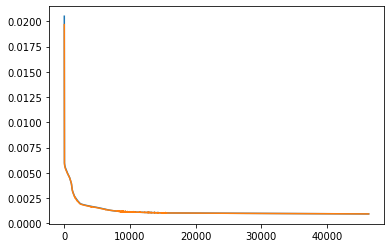

0.0009252488962374628
0.0009239547653123736
0.9821929093400888 tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward>) tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)


In [21]:
plt.plot(real_losses)
plt.plot(test_losses)
plt.show()
print(min(real_losses))
print(min(test_losses))

mrl = min(real_losses)
dh = mrl - comp_loss_healthy.item()
dl = comp_loss_lesioned.item() - comp_loss_healthy.item()
recov_pct = 1.0 - (dh / dl)
print(recov_pct, comp_loss_lesioned, comp_loss_healthy)

In [26]:
# TODO: get a CPN collection and explore the impact of the level of noise we are using.
# TODO: look for classes or data points we suck at
# TODO: train vs test
# TODO: deep dive EN grads bad

print(recent_losses)

[0.012536630965769291, 0.012541639618575573]


torch.Size([1, 341, 50])


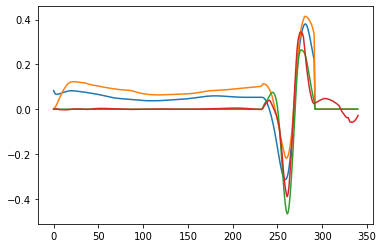

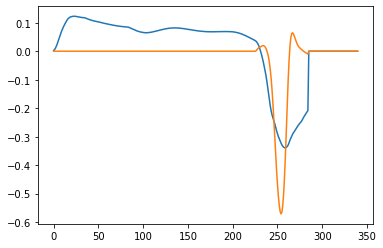

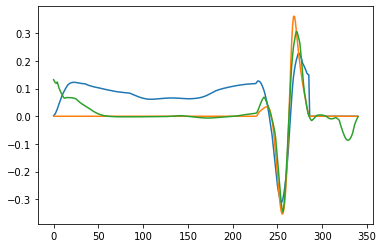

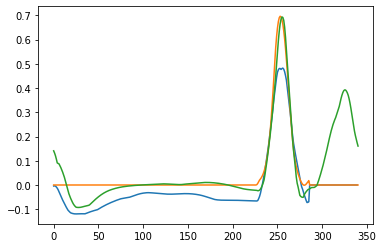

In [27]:
mike.reset()
reference_pred_lesioned_0 = mike.unroll(din[0, :, :].T)
reference_pred_lesioned_neg1 = mike.unroll(din[-1, :, :].T)
reference_pred_lesioned_20 = mike.unroll(din[20, :, :].T)
mike.reset()

print(reference_pred_lesioned_0.shape)


plt.plot(preds[0, :, 45].detach().numpy())
#plt.plot(preds.grad[0, :, 45].detach().numpy())
plt.plot(actuals[0, :, 45].detach().numpy())
plt.plot(dout[0, :, 45].detach().numpy())
plt.plot(reference_pred_lesioned_0[0, :, 45].detach().numpy())
plt.show()

#plt.plot(preds[-1, :, 45].detach().numpy())
plt.plot(actuals[-1, :, 45].detach().numpy())
plt.plot(dout[-1, :, 45].detach().numpy())
plt.show()

#plt.plot(preds[20, :, 45].detach().numpy())
plt.plot(actuals[20, :, 45].detach().numpy())
plt.plot(dout[20, :, 45].detach().numpy())
plt.plot(reference_pred_lesioned_20[0, :, 45].detach().numpy())
plt.show()

#plt.plot(preds[20, :, 7].detach().numpy())
plt.plot(actuals[20, :, 7].detach().numpy())
plt.plot(dout[20, :, 7].detach().numpy())
plt.plot(reference_pred_lesioned_20[0, :, 7].detach().numpy())
plt.show()

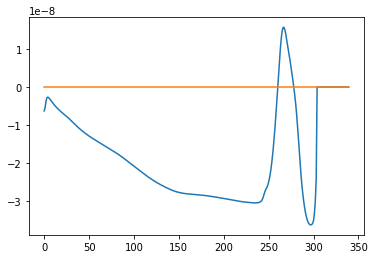

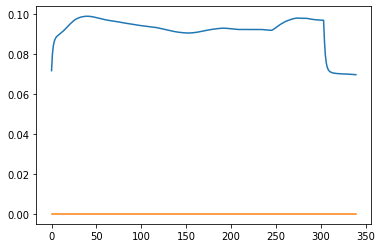

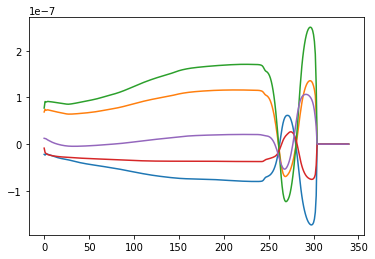

In [44]:
ss = [x[20, 6].item() for x in stims]
gg = [x.grad[20, 6].item() for x in stims]
ref = [0.0 for x in stims]

plt.plot(gg)
plt.plot(ref)
plt.show()
plt.plot(ss)
plt.plot(ref)
plt.show()

for idx in range(0, 25, 5):
    gg = [x.grad[20, idx].item() for x in stims]
    plt.plot(gg)
plt.show()

# On bad run: gradient is negative when values are too high

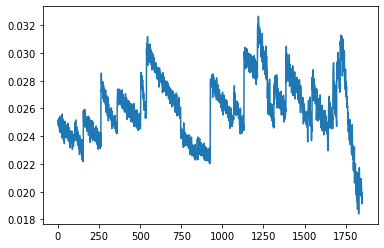

In [12]:
plt.plot(cpn_losses)